# 4 ML-ENSO - CNN Regression

In [1]:
print("hello world")

hello world


## Imports 

In [2]:
# IPython extension to reload modules before executing user code.
%load_ext autoreload
%autoreload 2

In [3]:
import torch
torch.cuda.is_available()

True

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))

Using device: cuda

NVIDIA A40


In [5]:
import utils
import utilities.graph_utils as graph_utils
import utilities.cnn_utils as cnn_utils

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import FormatStrFormatter

import os
import pandas as pd
import xarray as xr
import calendar

from datetime import datetime

import sklearn
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
import scipy.stats

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

import pickle

from tqdm import tqdm

import time


=============

## Global variables

### Define folders

In [7]:
RESULTS_FOLDER = 'saved_results'
RESULTS_ONI_FOLDER = 'saved_results/oni'
RESULTS_NINO34_FOLDER = 'saved_results/nino34'
RESULTS_EC_FOLDER = 'saved_results/ec'

target_to_results_folder = {
    "oni": RESULTS_ONI_FOLDER,
    "nino34": RESULTS_NINO34_FOLDER,
    "E": RESULTS_EC_FOLDER,
    "C": RESULTS_EC_FOLDER
}
target_to_results_folder

{'oni': 'saved_results/oni',
 'nino34': 'saved_results/nino34',
 'E': 'saved_results/ec',
 'C': 'saved_results/ec'}

### General settings

In [8]:
# OLD CNN settings
# NUM_EPOCHS = 40
# mode = "training" # "testing"

# # Adam optimizer parameters
# LEARNING_RATE = 1e-4 # CCAI tutorial
# # LEARNING_RATE = 0.005 # Ham et al. paper - doesnt work well at all
# WEIGHT_DECAY = 0 # 1e-3

# # SGD optimizer parameters
# # LEARNING_RATE = 1e-4
# # MOMENTUM = 0.9

In [9]:
# GNN settings
GENERAL_MODE = "view_results_only" # or "training" , "view_results_only"
FINETUNE_ONLY = False
TARGETS = ["E", "C"] # or ["E", "C", "oni", "nino34"]
TARGETS_STR = ''.join(TARGETS)
INPUT_TIME_STEPS = 3
START_LEAD_TIME = 0
MAX_LEAD_TIME = 25
LEAD_TIME_STEP = 1

# represent all lon*lat predictors with far fewer dimensions
USE_PCA = False
PCA_COMPONENTS = 32

SAVE_PLOTS_TO_DISK = True

In [10]:
for target in TARGETS:
    parent_directory = target_to_results_folder[target]
    directory = os.path.join(parent_directory, "cnn")
    
    if os.path.isdir(directory):
        print(f"{directory} already exist")
    else:
        print(f"Create new directory for {directory}")
        os.makedirs(directory, exist_ok=True) 

saved_results/ec/cnn already exist
saved_results/ec/cnn already exist


### Training settings

In [11]:
BATCH_SIZE = 128
NUM_EPOCHS_TRAIN = 20
NUM_EPOCHS_FINETUNE = 20

In [12]:
# IMG_FOLDER = f'img/pf_lr_rr_Target_{TARGETS_STR}/'

# if SAVE_PLOTS_TO_DISK == True:
#     os.makedirs(IMG_FOLDER, exist_ok=True) 
    
# IMG_FOLDER

In [13]:
# target = TARGETS[0]

### Model settings

In [14]:
MODEL_TYPE = "CNN3L"  
# GCN_INPUT_FEATURES=INPUT_TIME_STEPS
# GCN_HIDDEN_DIM_1=250
# GCN_HIDDEN_DIM_2=250
# GCN_HIDDEN_DIM_3=4
# GCN_OUTPUT_DIM=1
# ACTIVATION_FUNC = nn.Tanh() # nn.ReLU(), nn.LeakyReLU(), nn.Tanh(), nn.ELU()
# ACTIVATION_FUNC_STR = str(ACTIVATION_FUNC).split("(")[0]
# USE_BATCH_NORM=False
# DROPOUT_RATE=0
# DROPOUT_RATE_STR = f"{DROPOUT_RATE:.2f}".replace('.',"")

# DROPOUT_RATE_STR

# MODEL_DETAILS = f"{MODEL_TYPE}_{GCN_HIDDEN_DIM_1}x{GCN_HIDDEN_DIM_2}_{ACTIVATION_FUNC_STR}_Bn{USE_BATCH_NORM}_p{DROPOUT_RATE_STR}"
# MODEL_DETAILS_TITLE = f"{MODEL_TYPE} (EmbDims={GCN_HIDDEN_DIM_1}x{GCN_HIDDEN_DIM_2}, Act={ACTIVATION_FUNC_STR}, BatchNorm={USE_BATCH_NORM}, Dropout={DROPOUT_RATE})"

# if MODEL_TYPE == "GCN3LayerConcat":
#     MODEL_DETAILS = f"{MODEL_TYPE}_{GCN_HIDDEN_DIM_1}x{GCN_HIDDEN_DIM_2}x{GCN_HIDDEN_DIM_3}"

MODEL_DETAILS = MODEL_TYPE 
MODEL_DETAILS_TITLE = f"{MODEL_TYPE}"

print("MODEL_DETAILS: ", MODEL_DETAILS)
print("MODEL_DETAILS_TITLE: ", MODEL_DETAILS_TITLE)

MODEL_DETAILS:  CNN3L
MODEL_DETAILS_TITLE:  CNN3L


### Optimizer settings

In [15]:
OPTIMIZER_TYPE = "Adam" # "Adam" or "SGD"
if OPTIMIZER_TYPE == "Adam":
    LEARNING_RATE = 1e-4
    LEARNING_RATE_FINETUNING = 1e-5
    WEIGHT_DECAY = 0 # 1e-4
    OPTIMIZER_DETAILS = f"{OPTIMIZER_TYPE}_LR{LEARNING_RATE:.0e}_WD{WEIGHT_DECAY:.0e}"
    OPTIMIZER_DETAILS_TITLE = f"{OPTIMIZER_TYPE} (LR={str(LEARNING_RATE)}, WD={str(WEIGHT_DECAY)})"

elif OPTIMIZER_TYPE == "SGD":
    LEARNING_RATE = 1e-4
    LEARNING_RATE_FINETUNING = 1e-5
    WEIGHT_DECAY = 1e-6
    MOMENTUM = 0.8
    USE_NESTEROV = True
    OPTIMIZER_DETAILS = f"{OPTIMIZER_TYPE}_LR{LEARNING_RATE:.0e}_WD{WEIGHT_DECAY:.0e}_Mom{MOMENTUM:.0e}_Nest{USE_NESTEROV}"
    # OPTIMIZER_DETAILS_TITLE = f"{OPTIMIZER_TYPE} (LR={str(LEARNING_RATE)}/{str(LEARNING_RATE_FINETUNING)}, WD={str(WEIGHT_DECAY)}, Momentum={MOMENTUM:.2f}, Nesterov={USE_NESTEROV})"
    OPTIMIZER_DETAILS_TITLE = f"{OPTIMIZER_TYPE} (LR={str(LEARNING_RATE)}, WD={str(WEIGHT_DECAY)}, Momentum={MOMENTUM:.2f}, Nesterov={USE_NESTEROV})"


print("OPTIMIZER_TYPE:  ", OPTIMIZER_TYPE)
print("OPTIMIZER_DETAILS:  ", OPTIMIZER_DETAILS)
print("OPTIMIZER_DETAILS_TITLE:  ", OPTIMIZER_DETAILS_TITLE)

OPTIMIZER_TYPE:   Adam
OPTIMIZER_DETAILS:   Adam_LR1e-04_WD0e+00
OPTIMIZER_DETAILS_TITLE:   Adam (LR=0.0001, WD=0)


In [16]:
IMG_FOLDER = f'img/cnn_Target_{TARGETS_STR}/'
IMG_FOLDER

'img/cnn_Target_EC/'

In [17]:
if SAVE_PLOTS_TO_DISK == True:
    os.makedirs(IMG_FOLDER, exist_ok=True) 
    print("makedirs")
    
IMG_FOLDER

makedirs


'img/cnn_Target_EC/'

### Select training region

In [18]:
RESOLUTION = 5 # 1, 4 or 5 (in degrees)
FULL_MAP = False

if FULL_MAP == True:
    # Full map
    MIN_LAT, MAX_LAT = -90, +90
    MIN_LON, MAX_LON = 0, 360
    LAT_SLICE = None
    LON_SLICE = None
else:
    # Ham et. al: 0°–360°E, 55°S–60°N for three consecutive months 
    MIN_LAT, MAX_LAT = -55, 60
    MIN_LON, MAX_LON = 0, 360

    # MIN_LAT, MAX_LAT = -5, 5
    # MIN_LON, MAX_LON = 190, 240

    
    LAT_SLICE = slice(MIN_LAT, MAX_LAT)
    LON_SLICE = slice(MIN_LON, MAX_LON) 

    # Tello et. al: 0°–360°E, 75°S–65°N for three consecutive months 
    # MIN_LAT, MAX_LAT = -75, 65
    # MIN_LON, MAX_LON = 0, 360
    
    # LAT_SLICE = slice(MIN_LAT, MAX_LAT)
    # LON_SLICE = slice(MIN_LON, MAX_LON) 


# Niño 3.4 (5N-5S, 170W-120W)
# nino34_min_lat, nino34_max_lat = -5, 5
# nino34_min_lon, nino34_max_lon = 190, 240


In [19]:
COORDINATES = utils.add_cardinals_title(MIN_LAT, MAX_LAT, MIN_LON, MAX_LON)
COORDINATES

'55S-60N, 180W-180E'

### Select dataset source 

In [20]:
# source_id = "MRI-ESM2-0"
# # source_id = "MIROC6"
# # source_id = "BCC-ESM1"
# # source_id = "GISS-E2-1-G"

#### All Sources

In [21]:
ALL_SOURCE_IDS = ["MRI-ESM2-0", "MIROC6", "BCC-ESM1", "FGOALS-f3-L", "GISS-E2-1-G", "HADISST"]
print(ALL_SOURCE_IDS)

ALL_SOURCE_IDS_STR = ', '.join(ALL_SOURCE_IDS)
print(ALL_SOURCE_IDS_STR)

ALL_SOURCE_IDS_FILENAME = '_'.join([source_id.split("-")[0] for source_id in ALL_SOURCE_IDS])
print(ALL_SOURCE_IDS_FILENAME)

['MRI-ESM2-0', 'MIROC6', 'BCC-ESM1', 'FGOALS-f3-L', 'GISS-E2-1-G', 'HADISST']
MRI-ESM2-0, MIROC6, BCC-ESM1, FGOALS-f3-L, GISS-E2-1-G, HADISST
MRI_MIROC6_BCC_FGOALS_GISS_HADISST


#### Train Sources

In [22]:
# TRAIN_SOURCE_IDS = ["MRI-ESM2-0", "MIROC6", "BCC-ESM1", "FGOALS-f3-L", "GISS-E2-1-G"]
TRAIN_SOURCE_IDS = ["MIROC6", "GISS-E2-1-G"]
print(TRAIN_SOURCE_IDS)

TRAIN_SOURCE_IDS_STR = ', '.join(TRAIN_SOURCE_IDS)
print(TRAIN_SOURCE_IDS_STR)

TRAIN_SOURCE_IDS_FILENAME = '_'.join([source_id.split("-")[0] for source_id in TRAIN_SOURCE_IDS])
print(TRAIN_SOURCE_IDS_FILENAME)

['MIROC6', 'GISS-E2-1-G']
MIROC6, GISS-E2-1-G
MIROC6_GISS


#### Test Sources

In [23]:
# TEST_SOURCE_ID = "HADISST"
TEST_SOURCE_ID = "GODAS"
print(TEST_SOURCE_ID)

TEST_SOURCE_ID_FILENAME = TEST_SOURCE_ID.split("-")[0]
print(TEST_SOURCE_ID_FILENAME)

GODAS
GODAS


#### Fine-tuning Sources

In [24]:
FINETUNE_SOURCE_IDS = ["HADISST"]
print(FINETUNE_SOURCE_IDS)

FINETUNE_SOURCE_IDS_STR = ', '.join(FINETUNE_SOURCE_IDS)
print(FINETUNE_SOURCE_IDS_STR)

['HADISST']
HADISST


### Select dates for Train-Val-Test split
Randomly splitting time series data into a train set and a test set is very risky. \
In many climate datasets, time series have a non-neglible auto-correlation (correlation of a time series and its lagged version over time). \
Think of it like this: the atmosphere usually has a "memory" of about 14 days, and the ocean roughly has a "memory" of about 2 years.

_(source: [CCAI Seasonal Forecasting tutorial](https://colab.research.google.com/drive/1eLEYFK3Mrae_nu1SzAjg7Sdf40bWnKTg#scrollTo=XrbMcDoscZM0&forceEdit=true&sandboxMode=true))_

Ham et al split (Extended Data Table 2)
- **Training dataset**:
    - CMIP5 historical run: 1861-2004  
    - Reanalysis (SODA): 1871-1973
- **Validation dataset**:
    - Reanalysis (GODAS): 1984-2017

In [25]:
# train_start_date = '1851-01-01'
# train_start_date = '1871-01-01'
# train_end_date = '1970-12-31'

# val_start_date = '1976-01-01'
# val_end_date =   '1990-12-31'

# these "Old dates are used to evaluate the pre-trained model
# on the CMIP and HadISST datasets that only go up to 2015
test_start_date_PRETRAIN = '1996-01-01'
test_end_date_PRETRAIN =   '2010-12-31'




# Following Ham et al split (Extended Data Table 2),
# and splitting the training dataset into train and val
# We include a 10 year gap betwen each set #

# train set: 83 years
train_start_date = '1871-01-01'
train_end_date = '1953-12-31'

# val set: 10 years
val_start_date = '1964-01-01'
val_end_date =   '1973-12-31'

# val set: 34 years
test_start_date = '1984-01-01'
test_end_date =   '2017-12-31'

print(f"Train start and end dates: {train_start_date} to {train_end_date}")
print(f"Val start and end dates: {val_start_date} to {val_end_date}")
print(f"Test start and end dates: {test_start_date} to {test_end_date}")

Train start and end dates: 1871-01-01 to 1953-12-31
Val start and end dates: 1964-01-01 to 1973-12-31
Test start and end dates: 1984-01-01 to 2017-12-31


In [26]:
train_years, train_months, train_days = graph_utils.compute_time_interval(train_start_date, train_end_date)
val_years, val_months, val_days = graph_utils.compute_time_interval(val_start_date, val_end_date)
test_years, test_months, test_days = graph_utils.compute_time_interval(test_start_date, test_end_date)
total_years = train_years + val_years + test_years
print(f"Total years (not including gaps between datsets): {train_years + val_years + test_years}")

print(f"The training period is   {train_years:>2} years, {train_months:>2} months, and {train_days:>2} days long ({train_years/total_years:.1%})")
print(f"The validation period is {val_years:>2} years, {val_months:>2} months, and {val_days:>2} days long ({val_years/total_years:.1%})")
print(f"The testing period is    {test_years:>2} years, {test_months:>2} months, and {test_days:>2} days long ({test_years/total_years:.1%})")
print()

years, months, days = graph_utils.compute_time_interval(train_end_date, val_start_date)
print(f"The interval between the training set and the validation set is:    {years:>2} years, {months:>2} months, and {days:>2} days long")

years, months, days = graph_utils.compute_time_interval(val_end_date, test_start_date)
print(f"The interval between the training set and the validation set is:    {years:>2} years, {months:>2} months, and {days:>2} days long")

Total years (not including gaps between datsets): 127
The training period is   83 years,  0 months, and  0 days long (65.4%)
The validation period is 10 years,  0 months, and  0 days long (7.9%)
The testing period is    34 years,  0 months, and  0 days long (26.8%)

The interval between the training set and the validation set is:    10 years,  0 months, and  0 days long
The interval between the training set and the validation set is:    10 years,  0 months, and  0 days long


In [27]:
# extract year part of the dates
train_start_year = train_start_date.split("-")[0]
train_end_year   = train_end_date.split("-")[0]

val_start_year = val_start_date.split("-")[0]
val_end_year   = val_end_date.split("-")[0]

test_start_year = test_start_date.split("-")[0]
test_end_year   = test_end_date.split("-")[0]


print(f"Train start and end years: {train_start_year}-{train_end_year}")
print(f"Val start and end years: {val_start_year}-{val_end_year}")
print(f"Test start and end years: {test_start_year}-{test_end_year}")


Train start and end years: 1871-1953
Val start and end years: 1964-1973
Test start and end years: 1984-2017


### Experiment General Name

In [28]:
EXPERIMENT_GENERAL_NAME = (
    f"{MODEL_DETAILS}_"
    f"Train_{TRAIN_SOURCE_IDS_FILENAME}_"
    f"Tune_{FINETUNE_SOURCE_IDS_STR}_"
    f"{train_start_year}-{train_end_year}_"
    f"Ep{NUM_EPOCHS_TRAIN:02d}-{NUM_EPOCHS_FINETUNE:02d}_"
    f"Test_{TEST_SOURCE_ID_FILENAME}_"
    f"{test_start_year}-{test_end_year}_"
    f"Win{INPUT_TIME_STEPS:02d}_"
    f"{utils.add_cardinals_fname(MIN_LAT, MAX_LAT, MIN_LON, MAX_LON)}_"
    f"Res{RESOLUTION}_"
    f"{OPTIMIZER_TYPE}"
    # f"{OPTIMIZER_DETAILS}"
)


EXPERIMENT_GENERAL_NAME = EXPERIMENT_GENERAL_NAME.replace("MRI_MIROC6_BCC_FGOALS_GISS_HADISST", "ALL")
EXPERIMENT_GENERAL_NAME = EXPERIMENT_GENERAL_NAME.replace("MRI_MIROC6_BCC_FGOALS_GISS", "CMIP6")
print(EXPERIMENT_GENERAL_NAME)

CNN3L_Train_MIROC6_GISS_Tune_HADISST_1871-1953_Ep20-20_Test_GODAS_1984-2017_Win03_55S-60N-180W-180E_Res5_Adam


# ============================================================

## Training

### Assemble predictors / predictands example
This section was inspired by CCAI AI for Climate science - Forecasting the El Niño with Machine Learning

In [29]:
TRAIN_SOURCE_IDS
TEST_SOURCE_ID

'GODAS'

In [30]:
# # example
# X_train_example, y_train_example = graph_utils.assemble_graph_predictors_predictands(TEST_SOURCE_ID, RESOLUTION, TARGETS[0], train_start_date, train_end_date, 
#                                                                      lead_time=1, num_input_time_steps=INPUT_TIME_STEPS, lat_slice=LAT_SLICE, lon_slice=LON_SLICE,  
#                                                                      data_format="flatten", use_pca=USE_PCA, pca_components=PCA_COMPONENTS, fill_nan=True, remove_win=False, verbose=True)

# X_train_example.shape, y_train_example.shape

## Define functions

### `class CNN(nn.Module)`

Define CNN class

Let's define a simple convolutional neural network architecture.  This architecture has 1 convolutional layer, followed by a pooling layer, followed by another convolutional layer, followed by three fully connected layers (called `nn.Linear` layers).  The output of the final fully connected layer is a 1-D array, since we are trying to forecast 1 value: the target ENSO index.



In [31]:
# %%html
# <svg xmlns="http://www.w3.org/2000/svg" width="1920" height="968" style="cursor: move;"><g transform="translate(105.91727748695973,-95.483536707501) scale(0.5312798661483706)"><rect class="rect" id="0_0" width="360" height="180" x="-160" y="260" style="fill: rgb(160, 160, 160); stroke: black; stroke-width: 1.72; opacity: 0.7;"></rect><rect class="rect" id="0_1" width="360" height="180" x="-152" y="268" style="fill: rgb(241, 233, 233); stroke: black; stroke-width: 1.72; opacity: 0.7;"></rect><rect class="rect" id="0_2" width="360" height="180" x="-144" y="276" style="fill: rgb(160, 160, 160); stroke: black; stroke-width: 1.72; opacity: 0.7;"></rect><rect class="rect" id="0_3" width="360" height="180" x="-136" y="284" style="fill: rgb(241, 233, 233); stroke: black; stroke-width: 1.72; opacity: 0.7;"></rect><rect class="rect" id="0_4" width="360" height="180" x="-128" y="292" style="fill: rgb(160, 160, 160); stroke: black; stroke-width: 1.72; opacity: 0.7;"></rect><rect class="rect" id="0_5" width="360" height="180" x="-120" y="300" style="fill: rgb(241, 233, 233); stroke: black; stroke-width: 1.72; opacity: 0.7;"></rect><rect class="rect" id="0_6" width="360" height="180" x="-112" y="308" style="fill: rgb(160, 160, 160); stroke: black; stroke-width: 1.72; opacity: 0.7;"></rect><rect class="rect" id="0_7" width="360" height="180" x="-104" y="316" style="fill: rgb(241, 233, 233); stroke: black; stroke-width: 1.72; opacity: 0.7;"></rect><rect class="rect" id="0_8" width="360" height="180" x="-96" y="324" style="fill: rgb(160, 160, 160); stroke: black; stroke-width: 1.72; opacity: 0.7;"></rect><rect class="rect" id="0_9" width="360" height="180" x="-88" y="332" style="fill: rgb(241, 233, 233); stroke: black; stroke-width: 1.72; opacity: 0.7;"></rect><rect class="rect" id="0_10" width="360" height="180" x="-80" y="340" style="fill: rgb(160, 160, 160); stroke: black; stroke-width: 1.72; opacity: 0.7;"></rect><rect class="rect" id="0_11" width="360" height="180" x="-72" y="348" style="fill: rgb(241, 233, 233); stroke: black; stroke-width: 1.72; opacity: 0.7;"></rect><rect class="rect" id="1_0" width="358" height="178" x="328" y="285" style="fill: rgb(160, 160, 160); stroke: black; stroke-width: 1.72; opacity: 0.7;"></rect><rect class="rect" id="1_1" width="358" height="178" x="336" y="293" style="fill: rgb(241, 233, 233); stroke: black; stroke-width: 1.72; opacity: 0.7;"></rect><rect class="rect" id="1_2" width="358" height="178" x="344" y="301" style="fill: rgb(160, 160, 160); stroke: black; stroke-width: 1.72; opacity: 0.7;"></rect><rect class="rect" id="1_3" width="358" height="178" x="352" y="309" style="fill: rgb(241, 233, 233); stroke: black; stroke-width: 1.72; opacity: 0.7;"></rect><rect class="rect" id="1_4" width="358" height="178" x="360" y="317" style="fill: rgb(160, 160, 160); stroke: black; stroke-width: 1.72; opacity: 0.7;"></rect><rect class="rect" id="1_5" width="358" height="178" x="368" y="325" style="fill: rgb(241, 233, 233); stroke: black; stroke-width: 1.72; opacity: 0.7;"></rect><rect class="rect" id="2_0" width="179" height="89" x="765" y="374.5" style="fill: rgb(160, 160, 160); stroke: black; stroke-width: 1.72; opacity: 0.7;"></rect><rect class="rect" id="2_1" width="179" height="89" x="773" y="382.5" style="fill: rgb(241, 233, 233); stroke: black; stroke-width: 1.72; opacity: 0.7;"></rect><rect class="rect" id="2_2" width="179" height="89" x="781" y="390.5" style="fill: rgb(160, 160, 160); stroke: black; stroke-width: 1.72; opacity: 0.7;"></rect><rect class="rect" id="2_3" width="179" height="89" x="789" y="398.5" style="fill: rgb(241, 233, 233); stroke: black; stroke-width: 1.72; opacity: 0.7;"></rect><rect class="rect" id="2_4" width="179" height="89" x="797" y="406.5" style="fill: rgb(160, 160, 160); stroke: black; stroke-width: 1.72; opacity: 0.7;"></rect><rect class="rect" id="2_5" width="179" height="89" x="805" y="414.5" style="fill: rgb(241, 233, 233); stroke: black; stroke-width: 1.72; opacity: 0.7;"></rect><rect class="rect" id="3_0" width="175" height="85" x="1011" y="336.5" style="fill: rgb(160, 160, 160); stroke: black; stroke-width: 1.72; opacity: 0.7;"></rect><rect class="rect" id="3_1" width="175" height="85" x="1019" y="344.5" style="fill: rgb(241, 233, 233); stroke: black; stroke-width: 1.72; opacity: 0.7;"></rect><rect class="rect" id="3_2" width="175" height="85" x="1027" y="352.5" style="fill: rgb(160, 160, 160); stroke: black; stroke-width: 1.72; opacity: 0.7;"></rect><rect class="rect" id="3_3" width="175" height="85" x="1035" y="360.5" style="fill: rgb(241, 233, 233); stroke: black; stroke-width: 1.72; opacity: 0.7;"></rect><rect class="rect" id="3_4" width="175" height="85" x="1043" y="368.5" style="fill: rgb(160, 160, 160); stroke: black; stroke-width: 1.72; opacity: 0.7;"></rect><rect class="rect" id="3_5" width="175" height="85" x="1051" y="376.5" style="fill: rgb(241, 233, 233); stroke: black; stroke-width: 1.72; opacity: 0.7;"></rect><rect class="rect" id="3_6" width="175" height="85" x="1059" y="384.5" style="fill: rgb(160, 160, 160); stroke: black; stroke-width: 1.72; opacity: 0.7;"></rect><rect class="rect" id="3_7" width="175" height="85" x="1067" y="392.5" style="fill: rgb(241, 233, 233); stroke: black; stroke-width: 1.72; opacity: 0.7;"></rect><rect class="rect" id="3_8" width="175" height="85" x="1075" y="400.5" style="fill: rgb(160, 160, 160); stroke: black; stroke-width: 1.72; opacity: 0.7;"></rect><rect class="rect" id="3_9" width="175" height="85" x="1083" y="408.5" style="fill: rgb(241, 233, 233); stroke: black; stroke-width: 1.72; opacity: 0.7;"></rect><rect class="rect" id="3_10" width="175" height="85" x="1091" y="416.5" style="fill: rgb(160, 160, 160); stroke: black; stroke-width: 1.72; opacity: 0.7;"></rect><rect class="rect" id="3_11" width="175" height="85" x="1099" y="424.5" style="fill: rgb(241, 233, 233); stroke: black; stroke-width: 1.72; opacity: 0.7;"></rect><rect class="rect" id="3_12" width="175" height="85" x="1107" y="432.5" style="fill: rgb(160, 160, 160); stroke: black; stroke-width: 1.72; opacity: 0.7;"></rect><rect class="rect" id="3_13" width="175" height="85" x="1115" y="440.5" style="fill: rgb(241, 233, 233); stroke: black; stroke-width: 1.72; opacity: 0.7;"></rect><rect class="rect" id="3_14" width="175" height="85" x="1123" y="448.5" style="fill: rgb(160, 160, 160); stroke: black; stroke-width: 1.72; opacity: 0.7;"></rect><rect class="rect" id="3_15" width="175" height="85" x="1131" y="456.5" style="fill: rgb(241, 233, 233); stroke: black; stroke-width: 1.72; opacity: 0.7;"></rect><rect class="rect" id="4_0" width="87" height="42" x="1294" y="380.5" style="fill: rgb(160, 160, 160); stroke: black; stroke-width: 1.72; opacity: 0.7;"></rect><rect class="rect" id="4_1" width="87" height="42" x="1302" y="388.5" style="fill: rgb(241, 233, 233); stroke: black; stroke-width: 1.72; opacity: 0.7;"></rect><rect class="rect" id="4_2" width="87" height="42" x="1310" y="396.5" style="fill: rgb(160, 160, 160); stroke: black; stroke-width: 1.72; opacity: 0.7;"></rect><rect class="rect" id="4_3" width="87" height="42" x="1318" y="404.5" style="fill: rgb(241, 233, 233); stroke: black; stroke-width: 1.72; opacity: 0.7;"></rect><rect class="rect" id="4_4" width="87" height="42" x="1326" y="412.5" style="fill: rgb(160, 160, 160); stroke: black; stroke-width: 1.72; opacity: 0.7;"></rect><rect class="rect" id="4_5" width="87" height="42" x="1334" y="420.5" style="fill: rgb(241, 233, 233); stroke: black; stroke-width: 1.72; opacity: 0.7;"></rect><rect class="rect" id="4_6" width="87" height="42" x="1342" y="428.5" style="fill: rgb(160, 160, 160); stroke: black; stroke-width: 1.72; opacity: 0.7;"></rect><rect class="rect" id="4_7" width="87" height="42" x="1350" y="436.5" style="fill: rgb(241, 233, 233); stroke: black; stroke-width: 1.72; opacity: 0.7;"></rect><rect class="rect" id="4_8" width="87" height="42" x="1358" y="444.5" style="fill: rgb(160, 160, 160); stroke: black; stroke-width: 1.72; opacity: 0.7;"></rect><rect class="rect" id="4_9" width="87" height="42" x="1366" y="452.5" style="fill: rgb(241, 233, 233); stroke: black; stroke-width: 1.72; opacity: 0.7;"></rect><rect class="rect" id="4_10" width="87" height="42" x="1374" y="460.5" style="fill: rgb(160, 160, 160); stroke: black; stroke-width: 1.72; opacity: 0.7;"></rect><rect class="rect" id="4_11" width="87" height="42" x="1382" y="468.5" style="fill: rgb(241, 233, 233); stroke: black; stroke-width: 1.72; opacity: 0.7;"></rect><rect class="rect" id="4_12" width="87" height="42" x="1390" y="476.5" style="fill: rgb(160, 160, 160); stroke: black; stroke-width: 1.72; opacity: 0.7;"></rect><rect class="rect" id="4_13" width="87" height="42" x="1398" y="484.5" style="fill: rgb(241, 233, 233); stroke: black; stroke-width: 1.72; opacity: 0.7;"></rect><rect class="rect" id="4_14" width="87" height="42" x="1406" y="492.5" style="fill: rgb(160, 160, 160); stroke: black; stroke-width: 1.72; opacity: 0.7;"></rect><rect class="rect" id="4_15" width="87" height="42" x="1414" y="500.5" style="fill: rgb(241, 233, 233); stroke: black; stroke-width: 1.72; opacity: 0.7;"></rect><rect class="conv" id="conv_0" width="3" height="3" x="218.60428887257763" y="494.19684262295436" style="fill-opacity: 0; stroke: black; stroke-width: 1.72; stroke-opacity: 0.7;"></rect><rect class="conv" id="conv_1" width="2" height="2" x="435.64172016475936" y="440.68643195098923" style="fill-opacity: 0; stroke: black; stroke-width: 1.72; stroke-opacity: 0.7;"></rect><rect class="conv" id="conv_2" width="5" height="5" x="916.9283357829074" y="483.693847790169" style="fill-opacity: 0; stroke: black; stroke-width: 1.72; stroke-opacity: 0.7;"></rect><rect class="conv" id="conv_3" width="2" height="2" x="1273.1703458522607" y="495.6770801236129" style="fill-opacity: 0; stroke: black; stroke-width: 1.72; stroke-opacity: 0.7;"></rect><line class="link" id="conv_0" x1="221.60428887257763" y1="497.19684262295436" x2="659.4183064884671" y2="472.0228134852309" style="stroke: black; stroke-width: 0.86; stroke-opacity: 0.7;"></line><line class="link" id="conv_0" x1="221.60428887257763" y1="494.19684262295436" x2="659.4183064884671" y2="472.0228134852309" style="stroke: black; stroke-width: 0.86; stroke-opacity: 0.7;"></line><line class="link" id="conv_1" x1="437.64172016475936" y1="442.68643195098923" x2="839.0108649143032" y2="473.0005252479434" style="stroke: black; stroke-width: 0.86; stroke-opacity: 0.7;"></line><line class="link" id="conv_1" x1="437.64172016475936" y1="440.68643195098923" x2="839.0108649143032" y2="473.0005252479434" style="stroke: black; stroke-width: 0.86; stroke-opacity: 0.7;"></line><line class="link" id="conv_2" x1="921.9283357829074" y1="488.693847790169" x2="1243.5716020805103" y2="526.5175840733853" style="stroke: black; stroke-width: 0.86; stroke-opacity: 0.7;"></line><line class="link" id="conv_2" x1="921.9283357829074" y1="483.693847790169" x2="1243.5716020805103" y2="526.5175840733853" style="stroke: black; stroke-width: 0.86; stroke-opacity: 0.7;"></line><line class="link" id="conv_3" x1="1275.1703458522607" y1="497.6770801236129" x2="1485.4960698794607" y2="520.3245465685752" style="stroke: black; stroke-width: 0.86; stroke-opacity: 0.7;"></line><line class="link" id="conv_3" x1="1275.1703458522607" y1="495.6770801236129" x2="1485.4960698794607" y2="520.3245465685752" style="stroke: black; stroke-width: 0.86; stroke-opacity: 0.7;"></line><polygon class="poly" id="fc_0" points="1506,277.52481989352816 1516,277.52481989352816 1928.9503602129437,690.475180106472 1918.9503602129437,690.475180106472" style="fill: rgb(241, 233, 233); stroke: black; stroke-width: 1.72; opacity: 0.7;"></polygon><polygon class="poly" id="fc_1" points="1883.950360212944,441.57359312880715 1893.950360212944,441.57359312880715 1978.8031739553296,526.4264068711929 1968.8031739553296,526.4264068711929" style="fill: rgb(241, 233, 233); stroke: black; stroke-width: 1.72; opacity: 0.7;"></polygon><polygon class="poly" id="fc_2" points="1980.8031739553294,483.6464466094067 1990.8031739553294,483.6464466094067 1991.5102807365158,484.3535533905933 1981.5102807365158,484.3535533905933" style="fill: rgb(241, 233, 233); stroke: black; stroke-width: 1.72; opacity: 0.7;"></polygon><line class="line" id="fc_0" x1="1501" y1="587.5" x2="1918.950360212944" y2="690.4751801064718" style="stroke: black; stroke-width: 0.86; stroke-opacity: 0.7; opacity: 1;"></line><line class="line" id="fc_0" x1="1381" y1="380.5" x2="1506" y2="277.52481989352816" style="stroke: black; stroke-width: 0.86; stroke-opacity: 0.7; opacity: 1;"></line><line class="line" id="fc_1" x1="1928.950360212944" y1="690.4751801064718" x2="1968.8031739553294" y2="526.4264068711929" style="stroke: black; stroke-width: 0.86; stroke-opacity: 0.7; opacity: 1;"></line><line class="line" id="fc_1" x1="1516" y1="277.52481989352816" x2="1883.950360212944" y2="441.57359312880715" style="stroke: black; stroke-width: 0.86; stroke-opacity: 0.7; opacity: 1;"></line><line class="line" id="fc_2" x1="1978.8031739553294" y1="526.4264068711929" x2="1981.510280736516" y2="484.3535533905933" style="stroke: black; stroke-width: 0.86; stroke-opacity: 0.7; opacity: 1;"></line><line class="line" id="fc_2" x1="1893.950360212944" y1="441.57359312880715" x2="1980.8031739553294" y2="483.6464466094067" style="stroke: black; stroke-width: 0.86; stroke-opacity: 0.7; opacity: 1;"></line><text class="text" dy=".35em" font-family="sans-serif" x="392.5" y="708" style="font-size: 16px; opacity: 1;">Conv2d(in=12, out=6, kernel=3) </text><text class="text" dy=".35em" font-family="sans-serif" x="785.25" y="708" style="font-size: 16px; opacity: 1;">Max-Pool(kernel=2, stride=2)</text><text class="text" dy=".35em" font-family="sans-serif" x="1056.25" y="708" style="font-size: 16px; opacity: 1;">Conv2d(in=6, out=16, kernel=5) </text><text class="text" dy=".35em" font-family="sans-serif" x="1336.75" y="708" style="font-size: 16px; opacity: 1;">Max-Pool(kernel=2,size=2)</text><text class="text" dy=".35em" font-family="sans-serif" x="1591.7375900532359" y="708" style="font-size: 16px; opacity: 1;">Linear (in=58464, out=120)</text><text class="info" dy="-0.3em" font-family="sans-serif" x="-160" y="245" style="font-size: 16px;">12@180x360</text><text class="info" dy="-0.3em" font-family="sans-serif" x="328" y="270" style="font-size: 16px;">6@178x358</text><text class="info" dy="-0.3em" font-family="sans-serif" x="765" y="359.5" style="font-size: 16px;">6@89x179</text><text class="info" dy="-0.3em" font-family="sans-serif" x="1011" y="321.5" style="font-size: 16px;">16@85x175</text><text class="info" dy="-0.3em" font-family="sans-serif" x="1294" y="365.5" style="font-size: 16px;">16@42x87</text><text class="info" dy="-0.3em" font-family="sans-serif" x="1506" y="262.52481989352816" style="font-size: 16px;">1x584</text><text class="info" dy="-0.3em" font-family="sans-serif" x="1883.950360212944" y="426.57359312880715" style="font-size: 16px;">1x120</text><text class="info" dy="-0.3em" font-family="sans-serif" x="1980.8031739553294" y="468.6464466094067" style="font-size: 16px;">1x1</text></g></svg>

#### V1 - Full map (90S-90N, 180W-180E)

In [32]:
# V1 - Full map (90S-90N, 180W-180E)
if FULL_MAP:
    class CNN(nn.Module): 
        def __init__(self, num_input_time_steps=1, print_feature_dimension=False):
            """
            inputs
            -------
                num_input_time_steps        (int) : the number of input time
                                                    steps in the predictor
                print_feature_dimension    (bool) : whether or not to print
                                                    out the dimension of the features
                                                    extracted from the conv layers
            """
            super(CNN, self).__init__()
            self.conv1 = nn.Conv2d(num_input_time_steps, 6, 3) # torch.nn.Conv2d(in_channels, out_channels, kernel_size)
            self.pool = nn.MaxPool2d(2, 2) # torch.nn.MaxPool2d(kernel_size, stride=None,
            self.conv2 = nn.Conv2d(6, 16, 5)
            self.print_layer = Print()
    
            self.fc1 = nn.Linear(16 * 42 * 87, 120)
            self.fc2 = nn.Linear(120, 84)
            self.fc3 = nn.Linear(84, 1)
            self.print_feature_dimension = print_feature_dimension
    
        def forward(self, x):
            # print("CNN forward method x.shape: ", x.shape)
            x = self.pool(F.relu(self.conv1(x)))
            x = self.pool(F.relu(self.conv2(x)))
            if self.print_feature_dimension:
              x = self.print_layer(x)
            x = x.view(-1, 16 * 42 * 87)
            x = F.relu(self.fc1(x))
            x = F.relu(self.fc2(x))
            x = self.fc3(x)
            return x
    
    class Print(nn.Module):
        """
        This class prints out the size of the features
        """
        def forward(self, x):
            print(x.size())
            return x

#### V2 - Nino3.4 region (5N-5S, 170W-120W)

In [33]:
# # V2 - Nino3.4 region (5N-5S, 170W-120W)
# class CNN(nn.Module):
#     def __init__(self, num_input_time_steps=1, print_feature_dimension=False):
#         """
#         inputs
#         -------
#             num_input_time_steps        (int) : the number of input time
#                                                 steps in the predictor
#             print_feature_dimension    (bool) : whether or not to print
#                                                 out the dimension of the features
#                                                 extracted from the conv layers
#         """
#         super(CNN, self).__init__()
#         self.conv1 = nn.Conv2d(num_input_time_steps, 6, 3) # torch.nn.Conv2d(in_channels, out_channels, kernel_size)
#         self.pool = nn.MaxPool2d(2, 2) # torch.nn.MaxPool2d(kernel_size, stride=None,
#         self.conv2 = nn.Conv2d(6, 16, 3)
#         self.print_layer = Print()

#         self.fc1 = nn.Linear(16 * 1 * 11, 120)
#         self.fc2 = nn.Linear(120, 84)
#         self.fc3 = nn.Linear(84, 1)
#         self.print_feature_dimension = print_feature_dimension

#     def forward(self, x):
#         # print("CNN forward method x.shape: ", x.shape)
#         x = self.pool(F.relu(self.conv1(x)))
#         x = self.pool(F.relu(self.conv2(x)))
#         if self.print_feature_dimension:
#           x = self.print_layer(x)
#         # print("Input:", x.shape)
#         # x = F.relu(self.conv1(x))
#         # print("After Conv1:", x.shape)
#         # x = self.pool(x)
#         # print("After Pool1:", x.shape)
#         # x = F.relu(self.conv2(x))
#         # print("After Conv2:", x.shape)
#         # x = self.pool(x)
#         # print("After Pool2:", x.shape)

        
#         x = x.view(-1, 16 * 1 * 11)
#         x = F.relu(self.fc1(x))
#         x = F.relu(self.fc2(x))
#         x = self.fc3(x)
#         return x

# class Print(nn.Module):
#     """
#     This class prints out the size of the features
#     """
#     def forward(self, x):
#         print(x.size())
#         return x

#### V3 - Ham et. Al (55°S–60°N, 0°–360°E)

In [34]:
not FULL_MAP

True

In [35]:
# # V3 - Ham et. Al: 55°S–60°N, 0°–360°E
# if not FULL_MAP:
#     class CNN(nn.Module):
#         def __init__(self, num_input_time_steps=1, print_feature_dimension=False):
#             """
#             inputs
#             -------
#                 num_input_time_steps        (int) : the number of input time
#                                                     steps in the predictor
#                 print_feature_dimension    (bool) : whether or not to print
#                                                     out the dimension of the features
#                                                     extracted from the conv layers
#             """
#             super(CNN, self).__init__()
#             self.conv1 = nn.Conv2d(num_input_time_steps, 6, 3) # torch.nn.Conv2d(in_channels, out_channels, kernel_size)
#             self.pool = nn.MaxPool2d(2, 2) # torch.nn.MaxPool2d(kernel_size, stride=None,
#             self.conv2 = nn.Conv2d(6, 16, 5)
#             self.print_layer = Print()
    
#             self.fc1 = nn.Linear(16 * 26 * 87, 120)
#             self.fc2 = nn.Linear(120, 84)
#             self.fc3 = nn.Linear(84, 1)
#             self.print_feature_dimension = print_feature_dimension
    
#         def forward(self, x):
#             # print("CNN forward method x.shape: ", x.shape)
#             x = self.pool(F.relu(self.conv1(x)))
#             x = self.pool(F.relu(self.conv2(x)))       
#             if self.print_feature_dimension:
#               x = self.print_layer(x)        
#             x = x.view(-1, 16 * 26 * 87)
#             x = F.relu(self.fc1(x))
#             x = F.relu(self.fc2(x))
#             x = self.fc3(x)
#             return x
    
#     class Print(nn.Module):
#         """
#         This class prints out the size of the features
#         """
#         def forward(self, x):
#             print(x.size())
#             return x

#### Compute and plot Time series components

![Ham et al. CNN archi](img/illustrations/ham_et_al_cnn_archi.jpg)\
_(Source: [Ham et al. Deep learning for multi-year ENSO forecasts](https://www.nature.com/articles/s41586-019-1559-7))_

##### Methods

- **Architecture of the CNN model applied to ENSO forecasts**
    - 3 convolutional layers
    - 2 max-pooling layers between the layers (extracts the largest value from each 2 × 2 grid)
    - The third convolutional layer is linked to the neurons in the fully connected layer, which is linked to the final output.
    - size of the mini batch for each epoch is set to 400,
    - the number of an epoch is 700 for the first training using CMIP5 output
    - learning rate is fixed to 0.005
- **Convolutional process**
    - convolutional filter dimensions:
        - 8 × 4 during the first convolutional process (8 zonal x 4 meridional)
        - 4 × 2 during the second  convolutional processes. 
        - 4 × 2 during the third convolutional processes. 
    - (tanh) is used as the activation function
    - $M_i$: Nb of Feature Maps (= output_channels) at the ith layer
    - dimensions of the feature map in the third convolutional layer: X = 18; Y = 6


- Number of convolutional filters M = 30 or 50
- Number of neurons in Fully Connected layer N = 30 or 50
- --> 4 combinations C30H30, C30H50, C50H30 and C50H50 (prediction from these four CNN models are averaged to obtain the final forecast results)


  
| Layer (type)                                                                   | Output shape  | Output shape  |
| ---                                                                            | ---           | ---           |
|                                                                                |               |               |
|                                                                                | (Ham et al.)  |(Murray et al.)|
|                                                                                |               |               |
| Input data (variables, lat, lon)                                               | 6 × 24 × 72   | 6 × 115 × 360 |
| nn.Conv2d(in_channels=6, out_channels=M, kernel_size=(8,4), padding='same')    | M × 24 × 72   | M × 115 × 360 |
| F.tanh(.)                                                                      | M × 24 × 72   | M × 115 × 360 |
| nn.MaxPool(kernel_size=2, stride=2)                                            | M × 12 × 36   | M × 57 x 180  |
| nn.Dropout(conv_drop)                                                          | M × 12 × 36   | M × 57 x 180  |
| -----------------------------------------------------------------------------  | ------------- | ------------- |
|                                                                                |               |               |
| nn.Conv2d(in_channels=M, out_channels=M, kernel_size=(4, 2), padding='same')   | M × 12 × 36   | M × 57 x 180  |
| F.tanh(.)                                                                      | M × 12 × 36   | M × 57 x 180  |
| nn.MaxPool(kernel_size=2, stride=2)                                            | M × 6 × 18    | M × 28 x 90   |
| nn.Dropout(conv_drop)                                                          | M × 6 × 18    | M × 28 x 90   |
| -----------------------------------------------------------------------------  |-------------  |-------------  |
|                                                                                |               |               |
| nn.Conv2d(in_channels=M, out_channels=M, kernel_size=(4, 2), padding='same')   | M × 6 × 18    | M × 28 x 90   |
| F.tanh(.)                                                                      | M × 6 × 18    | M × 28 x 90   |
| x.view(-1, Mx6x18)                                                             | M × 6 × 18    | M × 28 x 90   |
| nn.Dropout(conv_drop)                                                          | M × 6 × 18    | M × 28 x 90   |
| -----------------------------------------------------------------------------  |-------------  |-------------  |
|                                                                                |               |               |
| nn.Linear(M×6×18, N)                                                           | N             | N             |
| F.tanh(.)                                                                      | N             | N             |
| nn.Dropout(conv_drop)                                                          | N             | N             |
| -----------------------------------------------------------------------------  |-------------  |-------------  |
|                                                                                |               |               |
| nn.Linear(N, 1)                                                                | 1             | 1             |

In [36]:
# convert model to PyTorch from https://github.com/jeonghwan723/DL_ENSO/blob/master/CNN/sample/nino_type.train_cmip.sample
if not FULL_MAP:
            
    num_convf = 30 # or 50
    num_hiddf = 30 # or 50
    # xdim = 72
    # ydim = 24
    # zdim = 6 # (SST_t-0, SST_t-1, SST_t-2, HC_t-0, HC_t-1, HC_t-2)

    if RESOLUTION == 1:
        xdim = 360
        ydim = 115
    elif RESOLUTION == 4:
        xdim = 90
        ydim = 28  
    elif RESOLUTION == 5:
        xdim = 72
        ydim = 23        
    # zdim = num_input_time_steps # (SST_t-0, SST_t-1, SST_t-2)
    xdim2 = int(xdim / 4)
    ydim2 = int(ydim / 4)
    
    conv_drop = 0.5
    hidd_drop = 0.5
    class CNN(nn.Module):
        def __init__(self, num_input_time_steps=1, print_feature_dimension=False):
            super(CNN, self).__init__()

            zdim = num_input_time_steps # (SST_t-0, SST_t-1, SST_t-2)
            self.conv1 = nn.Conv2d(zdim, num_convf, kernel_size=(8, 4), padding='same')
            self.conv2 = nn.Conv2d(num_convf, num_convf, kernel_size=(4, 2), padding='same')
            self.conv3 = nn.Conv2d(num_convf, num_convf, kernel_size=(4, 2), padding='same')
            self.fc1 = nn.Linear(num_convf * xdim2 * ydim2, num_hiddf)
            self.fc2 = nn.Linear(num_hiddf, 1)
            self.dropout_conv = nn.Dropout(p=conv_drop) # randomly zeroes some of the elements of the input tensor with probability p.
            self.dropout_fc = nn.Dropout(p=hidd_drop)
    
        def forward(self, x):
            x = torch.tanh(self.conv1(x))
            x = nn.MaxPool2d(kernel_size=2, stride=2)(x)
            x = self.dropout_conv(x)
            
            x = torch.tanh(self.conv2(x))
            x = nn.MaxPool2d(kernel_size=2, stride=2)(x)
            x = self.dropout_conv(x)
            
            x = torch.tanh(self.conv3(x))
            x = x.view(-1, num_convf * xdim2 * ydim2)
            x = self.dropout_conv(x)
            
            x = torch.tanh(self.fc1(x))
            x = self.dropout_fc(x)
            
            x = self.fc2(x)
            return x

### `ENSODatasetCNN`

In [37]:
# implement our own custom dataset, ENSODatasetCNN, which inherits the Dataset class
# This class is compatible with the torch dataloader, which allows for data loading for a CNN
class ENSODatasetCNN(Dataset):
    def __init__(self, predictors, predictands):
        # data loading
        self.predictors = predictors
        self.predictands = predictands
        assert self.predictors.shape[0] == self.predictands.shape[0], \
               "The number of predictors must equal the number of predictands!"

    def __len__(self):
        # e.g. len(dataset)
        return self.predictors.shape[0]

    def __getitem__(self, idx):
        # e.g. dataset[0]
        return self.predictors[idx], self.predictands.iloc[idx]

In [38]:
# X_train_example, y_train_example = graph_utils.assemble_graph_predictors_predictands(TEST_SOURCE_ID, RESOLUTION, TARGETS[0], train_start_date, train_end_date, 
#                                                                      lead_time=1, num_input_time_steps=INPUT_TIME_STEPS, lat_slice=LAT_SLICE, lon_slice=LON_SLICE,  
#                                                                      data_format="flatten", use_pca=USE_PCA, pca_components=PCA_COMPONENTS, fill_nan=True, remove_win=False, verbose=True)

In [39]:
# X_train, y_train = assemble_predictors_predictands(source_id, target, train_start_date, train_end_date, lead_time, 
#                                                                    num_input_time_steps=INPUT_TIME_STEPS, lat_slice=LAT_SLICE, lon_slice=LON_SLICE, verbose=False)

# X_train.shape

In [40]:
# X_train

## Training the CNN

### Pre-Training

In [41]:
print(f"• GPU: {torch.cuda.get_device_name(0)}")
print(f"• Targets: {TARGETS}")
print(f"• Lead Times: {START_LEAD_TIME} to {MAX_LEAD_TIME}")
print(f"• Window size: {INPUT_TIME_STEPS}")
print(f"• Nb Epochs: {NUM_EPOCHS_TRAIN}")
print(f"• Batch Size: {BATCH_SIZE}")

• GPU: NVIDIA A40
• Targets: ['E', 'C']
• Lead Times: 0 to 25
• Window size: 3
• Nb Epochs: 20
• Batch Size: 128


In [42]:
start_time_training = time.time()
start_time_training_datetime = datetime.fromtimestamp(start_time_training)
print("Start training time: ", start_time_training_datetime.strftime('%Y-%m-%d %H:%M:%S'))
cnn_training_results = {}

Start training time:  2024-08-15 11:53:29


In [43]:
if GENERAL_MODE != "view_results_only":
    if FINETUNE_ONLY != True:

        for target in TARGETS:
            print(f"\n\n===========================================================================================")
            results_folder = target_to_results_folder.get(target)
            if results_folder is None:
                print(f"Unknown target {target}. Abort")
            save_results_folder = os.path.join(results_folder, "cnn")
        
            cnn_training_results[target] = []
            print(f"Target to predict:         {target}")
            print(f"• Training and validation sets: {TRAIN_SOURCE_IDS}")
            print(f"• Train start and end dates:  {train_start_date} to {train_end_date}")
            print(f"• Val start and end dates:    {val_start_date} to {val_end_date}")
            print(f"• Test start and end dates:   {test_start_date_PRETRAIN} to {test_end_date_PRETRAIN}")
            print()
            for lead_time in range(START_LEAD_TIME, MAX_LEAD_TIME, LEAD_TIME_STEP):
                print(f"------------------------------------------------------------------------------------------------------")
                print(f"Lead Time: {lead_time}")
        
                ######################################################
                print("\n################ TRAIN MODEL ################")
                
        
                experiment_name = (
                    f"{EXPERIMENT_GENERAL_NAME}_"
                    f"{target.capitalize()}Idx_"
                    f"Lead{lead_time:02d}"
                )
                print(f"Experiment name: {experiment_name}")
        
                ##### Step 1: Assemble graph predictors predictands from multiple sources
                X_train_list, y_train_list, X_test_list = [], [], []
                X_val_list, y_val_list, y_test_list = [], [], []
        
                print(f"\nAssemble predictors and predictands from multiple sources:")
                for source_id in TRAIN_SOURCE_IDS:
                    X_train, y_train = graph_utils.assemble_graph_predictors_predictands(source_id, RESOLUTION, target, train_start_date, train_end_date, lead_time, 
                                                                                         num_input_time_steps=INPUT_TIME_STEPS, lat_slice=LAT_SLICE, lon_slice=LON_SLICE,  
                                                                                         data_format="spatial", use_pca=USE_PCA, pca_components=PCA_COMPONENTS, fill_nan=True, remove_win=False, verbose=False)
                    
                    X_val, y_val = graph_utils.assemble_graph_predictors_predictands(source_id, RESOLUTION, target, val_start_date, val_end_date, lead_time, 
                                                                                         num_input_time_steps=INPUT_TIME_STEPS, lat_slice=LAT_SLICE, lon_slice=LON_SLICE,  
                                                                                         data_format="spatial", use_pca=USE_PCA, pca_components=PCA_COMPONENTS, fill_nan=True, remove_win=False, verbose=False)
                    
                    X_test, y_test = graph_utils.assemble_graph_predictors_predictands(source_id, RESOLUTION, target, test_start_date_PRETRAIN, test_end_date_PRETRAIN, lead_time, 
                                                                                         num_input_time_steps=INPUT_TIME_STEPS, lat_slice=LAT_SLICE, lon_slice=LON_SLICE,  
                                                                                         data_format="spatial", use_pca=USE_PCA, pca_components=PCA_COMPONENTS, fill_nan=True, remove_win=False, verbose=False)
        
                    print(f"• {source_id:<12}: X_train.shape: {X_train.shape}, y_train.shape: {y_train.shape}, X_val.shape: {X_val.shape}, y_val.shape: {y_val.shape}, X_test.shape: {X_test.shape}, y_test.shape: {y_test.shape}")
        
                    X_train_list.append(X_train)
                    y_train_list.append(y_train)
                    X_val_list.append(X_val)
                    y_val_list.append(y_val)
                    X_test_list.append(X_test)
                    y_test_list.append(y_test)

        
                # Concatenate data from all sources
                X_train = np.concatenate(X_train_list, axis=0)
                y_train = pd.concat(y_train_list)
                X_val = np.concatenate(X_val_list, axis=0)
                y_val = pd.concat(y_val_list)
                X_test = np.concatenate(X_test_list, axis=0)
                y_test = pd.concat(y_test_list)
        
        
                # print(f"\nConcatenate data from all sources:")
                print(f"• {'Concat':<12}: X_train.shape: {X_train.shape}, y_train.shape: {y_train.shape}, X_val.shape: {X_val.shape}, y_val.shape: {y_val.shape}, X_test.shape: {X_test.shape}, y_test.shape: {y_test.shape}")
        
        
                ##### Step 3: Create Train and Val ENSOGraphDatasets
                print(f"\n{'Train Dataset:':<15}", end="")
                train_dataset = ENSODatasetCNN(X_train, y_train)

        
                print(f"{'Val Dataset:':<15}", end="")
                val_dataset = ENSODatasetCNN(X_val, y_val)        
        

                
                ##### Step 4: Create batches of graphs using DataLoaders
                train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE)
                val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
        
        
                ##### Step 5: Instantiate CNN model and set up an optimizer for it
                if MODEL_TYPE == "CNN3L":
                    model = CNN(num_input_time_steps=INPUT_TIME_STEPS, print_feature_dimension=False)
    
                
                if lead_time == 0:
                    print(f"\nModel Architecture: \n{model}")
        
        
                if OPTIMIZER_TYPE == "Adam":
                    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
                elif OPTIMIZER_TYPE == "SGD":
                    optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM, nesterov=USE_NESTEROV)
                else: 
                    raise ValueError("Invalid optimizer name. Use 'Adam' or 'SGD'")
    
                if lead_time == 0:
                    print(f"\nOptimizer: \n{optimizer}")
        
                
                ##### Step 6: train model and save best model
                train_losses, train_loss_history, val_losses, best_epoch = cnn_utils.train_cnn_network(model, nn.MSELoss(), optimizer, train_dataloader, val_dataloader, 
                                                                                    "train_"+experiment_name, target=target, num_epochs=NUM_EPOCHS_TRAIN, verbose=False)
                print("• Epoch of best saved model (best validation loss): ", best_epoch)
        
        
        
                ##########################################################
                print("\n################ EVALUATE TRAINED MODEL ################")
                print(f"Evaluate best saved model for lead time {lead_time} on {TRAIN_SOURCE_IDS} test set ({test_start_date_PRETRAIN} to {test_end_date_PRETRAIN}):")
        
                ##### Step 3: Create Test ENSOGraphDatasets
                print(f"{'Test Dataset:':<15}", end="")
                test_dataset = ENSODatasetCNN(X_test, y_test)

                ##### Step 4: Create batches of graphs using DataLoaders
                test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE)
        
                ##### Step 5: Load best saved model
                graph_utils.load_model(model, optimizer, "train_"+experiment_name, target, device, verbose=True)
        
                ##### Step 6: Infer predictions and evaluate performance (Corr and MSE)
                predictions = cnn_utils.infer_cnn(model, test_dataloader, verbose=False)
        
                # Check for inf or NaN in predictions
                if np.any(np.isnan(predictions)) or np.any(np.isinf(predictions)):
                    print("NaN or inf found in predictions")
                    # Optionally, print the indices of these values
                    print("Indices of NaN in predictions:", np.where(np.isnan(predictions)))
                    print("Indices of inf in predictions:", np.where(np.isinf(predictions)))
        
                corr, _ = scipy.stats.pearsonr(predictions, y_test)
                mse = mean_squared_error(y_test, predictions)
                print(f"• Evaluation results on Test set using best saved model: corr: {corr:.3f}, mse: {mse:.3f}")
        
                ##### Step 7: Store model performance metrics in a dictionary for the current lead time
                cnn_dict = {
                    'experiment_name': "train_"+experiment_name,
                    'train_source_ids': TRAIN_SOURCE_IDS,
                    'test_source_id': TRAIN_SOURCE_IDS,
                    'nb_train_samples': X_train.shape[0],
                    'nb_test_samples': X_test.shape[0],
                    'target': target, 
                    'train_start_date': train_start_date,
                    'train_end_date': train_end_date,
                    'val_start_date': val_start_date,
                    'val_end_date': val_end_date,
                    'test_start_date': test_start_date_PRETRAIN,
                    'test_end_date': test_end_date_PRETRAIN,
                    'lead_time': lead_time,
                    'num_input_time_steps': INPUT_TIME_STEPS,
                    'y_test': y_test,
                    'predictions': predictions,
                    'corr': corr, 
                    'mse': mse,
                    'train_losses': train_losses,
                    'val_losses': val_losses,
                    'train_loss_history': train_loss_history,
                    'best_epoch': best_epoch,
                    'num_epochs': NUM_EPOCHS_TRAIN
                }
        
                cnn_training_results[target].append(cnn_dict)
                print()
        
            cnn_results_filename = "results_train_" + experiment_name.split("_Lead")[0] + ".pkl"
        
            # Saved GCN model results for each target to disk as a pickle file
            filepath = os.path.join(save_results_folder, cnn_results_filename)
            with open(filepath, "wb") as file:
                pickle.dump(cnn_training_results[target], file)
                print(f"Saved GCN trained model results for target {target} to \n• {filepath}")

In [44]:
if GENERAL_MODE != "view_results_only":
    if FINETUNE_ONLY != True:
        elapsed_time_training_seconds = time.time() - start_time_training
        hours_train, remainder_train = divmod(elapsed_time_training_seconds, 3600)
        minutes_train, seconds_train = divmod(remainder_train, 60)
        hhmmss_elapsed_train_time = f'{int(hours_train):02}:{int(minutes_train):02}:{int(seconds_train):02}'
        print(f"\nElapsed time to train the CNN: {hhmmss_elapsed_train_time}")  
        print(f"• GPU: {torch.cuda.get_device_name(0)}")
        print(f"• Targets: {TARGETS}")
        print(f"• Lead Times: {START_LEAD_TIME} to {MAX_LEAD_TIME}")
        print(f"• Window size: {INPUT_TIME_STEPS}")
        print(f"• Nb Epochs: {NUM_EPOCHS_TRAIN}")
        print(f"• Batch Size: {BATCH_SIZE}")
        num_params = sum(p.numel() for p in model.parameters())
        print(f"• Total number of parameters: {num_params:,}")
        print(f"• Parameter details:")
        for p in model.parameters():
            print(f"    • {p.numel():,}")

In [45]:
if GENERAL_MODE != "view_results_only":
    if FINETUNE_ONLY != True:
        # Print the model architecture to a text file in the image folder
        filename = f'{IMG_FOLDER}/{MODEL_DETAILS}_architecture.txt'
        with open(filename, 'w') as f:
            f.write(str(model))
            print(f"Write {filename} to disk")
            

#### Load CNN pre-training results

In [46]:
cnn_training_results = {}

for target in TARGETS:
    print(f"\n\n===========================================================================================")
    print(f"Target:         {target}")

    results_folder = target_to_results_folder.get(target)
    if results_folder is None:
        print(f"Unknown target {target}. Abort")
    
    print(f"\nLoad training model results for target {target} from {results_folder}")

    cnn_results_filename = (
        f"results_train_"
        f"{EXPERIMENT_GENERAL_NAME}_"
        f"{target.capitalize()}Idx"
        f".pkl"
    )
    # cnn_results_filename = "results_" + experiment_name.split("_Lead")[0] + ".pkl"
    print("cnn_results_filename: ", cnn_results_filename)

    # Load CNN results as pickle file
    folder = os.path.join(results_folder, "cnn")
    # print(folder)
    filename, filepath = graph_utils.find_file(folder, cnn_results_filename)
    with open(filepath, "rb") as file:
        cnn_training_results[target] = pickle.load(file)
        print(f"• CNN training results: {filepath}")



Target:         E

Load training model results for target E from saved_results/ec
cnn_results_filename:  results_train_CNN3L_Train_MIROC6_GISS_Tune_HADISST_1871-1953_Ep20-20_Test_GODAS_1984-2017_Win03_55S-60N-180W-180E_Res5_Adam_EIdx.pkl
• CNN training results: saved_results/ec/cnn/results_train_CNN3L_Train_MIROC6_GISS_Tune_HADISST_1871-1953_Ep20-20_Test_GODAS_1984-2017_Win03_55S-60N-180W-180E_Res5_Adam_EIdx.pkl


Target:         C

Load training model results for target C from saved_results/ec
cnn_results_filename:  results_train_CNN3L_Train_MIROC6_GISS_Tune_HADISST_1871-1953_Ep20-20_Test_GODAS_1984-2017_Win03_55S-60N-180W-180E_Res5_Adam_CIdx.pkl
• CNN training results: saved_results/ec/cnn/results_train_CNN3L_Train_MIROC6_GISS_Tune_HADISST_1871-1953_Ep20-20_Test_GODAS_1984-2017_Win03_55S-60N-180W-180E_Res5_Adam_CIdx.pkl


### Fine-Tuning

In [47]:
if GENERAL_MODE != "view_results_only":
    start_time_finetuning = time.time()
    start_time_finetuning_datetime = datetime.fromtimestamp(start_time_finetuning)
    print("Start finetuning time: ", start_time_finetuning_datetime.strftime('%Y-%m-%d %H:%M:%S'))

In [48]:
if GENERAL_MODE != "view_results_only":

    cnn_finetuning_results = {}
    
    for target in TARGETS:
        print(f"\n\n===========================================================================================")
        results_folder = target_to_results_folder.get(target)
        if results_folder is None:
            print(f"Unknown target {target}. Abort")
        save_results_folder = os.path.join(results_folder, "cnn")
    
        cnn_finetuning_results[target] = []
        print(f"Target to predict:         {target}")
        print(f"• Training and validation sets: {FINETUNE_SOURCE_IDS} (fine-tuning)")
        print(f"• Train start and end dates:  {train_start_date} to {train_end_date}")
        print(f"• Val start and end dates:    {val_start_date} to {val_end_date}")
        print(f"• Test start and end dates:   {test_start_date} to {test_end_date}")
        print()
        for lead_time in range(START_LEAD_TIME, MAX_LEAD_TIME, LEAD_TIME_STEP):
            print(f"------------------------------------------------------------------------------------------------------")
            print(f"Lead Time: {lead_time}")
    
            ######################################################
            print("\n################ FINETUNE MODEL ################")
    
            experiment_name = (
                f"{EXPERIMENT_GENERAL_NAME}_"
                f"{target.capitalize()}Idx_"
                f"Lead{lead_time:02d}"
            )
            print(f"Experiment name: {experiment_name}")
    
            ##### Step 1: Assemble graph predictors predictands from multiple sources
            X_train_list, y_train_list = [], []
            X_val_list, y_val_list = [], []
    
            print(f"\nAssemble predictors and predictands from multiple sources:")
            for source_id in FINETUNE_SOURCE_IDS:
                X_train, y_train = graph_utils.assemble_graph_predictors_predictands(source_id, RESOLUTION, target, train_start_date, train_end_date, lead_time, 
                                                                                     num_input_time_steps=INPUT_TIME_STEPS, lat_slice=LAT_SLICE, lon_slice=LON_SLICE,  
                                                                                     data_format="spatial", use_pca=USE_PCA, pca_components=PCA_COMPONENTS, fill_nan=True, remove_win=False, verbose=False)
                
                X_val, y_val = graph_utils.assemble_graph_predictors_predictands(source_id, RESOLUTION, target, val_start_date, val_end_date, lead_time, 
                                                                                     num_input_time_steps=INPUT_TIME_STEPS, lat_slice=LAT_SLICE, lon_slice=LON_SLICE,  
                                                                                     data_format="spatial", use_pca=USE_PCA, pca_components=PCA_COMPONENTS, fill_nan=True, remove_win=False, verbose=False)
    
                print(f"• {source_id:<12}: X_train.shape: {X_train.shape}, y_train.shape: {y_train.shape}, X_val.shape: {X_val.shape}, y_val.shape: {y_val.shape}")
                print(f"• type(X_train): {type(X_train)}, type(y_train): {type(y_train)}")

                
                X_train_list.append(X_train)
                y_train_list.append(y_train)
                X_val_list.append(X_val)
                y_val_list.append(y_val)
    
            # Concatenate data from all sources
            X_train = np.concatenate(X_train_list, axis=0)
            y_train = pd.concat(y_train_list)
            X_val = np.concatenate(X_val_list, axis=0)
            y_val = pd.concat(y_val_list)

    
            # print(f"\nConcatenate data from all sources:")
            print(f"• {'Concat':<12}: X_train.shape: {X_train.shape}, y_train.shape: {y_train.shape}, X_val.shape: {X_val.shape}, y_val.shape: {y_val.shape}")
    
    
            ##### Step 3: Create Train and Val ENSOGraphDatasets
            print(f"\n{'Train Dataset:':<15}", end="")
            train_dataset = ENSODatasetCNN(X_train, y_train)
    
            print(f"{'Val Dataset:':<15}", end="")
            val_dataset = ENSODatasetCNN(X_val, y_val)        
    
    
            ##### Step 4: Create batches of graphs using DataLoaders
            train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE)
            val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
    
    
            # ##### Step 5: Instantiate GCN model and set up an optimizer for it
            if MODEL_TYPE == "CNN3L":
                model = CNN(num_input_time_steps=INPUT_TIME_STEPS, print_feature_dimension=False)
            else:
                raise ValueError("Invalid model name.")

            if lead_time == 0:
                print(f"\nModel Architecture: \n{model}")
    
            if OPTIMIZER_TYPE == "Adam":
                optimizer_finetune = optim.Adam(model.parameters(), lr=LEARNING_RATE_FINETUNING, weight_decay=WEIGHT_DECAY)
            elif OPTIMIZER_TYPE == "SGD":
                optimizer_finetune = optim.SGD(model.parameters(), lr=LEARNING_RATE_FINETUNING, momentum=MOMENTUM, nesterov=USE_NESTEROV)
            else: 
                raise ValueError("Invalid optimizer name. Use 'Adam' or 'SGD'")
            
            if lead_time == 0:
                print(f"\nOptimizer: \n{optimizer_finetune}")

            
            graph_utils.load_model(model, optimizer_finetune, "train_"+experiment_name, target, device, verbose=True)
            
            ##### Step 6: train model and save best model
            train_losses, train_loss_history, val_losses, best_epoch = cnn_utils.train_cnn_network(model, nn.MSELoss(), optimizer_finetune, train_dataloader, val_dataloader, 
                                                                                "tune_"+experiment_name, target=target, num_epochs=NUM_EPOCHS_FINETUNE, verbose=False)
            print("• Epoch of best saved model (best validation loss): ", best_epoch)
    
    
    
            ##########################################################
            print("\n################ EVALUATE FINETUNED MODEL ################")
            print(f"Evaluate best saved model for lead time {lead_time} on {TEST_SOURCE_ID} test set ({test_start_date} to {test_end_date}):")
    
            ##### Step 1: Assemble graph predictors predictands for Test set
            X_test, y_test = graph_utils.assemble_graph_predictors_predictands(TEST_SOURCE_ID, RESOLUTION, target, test_start_date, test_end_date, lead_time, 
                                                                                 num_input_time_steps=INPUT_TIME_STEPS, lat_slice=LAT_SLICE, lon_slice=LON_SLICE,  
                                                                                 data_format="spatial", use_pca=USE_PCA, pca_components=PCA_COMPONENTS, fill_nan=True, remove_win=False, verbose=False)
            
            
            ##### Step 3: Create Test ENSOGraphDatasets
            print(f"{'Test Dataset:':<15}", end="")
            test_dataset = ENSODatasetCNN(X_test.values, y_test)
    
            ##### Step 4: Create batches of graphs using DataLoaders
            test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE)
    
            ##### Step 5: Load best saved model
            graph_utils.load_model(model, optimizer_finetune, "tune_"+experiment_name, target, device, verbose=True)
    
            ##### Step 6: Infer predictions and evaluate performance (Corr and MSE)
            predictions = cnn_utils.infer_cnn(model, test_dataloader, verbose=True)

            # Check for inf or NaN in predictions
            if np.any(np.isnan(predictions)) or np.any(np.isinf(predictions)):
                print("NaN or inf found in predictions")
                # Optionally, print the indices of these values
                print("Indices of NaN in predictions:", np.where(np.isnan(predictions)))
                print("Indices of inf in predictions:", np.where(np.isinf(predictions)))
    
            corr, _ = scipy.stats.pearsonr(predictions, y_test)
            mse = mean_squared_error(y_test, predictions)
            print(f"• Evaluation results on Test set using best saved model: corr: {corr:.3f}, mse: {mse:.3f}")
    
            ##### Step 7: Store model performance metrics in a dictionary for the current lead time
            cnn_dict = {
                'experiment_name': "tune_"+experiment_name,
                'train_source_ids': TRAIN_SOURCE_IDS,
                'finetuning_source_ids': FINETUNE_SOURCE_IDS,
                'test_source_id': TEST_SOURCE_ID,
                'nb_train_samples': X_train.shape[0],
                'nb_test_samples': X_test.shape[0],
                'target': target, 
                'train_start_date': train_start_date,
                'train_end_date': train_end_date,
                'val_start_date': val_start_date,
                'val_end_date': val_end_date,
                'test_start_date': test_start_date,
                'test_end_date': test_end_date,
                'lead_time': lead_time,
                'num_input_time_steps': INPUT_TIME_STEPS,
                'y_test': y_test,
                'predictions': predictions,
                'corr': corr, 
                'mse': mse,
                'train_losses': train_losses,
                'val_losses': val_losses,
                'train_loss_history': train_loss_history,
                'best_epoch': best_epoch,
                'num_epochs': NUM_EPOCHS_FINETUNE
            }
    
            cnn_finetuning_results[target].append(cnn_dict)
            print()
    
        cnn_results_filename = "results_tune_" + experiment_name.split("_Lead")[0] + ".pkl"
    
        # Saved GCN model results for each target to disk as a pickle file
        filepath = os.path.join(save_results_folder, cnn_results_filename)
        with open(filepath, "wb") as file:
            pickle.dump(cnn_finetuning_results[target], file)
            print(f"Saved GCN fine-tuned model results for target {target} to \n• {filepath}")


In [49]:
if GENERAL_MODE != "view_results_only":
    
    elapsed_time_finetuning_seconds = time.time() - start_time_finetuning
    hours_tune, remainder_tune = divmod(elapsed_time_finetuning_seconds, 3600)
    minutes_tune, seconds_tune = divmod(remainder_tune, 60)
    hhmmss_elapsed_tune_time = f'{int(hours_tune):02}:{int(minutes_tune):02}:{int(seconds_tune):02}'
    print(f"\nElapsed time to finetune the CNN: {hhmmss_elapsed_tune_time}")  
    print(f"• GPU: {torch.cuda.get_device_name(0)}")
    print(f"• Targets: {TARGETS}")
    print(f"• Lead Times: {START_LEAD_TIME} to {MAX_LEAD_TIME}")
    print(f"• Window size: {INPUT_TIME_STEPS}")
    print(f"• Nb Epochs: {NUM_EPOCHS_FINETUNE}")
    print(f"• Batch Size: {BATCH_SIZE}")
    num_params = sum(p.numel() for p in model.parameters())
    print(f"• Total number of parameters: {num_params:,}")
    print(f"• Parameter details:")
    for p in model.parameters():
        print(f"    • {p.numel():,}")

#### Write results to file

In [50]:
if GENERAL_MODE != "view_results_only":    
    for target in TARGETS:
        print(f"\n\n===========================================================================================")
        print(f"Target:         {target}")

        results_folder = target_to_results_folder.get(target)
        if results_folder is None:
            print(f"Unknown target {target}. Abort")
        save_results_folder = os.path.join(results_folder, "cnn")
        print(save_results_folder)

        cnn_training_dict_save = cnn_training_results[target]
        cnn_finetuning_dict_save = cnn_finetuning_results[target]
        
        # Access the last entry in the dictionary
        train_experiment_data = cnn_training_dict_save[-1]
        
        # Open the file and write the results
        file_exp_name = train_experiment_data['experiment_name'][6:]
        with open(f'{save_results_folder}/results_sum_{file_exp_name}.txt', 'w') as f:
            f.write(f"Experiment Name: {train_experiment_data['experiment_name']}\n")
            f.write(f"Train Source IDs: {train_experiment_data['train_source_ids']}\n")
            f.write(f"Test Source ID: {train_experiment_data['test_source_id']}\n")
            f.write(f"Number of Training Samples: {train_experiment_data['nb_train_samples']}\n")
            f.write(f"Number of Test Samples: {train_experiment_data['nb_test_samples']}\n")
            f.write(f"Target: {train_experiment_data['target']}\n")
            f.write(f"Training Start Date: {train_experiment_data['train_start_date']}\n")
            f.write(f"Training End Date: {train_experiment_data['train_end_date']}\n")
            f.write(f"Validation Start Date: {train_experiment_data['val_start_date']}\n")
            f.write(f"Validation End Date: {train_experiment_data['val_end_date']}\n")
            f.write(f"Test Start Date: {train_experiment_data['test_start_date']}\n")
            f.write(f"Test End Date: {train_experiment_data['test_end_date']}\n")
            f.write(f"Number of Input Time Steps: {train_experiment_data['num_input_time_steps']}\n")
            f.write("\n")
            f.write(f"GPU: {torch.cuda.get_device_name(0)}\n")
            f.write(f"Targets: {TARGETS}\n")
            f.write(f"Lead Times: {START_LEAD_TIME} to {MAX_LEAD_TIME}\n")
            f.write(f"Window size: {INPUT_TIME_STEPS}\n")
            f.write(f"\nModel Architecture:\n{str(model)}\n")
            f.write(f"Total number of parameters: {num_params:,}\n")
            f.write(f"Parameter details:\n")
            for p in model.parameters():
                f.write(f"    {p.numel():,}\n")


            f.write(f"\n\n\n\n------------------------------------------------------------------------\n")
            f.write(f"Pre-Training:\n")
            if FINETUNE_ONLY != True:
                f.write(f"\nElapsed time to train the CNN: {hhmmss_elapsed_train_time}\n")  
                f.write(f"Nb Epochs: {NUM_EPOCHS_TRAIN}\n")
                f.write(f"\nOptimizer:\n{str(optimizer)}\n")
                
                for lead_time in range(START_LEAD_TIME, MAX_LEAD_TIME, LEAD_TIME_STEP):
                    print(lead_time)
                    cnn_train_dict_lead = cnn_training_dict_save[lead_time]
                    f.write(f"• Lead time: {lead_time:>2},   Corr: {cnn_train_dict_lead['corr']:.3f},   MSE: {cnn_train_dict_lead['mse']:.3f},   Best Epoch: MSE: {cnn_train_dict_lead['best_epoch']:>2}\n")
            else:
                f.write(f"None. Fine-Tuning only\n")  

                

            
            f.write(f"\n\n\n\n------------------------------------------------------------------------\n")
            f.write(f"Fine-Tuning:\n")
            f.write(f"\nElapsed time to finetune the CNN: {hhmmss_elapsed_tune_time}\n")  
            f.write(f"Nb Epochs: {NUM_EPOCHS_FINETUNE}\n")
            f.write(f"\nOptimizer:\n{str(optimizer_finetune)}\n")
                
                
            for lead_time in range(START_LEAD_TIME, MAX_LEAD_TIME, LEAD_TIME_STEP):
                cnn_tune_dict_lead = cnn_finetuning_dict_save[lead_time]
                f.write(f"• Lead time: {lead_time:>2},   Corr: {cnn_tune_dict_lead['corr']:.4f},   MSE: {cnn_tune_dict_lead['mse']:.4f},   Best Epoch: MSE: {cnn_tune_dict_lead['best_epoch']:>2}\n")
                      

#### Load CNN fine-tuning results

In [51]:
cnn_finetuning_results = {}

for target in TARGETS:
    print(f"\n\n===========================================================================================")
    print(f"Target:         {target}")

    results_folder = target_to_results_folder.get(target)
    if results_folder is None:
        print(f"Unknown target {target}. Abort")

    print(f"\nLoad finetuning model results for target {target} from {results_folder}")

    cnn_results_filename = (
        f"results_tune_"
        f"{EXPERIMENT_GENERAL_NAME}_"
        f"{target.capitalize()}Idx"
        f".pkl"
    )
    print("cnn_results_filename: ", cnn_results_filename)

    # Load CNN results as pickle file
    folder = os.path.join(results_folder, "cnn")
    # print(folder)
    filename, filepath = graph_utils.find_file(folder, cnn_results_filename)
    with open(filepath, "rb") as file:
        cnn_finetuning_results[target] = pickle.load(file)
        print(f"• CNN finetuning results: {filepath}")



Target:         E

Load finetuning model results for target E from saved_results/ec
cnn_results_filename:  results_tune_CNN3L_Train_MIROC6_GISS_Tune_HADISST_1871-1953_Ep20-20_Test_GODAS_1984-2017_Win03_55S-60N-180W-180E_Res5_Adam_EIdx.pkl
• CNN finetuning results: saved_results/ec/cnn/results_tune_CNN3L_Train_MIROC6_GISS_Tune_HADISST_1871-1953_Ep20-20_Test_GODAS_1984-2017_Win03_55S-60N-180W-180E_Res5_Adam_EIdx.pkl


Target:         C

Load finetuning model results for target C from saved_results/ec
cnn_results_filename:  results_tune_CNN3L_Train_MIROC6_GISS_Tune_HADISST_1871-1953_Ep20-20_Test_GODAS_1984-2017_Win03_55S-60N-180W-180E_Res5_Adam_CIdx.pkl
• CNN finetuning results: saved_results/ec/cnn/results_tune_CNN3L_Train_MIROC6_GISS_Tune_HADISST_1871-1953_Ep20-20_Test_GODAS_1984-2017_Win03_55S-60N-180W-180E_Res5_Adam_CIdx.pkl


### Combine Pre-Training and Fine-Tuning results

In [52]:
cnn_results = {}
for target in TARGETS:
    cnn_results[target] = []
    
    for lead_time in tqdm(range(START_LEAD_TIME, MAX_LEAD_TIME, LEAD_TIME_STEP), desc="Lead times"):
        results_folder = target_to_results_folder.get(target)
        if results_folder is None:
            print(f"Unknown target {target}. Abort")
        save_results_folder = os.path.join(results_folder, "cnn")
        
        experiment_name = (
            f"{EXPERIMENT_GENERAL_NAME}_"
            f"{target.capitalize()}Idx_"
            f"Lead{lead_time:02d}"
        )
        
        combined_train_losses = []
        combined_val_losses = []
        combined_train_loss_history = []
        
        cnn_training_dict = cnn_training_results[target][lead_time]
        cnn_finetuning_dict = cnn_finetuning_results[target][lead_time]
        
        lead_time = cnn_training_dict['lead_time']
        # print("lead_time: ", lead_time)
        
        transition_point = len(cnn_training_dict['train_losses'])
        
        
        combined_train_losses.extend(cnn_training_dict['train_losses'])
        combined_train_losses.extend(cnn_finetuning_dict['train_losses'])
    
        combined_val_losses.extend(cnn_training_dict['val_losses'])
        combined_val_losses.extend(cnn_finetuning_dict['val_losses'])


        # print(f"cnn_training_dict['train_loss_history']: ", len(cnn_training_dict['train_loss_history']))
        # print(f"cnn_finetuning_dict['train_loss_history']: ", len(cnn_finetuning_dict['train_loss_history']))
        
        combined_train_loss_history.extend(cnn_training_dict['train_loss_history'])
        combined_train_loss_history.extend(cnn_finetuning_dict['train_loss_history'])

        cnn_dict = {
            'experiment_name': "combined_"+experiment_name,
            'lead_time': lead_time,
            'combined_train_losses': combined_train_losses,
            'combined_val_losses': combined_val_losses,

            'combined_loss_history': combined_train_loss_history,
            'transition_point': transition_point,
            'train_loss_history': cnn_training_dict['train_loss_history'],
            'tune_loss_history': cnn_finetuning_dict['train_loss_history'],
            'train_num_epochs': cnn_training_dict['num_epochs'],
            'tune_num_epochs': cnn_finetuning_dict['num_epochs'],
            'train_best_epoch': cnn_training_dict['best_epoch'],
            'tune_best_epoch': cnn_finetuning_dict['best_epoch'],
        }

        cnn_results[target].append(cnn_dict)
        # print(f"Append cnn_dict to cnn_results for combined_{experiment_name}")

    print(f"Successfully 'combined cnn_training_results' and 'cnn_finetuning_results' into 'cnn_results' for target {target}")      

Lead times: 100%|██████████| 25/25 [00:00<00:00, 82565.04it/s]


Successfully 'combined cnn_training_results' and 'cnn_finetuning_results' into 'cnn_results' for target E


Lead times: 100%|██████████| 25/25 [00:00<00:00, 86802.65it/s]

Successfully 'combined cnn_training_results' and 'cnn_finetuning_results' into 'cnn_results' for target C


## Evaluate performance

### Plot Learning Curves

In [53]:
for target in TARGETS:
    print(f"\n==========================")
    print(f"Target: {target} index")
    
    nb_train_samples = cnn_training_results[target][-1]['nb_train_samples']
    print(f"nb_train_samples: {nb_train_samples:>5,}")

    nb_tune_samples = cnn_finetuning_results[target][-1]['nb_train_samples']
    print(f"nb_tune_samples:  {nb_tune_samples:>5,}")
    
    nb_test_samples = cnn_finetuning_results[target][-1]['nb_test_samples']
    print(f"nb_test_samples:  {nb_test_samples:>5,}")


Target: E index
nb_train_samples: 1,988
nb_tune_samples:    994
nb_test_samples:    406

Target: C index
nb_train_samples: 1,988
nb_tune_samples:    994
nb_test_samples:    406


In [54]:
cnn_subtitle = (
    f'Training set: {TRAIN_SOURCE_IDS_STR} SST anomalies ({train_start_year}-{train_end_year}, {nb_train_samples:,} samples)\n'
    f'Fine-tuning set: {FINETUNE_SOURCE_IDS_STR} SST anomalies ({train_start_year}-{train_end_year}, {nb_tune_samples:,} samples). Test set: {TEST_SOURCE_ID} ({test_start_year}-{test_end_year}, {nb_test_samples:,} samples)\n'
    f'Settings: Region {COORDINATES}, Res={RESOLUTION}x{RESOLUTION}, Win={INPUT_TIME_STEPS}m, Batch={BATCH_SIZE}, Epochs={NUM_EPOCHS_TRAIN}+{NUM_EPOCHS_FINETUNE}\n'
    f'Model: {MODEL_DETAILS_TITLE}\n'
    f'Optimizer: {OPTIMIZER_DETAILS_TITLE}. Finetuning: LR={LEARNING_RATE_FINETUNING}'
)
print(cnn_subtitle)

Training set: MIROC6, GISS-E2-1-G SST anomalies (1871-1953, 1,988 samples)
Fine-tuning set: HADISST SST anomalies (1871-1953, 994 samples). Test set: GODAS (1984-2017, 406 samples)
Settings: Region 55S-60N, 180W-180E, Res=5x5, Win=3m, Batch=128, Epochs=20+20
Model: CNN3L
Optimizer: Adam (LR=0.0001, WD=0). Finetuning: LR=1e-05




Target: E index

Batch learning curves:
480


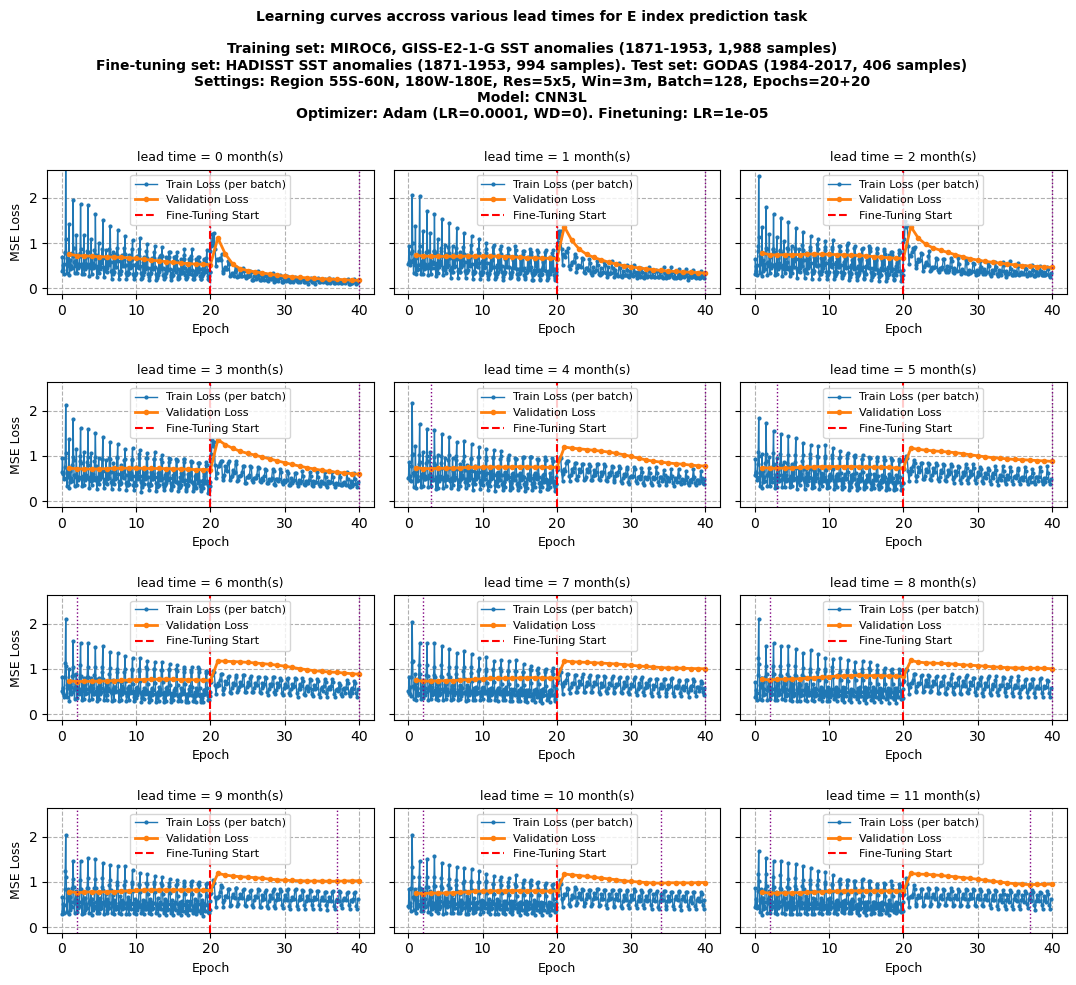

Saved _model_learning_curves_batch_combined_CNN3L_Train_MIROC6_GISS_Tune_HADISST_1871-1953_Ep20-20_Test_GODAS_1984-2017_Win03_55S-60N-180W-180E_Res5_Adam_EIdx_Lead24.jpg to disk

Epoch learning curves:


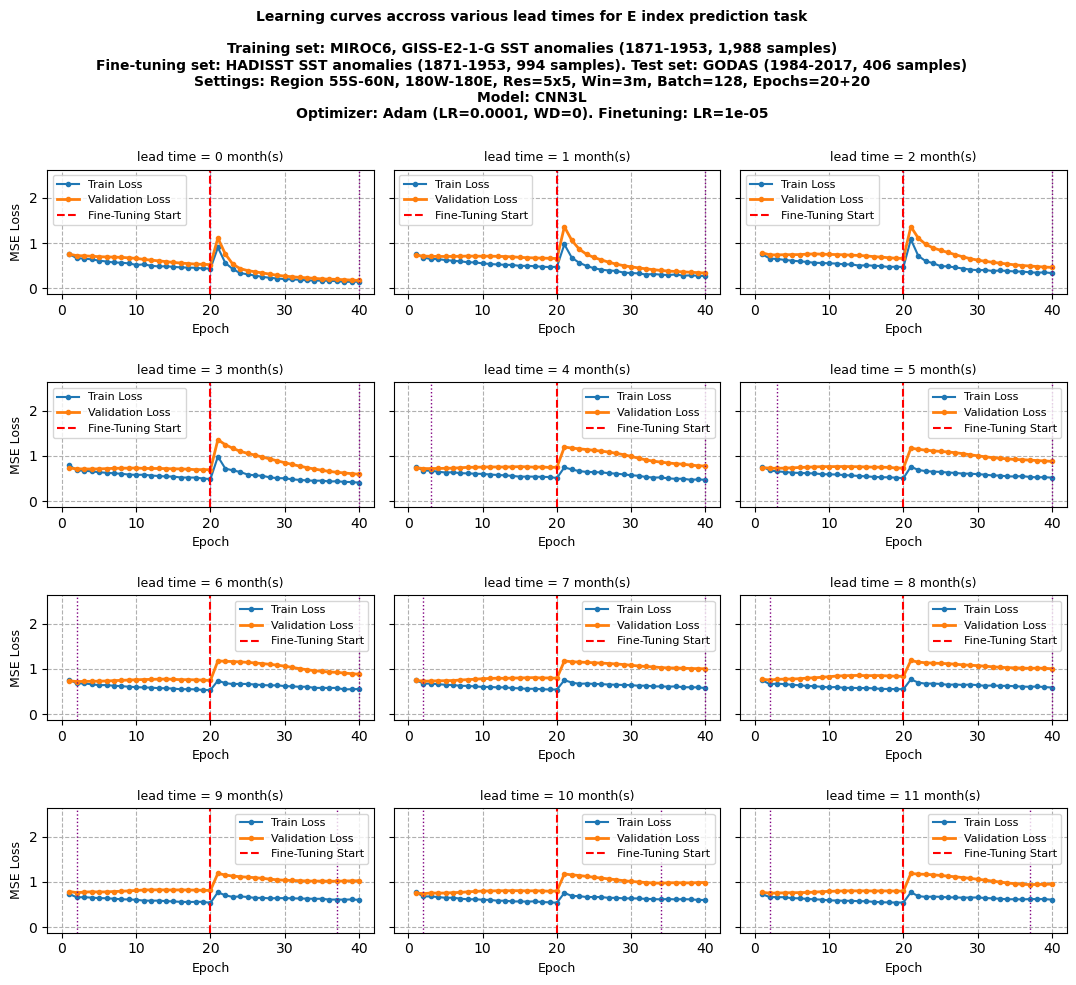

Saved _model_learning_curves_epoch_combined_CNN3L_Train_MIROC6_GISS_Tune_HADISST_1871-1953_Ep20-20_Test_GODAS_1984-2017_Win03_55S-60N-180W-180E_Res5_Adam_EIdx_Lead24.jpg to disk


Target: C index

Batch learning curves:
480


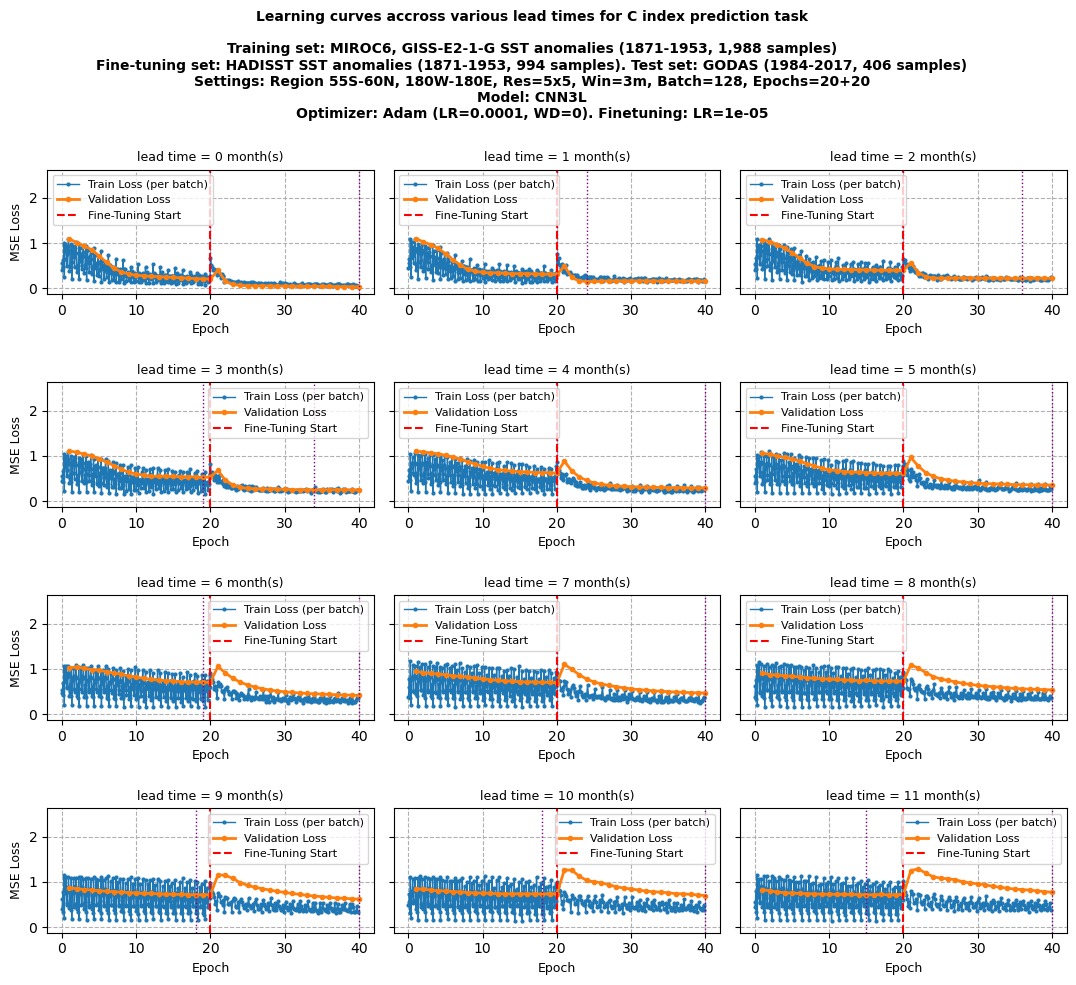

Saved _model_learning_curves_batch_combined_CNN3L_Train_MIROC6_GISS_Tune_HADISST_1871-1953_Ep20-20_Test_GODAS_1984-2017_Win03_55S-60N-180W-180E_Res5_Adam_CIdx_Lead24.jpg to disk

Epoch learning curves:


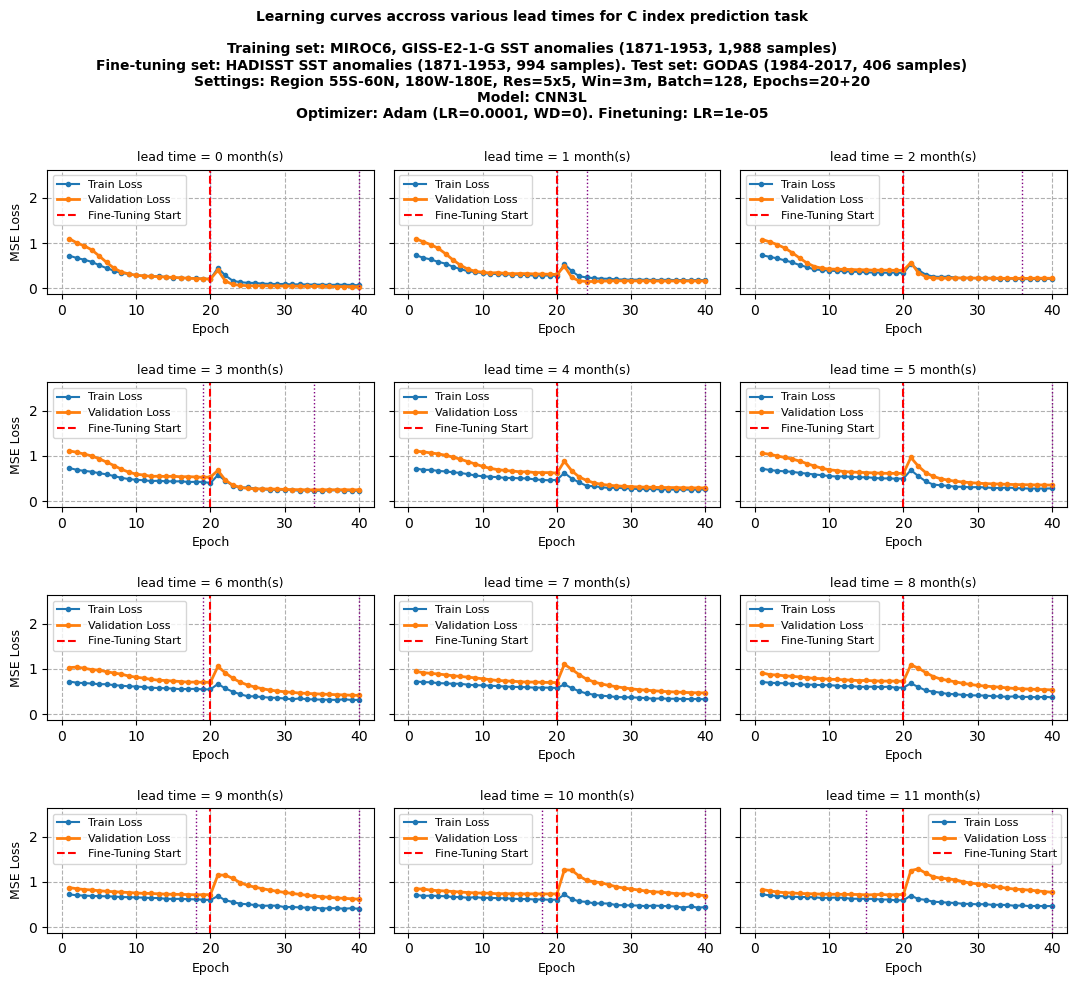

Saved _model_learning_curves_epoch_combined_CNN3L_Train_MIROC6_GISS_Tune_HADISST_1871-1953_Ep20-20_Test_GODAS_1984-2017_Win03_55S-60N-180W-180E_Res5_Adam_CIdx_Lead24.jpg to disk


In [55]:
# # Training Curves
# ROWS_TO_SHOW = 4
# for target in TARGETS:
#     filename = f"_model_learning_curves_batch_{experiment_name}.jpg"
#     graph_utils.plot_learning_curves_finetune(cnn_training_results, target, num_epochs=NUM_EPOCHS_TRAIN, train_loss_display="batch", rows_to_show=ROWS_TO_SHOW, 
#                                      subtitle=cnn_subtitle, save_img=SAVE_PLOTS_TO_DISK, img_filename=filename, img_folder=IMG_FOLDER)

#     filename = f"_model_learning_curves_epoch_{experiment_name}.jpg"
#     graph_utils.plot_learning_curves_finetune(cnn_training_results, target, num_epochs=NUM_EPOCHS_TRAIN, train_loss_display="epoch", rows_to_show=ROWS_TO_SHOW, 
#                                      subtitle=cnn_subtitle, save_img=SAVE_PLOTS_TO_DISK, img_filename=filename, img_folder=IMG_FOLDER)

# # Finetuning Curves
# ROWS_TO_SHOW = 4
# for target in TARGETS:
#     filename = f"_model_learning_curves_batch_{experiment_name}.jpg"
#     graph_utils.plot_learning_curves_finetune(cnn_finetuning_results, target, num_epochs=NUM_EPOCHS_FINETUNE, train_loss_display="batch", rows_to_show=ROWS_TO_SHOW, 
#                                      subtitle=cnn_subtitle, save_img=SAVE_PLOTS_TO_DISK, img_filename=filename, img_folder=IMG_FOLDER)

#     filename = f"_model_learning_curves_epoch_{experiment_name}.jpg"
#     graph_utils.plot_learning_curves_finetune(cnn_finetuning_results, target, num_epochs=NUM_EPOCHS_FINETUNE, train_loss_display="epoch", rows_to_show=ROWS_TO_SHOW, 
#                                      subtitle=cnn_subtitle, save_img=SAVE_PLOTS_TO_DISK, img_filename=filename, img_folder=IMG_FOLDER)

# Combined Curves
ROWS_TO_SHOW = 4
for target in TARGETS:
    print(f"\n\n================================================================================================================================================================")
    print(f"Target: {target} index")

    # Batch learning curves
    print(f"\nBatch learning curves:")    
    # print(cnn_results[target][-1]['train_num_epochs'])
    # print(cnn_results[target][-1]['tune_num_epochs'])
    print(len(cnn_results[target][-1]['combined_loss_history']))
    
    filename = f"_model_learning_curves_batch_{cnn_results[target][-1]['experiment_name']}.jpg"
    graph_utils.plot_learning_curves_finetune(cnn_results, target, num_epochs=NUM_EPOCHS_TRAIN+NUM_EPOCHS_FINETUNE, train_loss_display="batch", rows_to_show=ROWS_TO_SHOW, 
                                     subtitle=cnn_subtitle, save_img=SAVE_PLOTS_TO_DISK, img_filename=filename, img_folder=IMG_FOLDER)


    # Epoch learning curves
    print(f"\nEpoch learning curves:")    
    filename = f"_model_learning_curves_epoch_{cnn_results[target][-1]['experiment_name']}.jpg"
    graph_utils.plot_learning_curves_finetune(cnn_results, target, num_epochs=NUM_EPOCHS_TRAIN+NUM_EPOCHS_FINETUNE, train_loss_display="epoch", rows_to_show=ROWS_TO_SHOW, 
                                     subtitle=cnn_subtitle, save_img=SAVE_PLOTS_TO_DISK, img_filename=filename, img_folder=IMG_FOLDER)

### Plot Predicted vs True Index

In [56]:
# get maximum abs value and use it for y_min and y_max
v_min, v_max = np.inf, -np.inf
for target in TARGETS:
    for cnn_dict in cnn_finetuning_results[target]:
        v_min = min(v_min, cnn_dict['predictions'].min(), cnn_dict['y_test'].min())
        v_max = max(v_max, cnn_dict['predictions'].max(), cnn_dict['y_test'].max())
        abs_v_max = max(abs(v_min), abs(v_max))

# add 1 to get a little margin
abs_v_max = abs_v_max + 1
print(f"Maximum Absolute Value +1 for actual and predicted {TARGETS} target(s): {abs_v_max:.2f}")

Maximum Absolute Value +1 for actual and predicted ['E', 'C'] target(s): 5.25


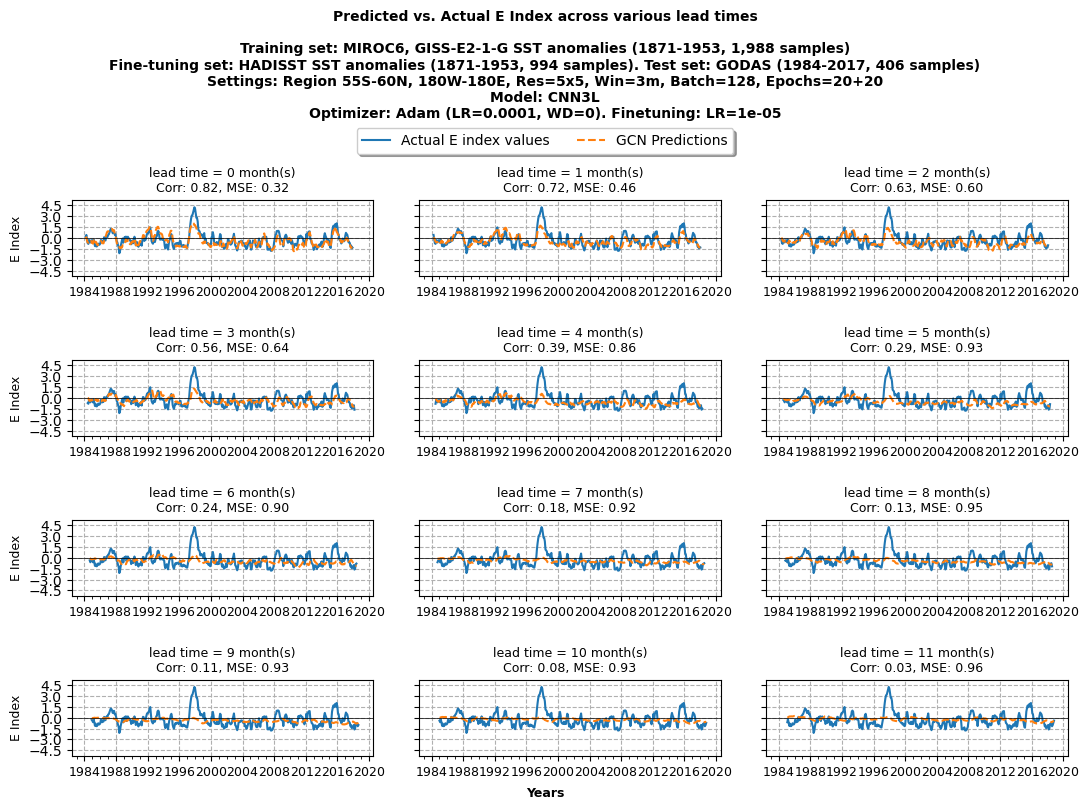

Saved _model_pred_true_timeseries_tune_CNN3L_Train_MIROC6_GISS_Tune_HADISST_1871-1953_Ep20-20_Test_GODAS_1984-2017_Win03_55S-60N-180W-180E_Res5_Adam_EIdx_Lead24.jpg to disk


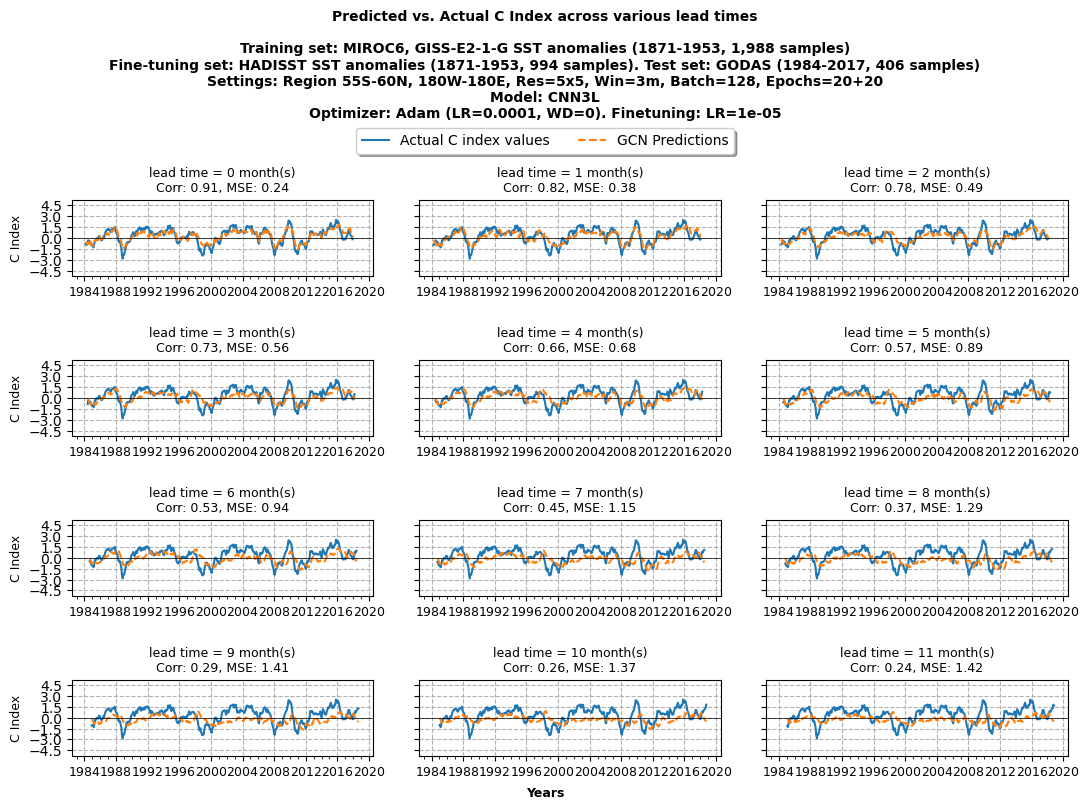

Saved _model_pred_true_timeseries_tune_CNN3L_Train_MIROC6_GISS_Tune_HADISST_1871-1953_Ep20-20_Test_GODAS_1984-2017_Win03_55S-60N-180W-180E_Res5_Adam_CIdx_Lead24.jpg to disk


In [57]:
for target in TARGETS:
    filename = f"_model_pred_true_timeseries_{cnn_finetuning_results[target][-1]['experiment_name']}.jpg"
    graph_utils.plot_pred_vs_actual_timeseries(cnn_finetuning_results, target, abs_v_max, rows_to_show=ROWS_TO_SHOW, 
                                               subtitle=cnn_subtitle, save_img=SAVE_PLOTS_TO_DISK, img_filename=filename, img_folder=IMG_FOLDER)

### Compare with other models

#### Load corresponding results from PF, LR, RR

In [58]:
# persist_model_results, lin_reg_results, ridge_reg_results, cnn_results, gnn_results = {}, {}, {}, {}, {}
persist_model_results, lin_reg_results, ridge_reg_results = {}, {}, {}

for target in TARGETS:

    if target == "oni":
        results_folder = RESULTS_ONI_FOLDER
    elif target == "nino34":
        results_folder = RESULTS_NINO34_FOLDER
    elif target == "E":
        results_folder = RESULTS_EC_FOLDER
        target = 'E'
    elif target == "C":
        results_folder = RESULTS_EC_FOLDER
        target = 'C'
    else:
        print(f"Unknown target {target}. Abort")
    

    
    print(f"\nLoad model results for target {target} from {results_folder}")

    # search_term = f"{TEST_SOURCE_ID}_{target.capitalize()}"
    # print("search_term: ", search_term)

    search_term = (
        f"Train_{FINETUNE_SOURCE_IDS_STR}_"
        f"{train_start_year}-{train_end_year}_"
        f"Test_{TEST_SOURCE_ID_FILENAME}_"
        f"{test_start_year}-{test_end_year}_"
        f"Win{INPUT_TIME_STEPS:02d}_"
        f"{utils.add_cardinals_fname(MIN_LAT, MAX_LAT, MIN_LON, MAX_LON)}_"
        f"Res{RESOLUTION}_"
        f"{target.capitalize()}Idx"
    )
    print("search_term: ", search_term)
    
    # Load persistent forecast results as pickle file
    folder = os.path.join(results_folder, "pf")
    filename, filepath = graph_utils.find_file(folder, search_term, file_extension='.pkl')
    with open(filepath, "rb") as file:
        persist_model_results[target] = pickle.load(file)
        print(f"• PF: {filepath}")


    # search_term = (
    #     f"Train_{TRAIN_SOURCE_IDS_FILENAME}_"
    #     f"{utils.add_cardinals_fname(MIN_LAT, MAX_LAT, MIN_LON, MAX_LON)}_"
    #     f"{target.capitalize()}Idx_")
    

    # Load Linear Regression results as pickle file
    folder = os.path.join(results_folder, "lr")
    filename, filepath = graph_utils.find_file(folder, search_term, file_extension='.pkl')
    with open(filepath, "rb") as file:
        lin_reg_results[target] = pickle.load(file)
        print(f"• LR: {filepath}")
                        
    # Load Ridge Regression results as pickle file
    folder = os.path.join(results_folder, "rr")
    filename, filepath = graph_utils.find_file(folder, search_term, file_extension='.pkl')
    with open(filepath, "rb") as file:
        ridge_reg_results[target] = pickle.load(file)
        print(f"• RR: {filepath}")


    # Load GNN results as pickle file
    # folder = os.path.join(results_folder, "gnn")
    # print(folder)
    # filename, filepath = graph_utils.find_file(folder, search_term, file_extension='.pkl')
    # with open(filepath, "rb") as file:
    #     gnn_results[target] = pickle.load(file)
    #     print(f"• GNN: {filepath}")


Load model results for target E from saved_results/ec
search_term:  Train_HADISST_1871-1953_Test_GODAS_1984-2017_Win03_55S-60N-180W-180E_Res5_EIdx
• PF: saved_results/ec/pf/results_PF_Train_HADISST_1871-1953_Test_GODAS_1984-2017_Win03_55S-60N-180W-180E_Res5_EIdx.pkl
• LR: saved_results/ec/lr/results_LR_Train_HADISST_1871-1953_Test_GODAS_1984-2017_Win03_55S-60N-180W-180E_Res5_EIdx.pkl
• RR: saved_results/ec/rr/results_RR_Train_HADISST_1871-1953_Test_GODAS_1984-2017_Win03_55S-60N-180W-180E_Res5_EIdx.pkl

Load model results for target C from saved_results/ec
search_term:  Train_HADISST_1871-1953_Test_GODAS_1984-2017_Win03_55S-60N-180W-180E_Res5_CIdx
• PF: saved_results/ec/pf/results_PF_Train_HADISST_1871-1953_Test_GODAS_1984-2017_Win03_55S-60N-180W-180E_Res5_CIdx.pkl
• LR: saved_results/ec/lr/results_LR_Train_HADISST_1871-1953_Test_GODAS_1984-2017_Win03_55S-60N-180W-180E_Res5_CIdx.pkl
• RR: saved_results/ec/rr/results_RR_Train_HADISST_1871-1953_Test_GODAS_1984-2017_Win03_55S-60N-180W-180

In [59]:
# extract correlations and mses
pf_correlations, lr_correlations, rr_correlations, cnn_correlations, gnn_correlations = {}, {}, {}, {}, {}
pf_mses, lr_mses, rr_mses, cnn_mses, gnn_mses = {}, {}, {}, {}, {}
max_mses_pf_rr = 0

for target in TARGETS:
    
    pf_correlations[target] = [pf_dict['corr'] for pf_dict in persist_model_results[target]]
    lr_correlations[target] = [lr_dict['corr'] for lr_dict in lin_reg_results[target]]
    rr_correlations[target] = [rr_dict['corr'] for rr_dict in ridge_reg_results[target]]
    cnn_correlations[target] = [cnn_dict['corr'] for cnn_dict in cnn_finetuning_results[target]]
    # gnn_correlations[target] = [gnn_dict['corr'] for gnn_dict in gnn_finetuning_results[target]]

    pf_mses[target] = [pf_dict['mse'] for pf_dict in persist_model_results[target]]
    lr_mses[target] = [lr_dict['mse'] for lr_dict in lin_reg_results[target]]
    rr_mses[target] = [rr_dict['mse'] for rr_dict in ridge_reg_results[target]]
    cnn_mses[target] = [cnn_dict['mse'] for cnn_dict in cnn_finetuning_results[target]]
    # gnn_mses[target] = [gnn_dict['mse'] for gnn_dict in gnn_finetuning_results[target]]

    # get the max value of pf and rr across targets to make the plots consistent
    max_mses_pf_rr = np.max((max_mses_pf_rr, np.max(pf_mses[target] + rr_mses[target])))
max_mses_pf_rr

2.5509917736053467

In [60]:
# cnn_results[target]

#### Compare time series predictions

Target: E index


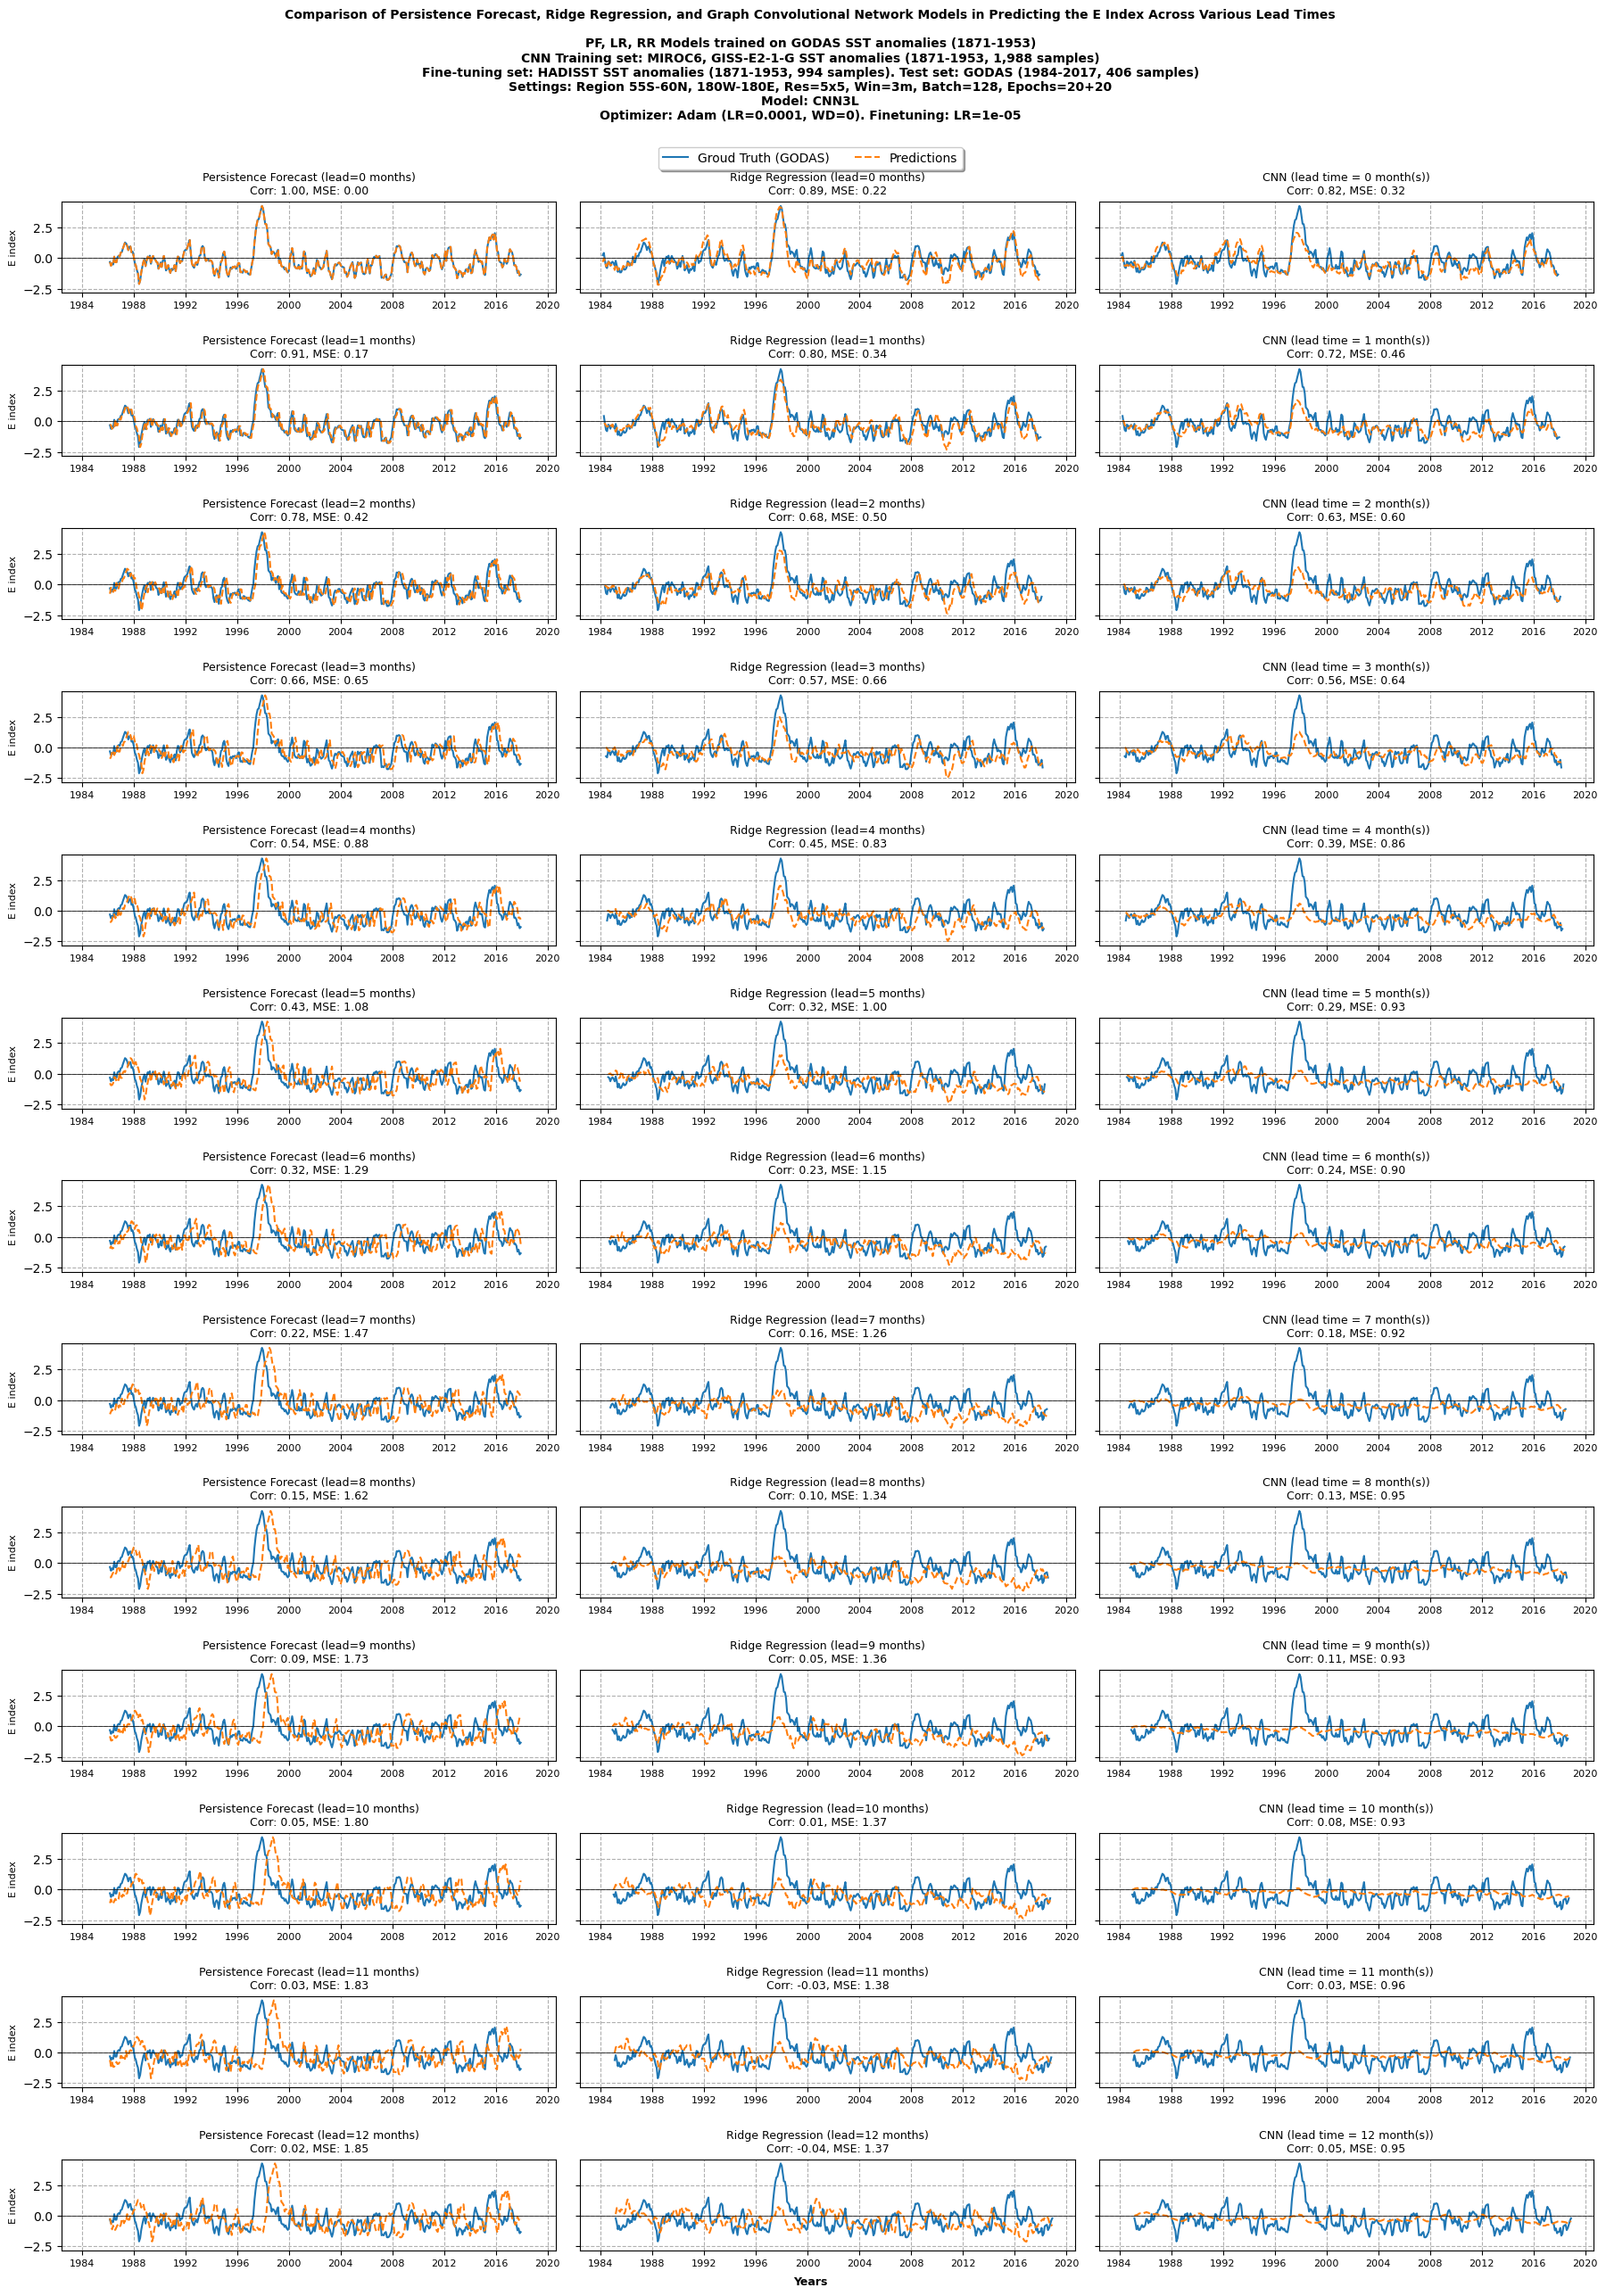

Saved _model_compare_pred_true_timeseries_tune_CNN3L_Train_MIROC6_GISS_Tune_HADISST_1871-1953_Ep20-20_Test_GODAS_1984-2017_Win03_55S-60N-180W-180E_Res5_Adam_EIdx_Lead24.jpg to disk





Target: C index


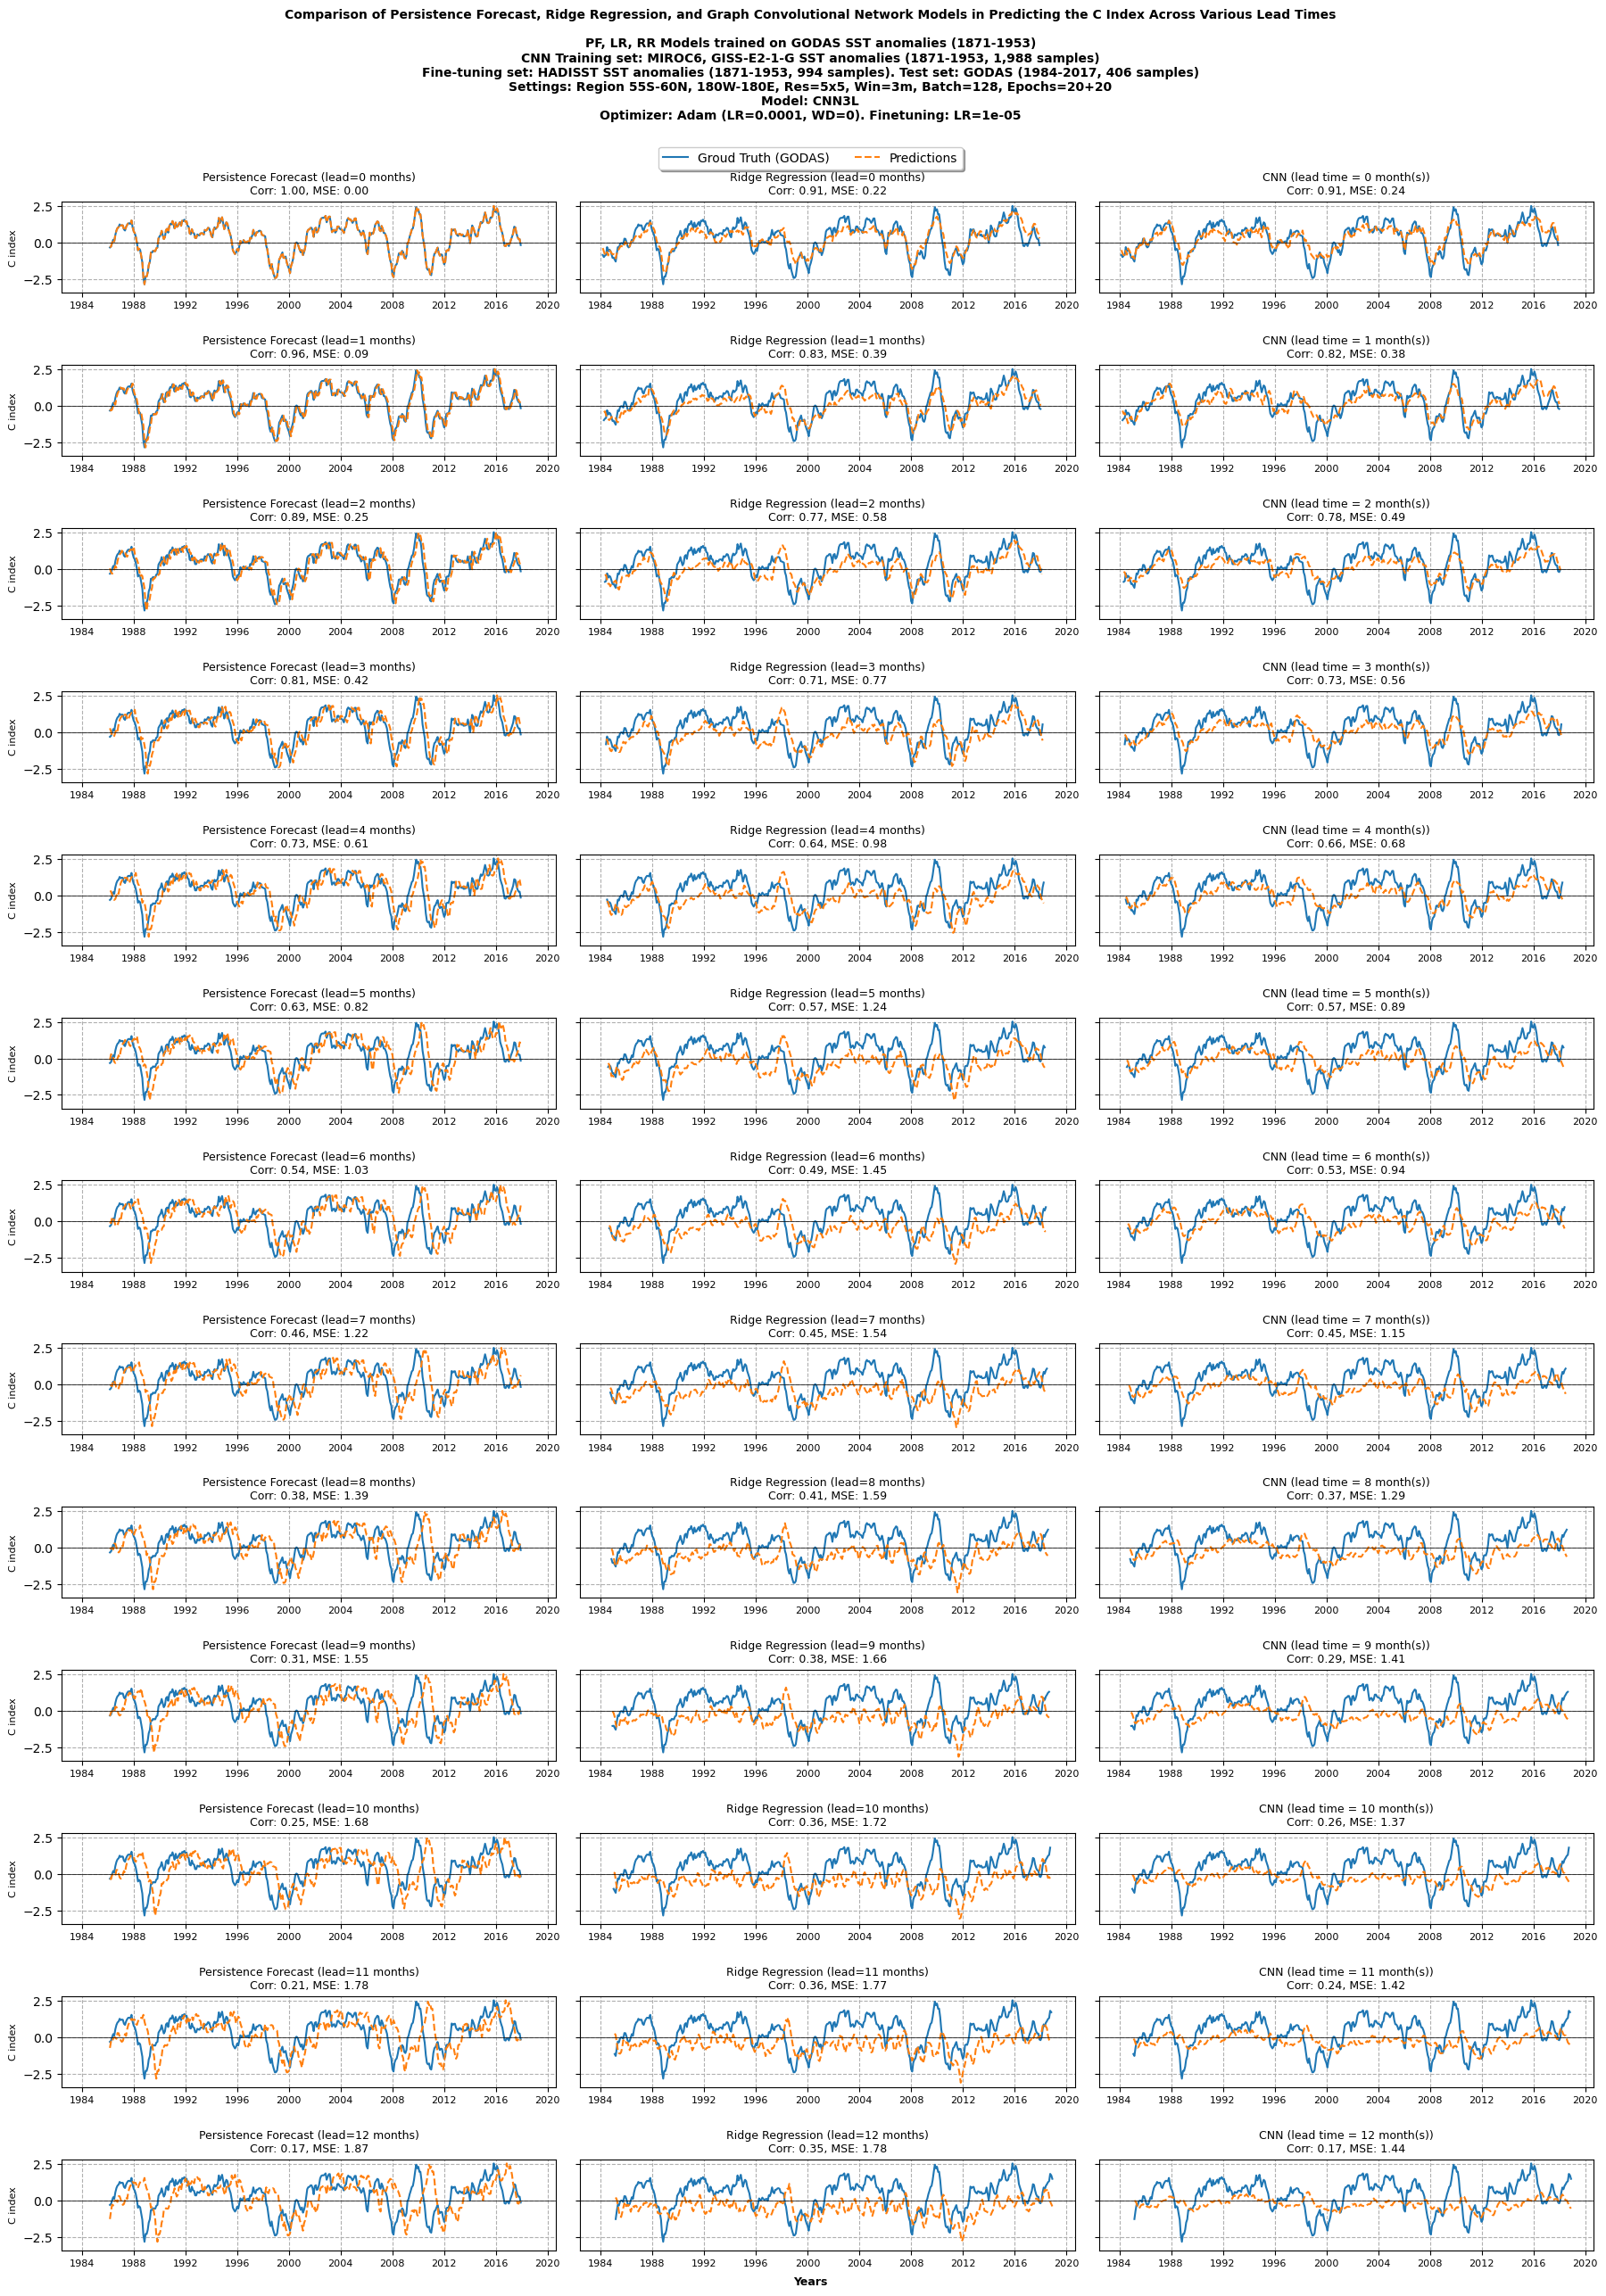

Saved _model_compare_pred_true_timeseries_tune_CNN3L_Train_MIROC6_GISS_Tune_HADISST_1871-1953_Ep20-20_Test_GODAS_1984-2017_Win03_55S-60N-180W-180E_Res5_Adam_CIdx_Lead24.jpg to disk







In [61]:
NUM_ROWS = 13
for target in TARGETS:
    print(f"Target: {target} index")
    nrows = min(len(lin_reg_results[target]), NUM_ROWS)
    # fig, axs = plt.subplots(nrows=nrows, ncols=5, figsize=(18, NUM_ROWS*2), sharex=True, sharey=True)
    # fig, axs = plt.subplots(nrows=nrows, ncols=4, figsize=(18, NUM_ROWS*2), sharex=True, sharey=True)
    fig, axs = plt.subplots(nrows=nrows, ncols=3, figsize=(18, NUM_ROWS*2), sharex=True, sharey=True)
    
    # for (pf_dict, lr_dict, rr_dict, cnn_dict, gnn_dict), (ax1, ax2, ax3, ax4, ax5) in zip(zip(persist_model_results[target], lin_reg_results[target], ridge_reg_results[target], cnn_results[target], gnn_finetuning_results[target]), axs):
    # for (pf_dict, lr_dict, rr_dict, gnn_dict), (ax1, ax2, ax3, ax5) in zip(zip(persist_model_results[target], lin_reg_results[target], ridge_reg_results[target], gnn_finetuning_results[target]), axs):
    for (pf_dict, rr_dict, cnn_dict), (ax1, ax3, ax4) in zip(zip(persist_model_results[target], ridge_reg_results[target], cnn_finetuning_results[target]), axs):
    
        
        ######## PERSISTENCE FORECASTS ########
        
        # Align timestamps of predictions and actual values
        pf_predictions = pd.Series(pf_dict['predictions'], index=pf_dict['y_test'].index)
        pf_predictions = pf_predictions.sort_index()
        y_test = pf_dict['y_test'].sort_index()
    
        # Plot machine learning predictions and actual values on the same plot
        ax1.plot(y_test, label=f'Groud Truth ({TEST_SOURCE_ID})')
        ax1.plot(pf_predictions, '--', label='PF Predictions')
        
        ax1.set_title(f"Persistence Forecast (lead={pf_dict['lead_time']} months)\nCorr: {pf_dict['corr']:.2f}, MSE: {pf_dict['mse']:.2f}", fontsize=9)
        ax1.xaxis.set_major_locator(mdates.YearLocator(base=4))  # base=4 for every four year    
        ax1.tick_params(axis='x', which='both', labelbottom=True, labelsize=8) # ensure the x-axis labels are visible for each subplot
        ax1.grid(linestyle='dashed')
        ax1.set_ylabel(f'{target} index', fontsize=8) # Set the y-label for the leftmost subplot in each row
        ax1.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
        handles, labels = ax1.get_legend_handles_labels()
    
        
        ######## LINEAR REGRESSION ########
        
        # # Align timestamps of predictions and actual values
        # lr_predictions = pd.Series(lr_dict['predictions'], index=lr_dict['y_test'].index)
        # lr_predictions = lr_predictions.sort_index()
        # y_test = lr_dict['y_test'].sort_index()
    
        # # Plot machine learning predictions and actual values on the same plot
        # ax2.plot(y_test, label=f'Groud Truth ({TEST_SOURCE_ID})')
        # ax2.plot(lr_predictions, '--', label='LR Predictions')
        
        # ax2.set_title(f"Linear Regression (lead={lr_dict['lead_time']} months)\nCorr: {lr_dict['corr']:.2f}, MSE: {lr_dict['mse']:.2f}", fontsize=9)
        # ax2.xaxis.set_major_locator(mdates.YearLocator(base=4))  # base=4 for every four year    
        # ax2.tick_params(axis='x', which='both', labelbottom=True, labelsize=8) # ensure the x-axis labels are visible for each subplot
        # ax2.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
        # ax2.grid(linestyle='dashed')
        # handles, labels = ax2.get_legend_handles_labels()
    
        
        ######## RIDGE REGRESSION ########
        
        # Align timestamps of predictions and actual values
        rr_predictions = pd.Series(rr_dict['predictions'], index=rr_dict['y_test'].index)
        rr_predictions = rr_predictions.sort_index()
        y_test = rr_dict['y_test'].sort_index()
    
        # Plot machine learning predictions and actual values on the same plot
        ax3.plot(y_test, label=f'Groud Truth ({TEST_SOURCE_ID})')
        ax3.plot(rr_predictions, '--', label='RR Predictions')
        
        ax3.set_title(f"Ridge Regression (lead={rr_dict['lead_time']} months)\nCorr: {rr_dict['corr']:.2f}, MSE: {rr_dict['mse']:.2f}", fontsize=9)
        ax3.xaxis.set_major_locator(mdates.YearLocator(base=4))  # base=4 for every four year    
        ax3.tick_params(axis='x', which='both', labelbottom=True, labelsize=8) # ensure the x-axis labels are visible for each subplot
        ax3.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
        ax3.grid(linestyle='dashed')
        handles, labels = ax3.get_legend_handles_labels()

        
        # ######## CNN REGRESSION ########
        # Align timestamps of predictions and actual values
        cnn_predictions = pd.Series(cnn_dict['predictions'], index=cnn_dict['y_test'].index)
        cnn_predictions = cnn_predictions.sort_index()
        y_test = cnn_dict['y_test'].sort_index(ascending=True)
        
        # Plot machine learning predictions and actual values on the same plot
        ax4.plot(y_test, label=f'Groud Truth ({TEST_SOURCE_ID})')
        ax4.plot(cnn_predictions, '--', label='CNN Predictions')

        ax4.set_title(f"CNN (lead time = {cnn_dict['lead_time']} month(s))\nCorr: {cnn_dict['corr']:.2f}, MSE: {cnn_dict['mse']:.2f}", fontsize=9)
        ax4.xaxis.set_major_locator(mdates.YearLocator(base=4))  # base=2 for every other year    
        # ax4.xaxis.set_minor_locator(mdates.YearLocator(base=1))  # base=2 for every other year    
        ax4.tick_params(axis='x', which='both', labelbottom=True, labelsize=8) # ensure the x-axis labels are visible for each subplot
        ax4.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
        ax4.grid(linestyle='dashed')
        handles, labels = ax4.get_legend_handles_labels()

        
        
        
        ######## GNN REGRESSION ########
        # Align timestamps of predictions and actual values
        # gnn_predictions = pd.Series(gnn_dict['predictions'], index=gnn_dict['y_test'].index)
        # gnn_predictions = gnn_predictions.sort_index()
        # y_test = gnn_dict['y_test'].sort_index(ascending=True)
        
        # # Plot machine learning predictions and actual values on the same plot
        # ax5.plot(y_test, label=f"Groud Truth ({gnn_dict['test_source_id']})")
        # ax5.plot(gnn_predictions, '--', label='GCN Predictions')

        # ax5.set_title(f"GNN (lead time = {gnn_dict['lead_time']} month(s))\nCorr: {gnn_dict['corr']:.2f}, MSE: {gnn_dict['mse']:.2f}", fontsize=9)
        # ax5.xaxis.set_major_locator(mdates.YearLocator(base=4))  # base=2 for every other year    
        # # ax5.xaxis.set_minor_locator(mdates.YearLocator(base=1))  # base=2 for every other year    
        # ax5.tick_params(axis='x', which='both', labelbottom=True, labelsize=8) # ensure the x-axis labels are visible for each subplot
        # ax5.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
        # ax5.grid(linestyle='dashed')
        # handles, labels = ax5.get_legend_handles_labels()


    
    
    # fig.legend(handles, [labels[0], labels[1]], loc='upper center', bbox_to_anchor=(0.5, 0.964), ncol=2, shadow=True)
    fig.legend(handles, [labels[0], "Predictions"], loc='upper center', bbox_to_anchor=(0.5, 0.923), ncol=2, shadow=True)
    # fig.suptitle(f'Predicted and True {target} Indices Across Various Lead Times\n(Models trained on {TEST_SOURCE_ID} data ({utils.add_cardinals_fname(MIN_LAT, MAX_LAT, MIN_LON, MAX_LON)}) from {train_start_year} to {train_end_year})', fontsize=10, fontweight="bold")
    fig.suptitle(f'Comparison of Persistence Forecast, Ridge Regression, and Graph Convolutional Network Models in Predicting the {target.capitalize()} Index Across Various Lead Times\n\n'
                 f'PF, LR, RR Models trained on {TEST_SOURCE_ID} SST anomalies ({train_start_year}-{train_end_year})\n'
                 f'CNN {cnn_subtitle}', fontsize=10, fontweight="bold")
    fig.text(0.5, 0.0, 'Years', ha='center', va='center', fontsize=9, fontweight="bold")
    # fig.text(0.00, 0.5,  f'{target} index', ha='center', va='center', rotation='vertical', fontsize=9, fontweight="bold")
    fig.tight_layout(h_pad=2, w_pad=None, rect=[0, 0, 1, 0.97]) # (left, bottom, right, top), default: (0, 0, 1, 1)
    plt.show()

    
    if SAVE_PLOTS_TO_DISK == True:
        filename = f"_model_compare_pred_true_timeseries_{cnn_finetuning_results[target][-1]['experiment_name']}.jpg"
        fig.savefig(IMG_FOLDER+filename, dpi=300, bbox_inches='tight')
        print(f"Saved {filename} to disk")
    plt.show()
    print("\n\n\n\n==========================================================================================================================================================================\n")

#### Plot correlations and MSE across lead times

Target: E index


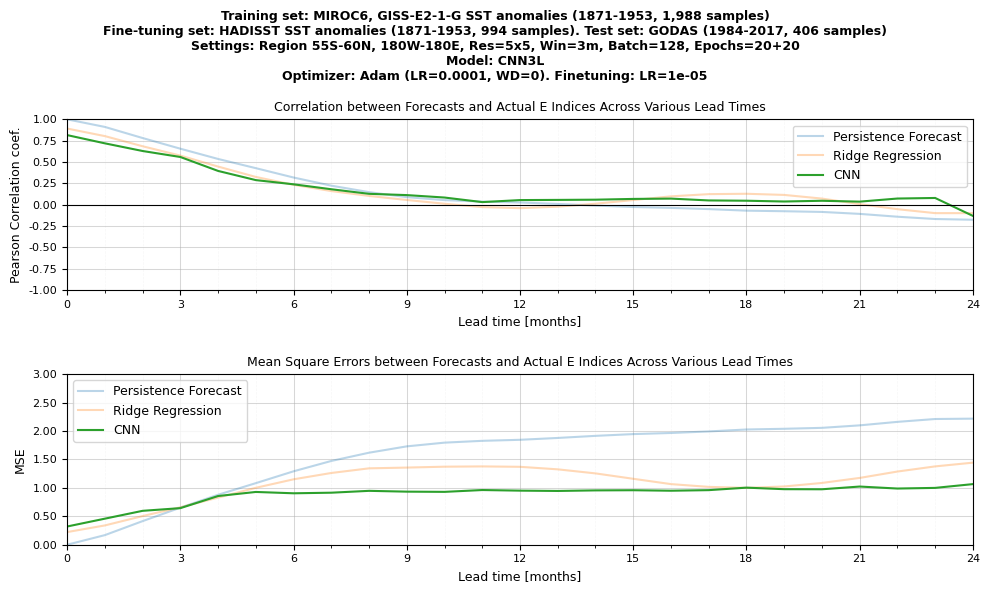

Saved _model_corr_mse_tune_CNN3L_Train_MIROC6_GISS_Tune_HADISST_1871-1953_Ep20-20_Test_GODAS_1984-2017_Win03_55S-60N-180W-180E_Res5_Adam_EIdx_Lead24.jpg to disk





Target: C index


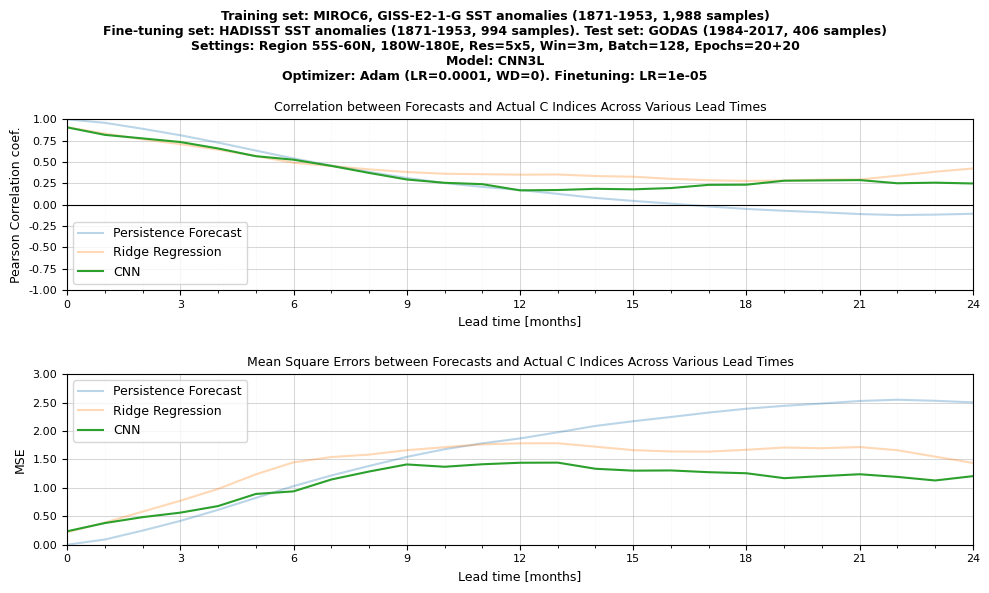

Saved _model_corr_mse_tune_CNN3L_Train_MIROC6_GISS_Tune_HADISST_1871-1953_Ep20-20_Test_GODAS_1984-2017_Win03_55S-60N-180W-180E_Res5_Adam_CIdx_Lead24.jpg to disk







In [62]:
for target in TARGETS:
    print(f"Target: {target} index")
    
    # coordinates = utils.add_cardinals_title(MIN_LAT, MAX_LAT, MIN_LON, MAX_LON)
    fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(10, 6))
    subtitle = cnn_subtitle
    
    for i, ax in enumerate(axs.flat):
        if i == 0:
            ax.plot(range(0, len(pf_correlations[target])), pf_correlations[target], label="Persistence Forecast", alpha=0.3)        
            # ax.plot(range(0, len(lr_correlations[target])), lr_correlations[target], label="Linear Regression", alpha=0.3)        
            ax.plot(range(0, len(rr_correlations[target])), rr_correlations[target], label=f"Ridge Regression", alpha=0.3) 
            ax.plot(range(0, len(cnn_correlations[target])), cnn_correlations[target], label="CNN", alpha=1)        
            # ax.plot(range(0, len(gnn_correlations[target])), gnn_correlations[target], label="GNN", c='red')        
            ax.set_ylabel('Pearson Correlation coef.', fontsize=9)
            ax.set_ylim(-1,1)
            ax.axhline(y=0, color='black', linestyle='-', linewidth=0.8)
            ax.set_title(f'Correlation between Forecasts and Actual {target} Indices Across Various Lead Times', fontweight="normal", fontsize=9)
            # ax.set_title(f'Correlation between Forecasts and Actual {target} Indices Across Various Lead Times\n{cnn_subtitle}', fontweight="normal", fontsize=9)
            ax.set_yticks(np.arange(-1.0, 1.25, 0.25)) # from -1.0 to 1.0 in steps of 0.25

    
        if i == 1:
            ax.plot(range(0, len(pf_mses[target])), pf_mses[target], label="Persistence Forecast", alpha=0.3)        
            # ax.plot(range(0, len(lr_mses[target])), lr_mses[target], label="Linear Regression", alpha=0.3)        
            ax.plot(range(0, len(rr_mses[target])), rr_mses[target], label=f"Ridge Regression", alpha=0.3)     
            ax.plot(range(0, len(cnn_mses[target])), cnn_mses[target], label="CNN", alpha=1)        
            # ax.plot(range(0, len(gnn_mses[target])), gnn_mses[target], label="GNN", c='red')        
            ax.set_ylabel('MSE', fontsize=9)
            ax.set_ylim(0,3)
            ax.set_title(f'Mean Square Errors between Forecasts and Actual {target} Indices Across Various Lead Times', fontweight="normal", fontsize=9)

            
            
            # ax.set_title(f'Mean Square Errors between Forecasts and Actual {target} Indices Across Various Lead Times\n{cnn_subtitle}', fontweight="normal", fontsize=9)
            # ax.set_yticks(np.arange(0, 8, 1)) # from -1.0 to 1.0 in steps of 0.25

    

        ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
        ax.set_xlabel('Lead time [months]', fontsize=9)
        # ax.set_xticks(range(0,MAX_LEAD_TIME))
        ax.set_xticks(np.arange(0, MAX_LEAD_TIME*5, 3))
    
        # Set the minor ticks to every month
        ax.set_xticks(np.arange(1, 49), minor=True)
        
        # Turn off minor tick labels
        ax.set_xticklabels([], minor=True)
    
        ax.tick_params(axis='both', which='major', labelsize=8)
        ax.margins(x=0)
    
        ax.grid(which='major', linewidth=0.75, alpha=0.5)
        ax.grid(which='minor', linestyle='--', linewidth=0.5, alpha=0.1)
    
        ax.legend(fontsize=9)
    
    # fig.suptitle(f'{cnn_subtitle}', x=0, horizontalalignment='left', fontsize=9, fontweight="normal")
    fig.suptitle(f'{cnn_subtitle}', fontsize=9, fontweight="bold")
    fig.tight_layout(h_pad=2)
    
    if SAVE_PLOTS_TO_DISK == True:
        filename = f"_model_corr_mse_{cnn_finetuning_results[target][-1]['experiment_name']}.jpg"
        fig.savefig(IMG_FOLDER+filename, dpi=300, bbox_inches='tight')
        
    plt.show()

    if SAVE_PLOTS_TO_DISK == True:
        print(f"Saved {filename} to disk")
    print("\n\n\n\n==========================================================================================================================================================================\n")

In [63]:
correlation_dicts={
    'Persistence Forecast': pf_correlations,
    # 'Linear Regression': lr_correlations,
    'Ridge Regression': rr_correlations,
    'CNN': cnn_correlations,
}
mse_dicts={
    'Persistence Forecast': pf_mses,
    # 'Linear Regression': lr_mses,
    'Ridge Regression': rr_mses,
    'CNN': cnn_mses,
}

# color_list = ['blue', 'orange', 'green', 'red', 'purple']
# color_list = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd'] # matplolib standard colors
color_list = ['#1f77b4', '#2ca02c', '#d62728', '#9467bd'] # matplolib standard colors
linestyle_list=['-', '-', '--', '-', '-']

In [64]:
cnn_subtitle

'Training set: MIROC6, GISS-E2-1-G SST anomalies (1871-1953, 1,988 samples)\nFine-tuning set: HADISST SST anomalies (1871-1953, 994 samples). Test set: GODAS (1984-2017, 406 samples)\nSettings: Region 55S-60N, 180W-180E, Res=5x5, Win=3m, Batch=128, Epochs=20+20\nModel: CNN3L\nOptimizer: Adam (LR=0.0001, WD=0). Finetuning: LR=1e-05'

Target: E index


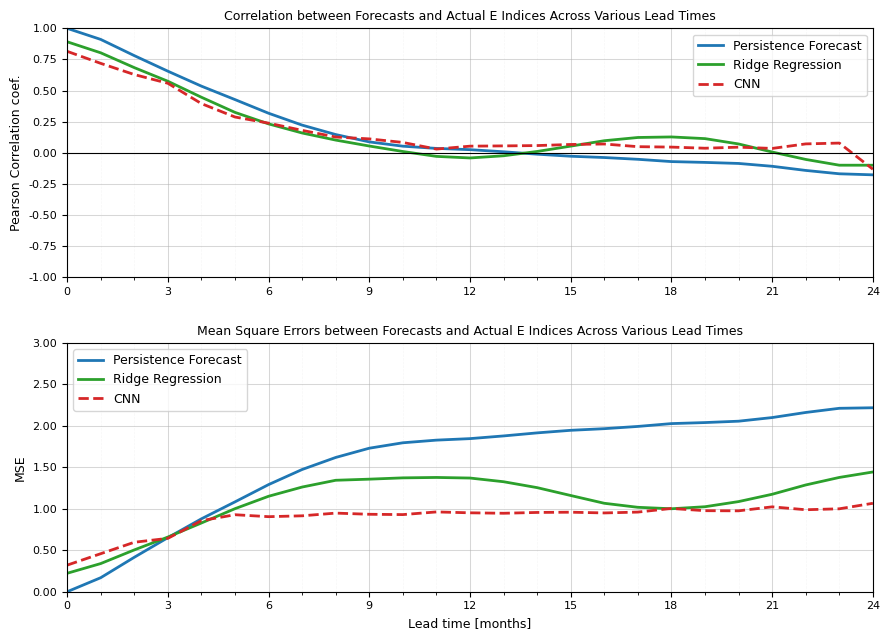

Saved _model_corr_mse_tune_CNN3L_Train_MIROC6_GISS_Tune_HADISST_1871-1953_Ep20-20_Test_GODAS_1984-2017_Win03_55S-60N-180W-180E_Res5_Adam_EIdx_Lead24_no_title.jpg to disk


Target: C index


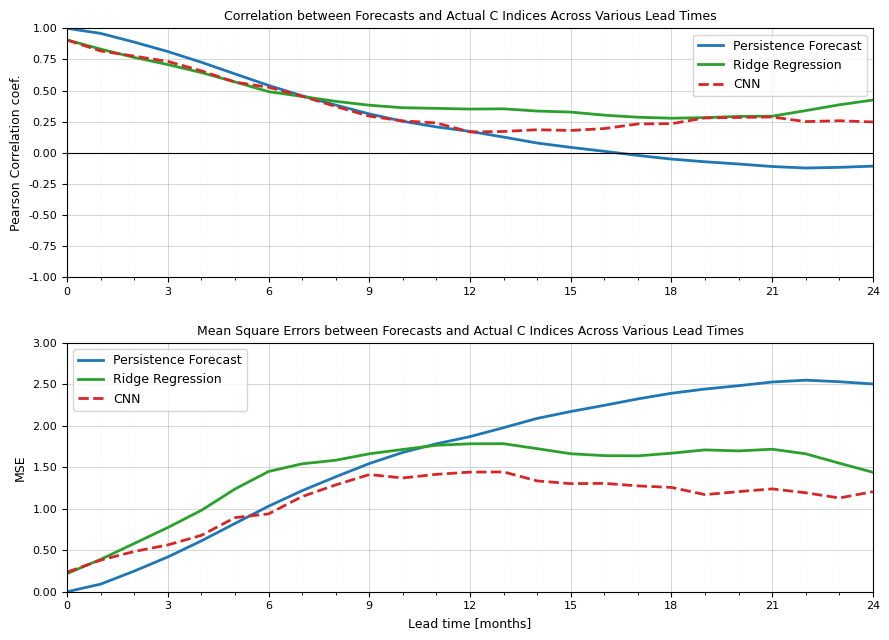

Saved _model_corr_mse_tune_CNN3L_Train_MIROC6_GISS_Tune_HADISST_1871-1953_Ep20-20_Test_GODAS_1984-2017_Win03_55S-60N-180W-180E_Res5_Adam_CIdx_Lead24_no_title.jpg to disk




In [65]:
for target in TARGETS:
    print(f"Target: {target} index")
    # filename = f"_model_corr_mse_{cnn_finetuning_results[target][-1]['experiment_name']}.jpg"
    filename = f"_model_corr_mse_{cnn_finetuning_results[target][-1]['experiment_name']}_no_title.jpg"

    graph_utils.plot_corr_mse(correlation_dicts, mse_dicts, target, MAX_LEAD_TIME, 
                              mse_y_lim_max=3, alpha_list=None, color_list=color_list, linestyle_list=linestyle_list, 
                              suptitle=None, save_img=SAVE_PLOTS_TO_DISK, img_filename=filename, img_folder=IMG_FOLDER)
    print("\n" + "=" * 200 + "\n")

### Ablation Study

In [66]:
experiment_name


'CNN3L_Train_MIROC6_GISS_Tune_HADISST_1871-1953_Ep20-20_Test_GODAS_1984-2017_Win03_55S-60N-180W-180E_Res5_Adam_CIdx_Lead24'

#### Load CNN fine-tuning results from models trained with ALL CMIP data, and only selected ones

In [67]:
experiment_datasources_names = {
    "all_cmip" : "CNN3L_Train_CMIP6_Tune_HADISST_1871-1953_Ep20-20_Test_GODAS_1984-2017_Win03_55S-60N-180W-180E_Res5_Adam",
    "sel_cmip" : "CNN3L_Train_MIROC6_GISS_Tune_HADISST_1871-1953_Ep20-20_Test_GODAS_1984-2017_Win03_55S-60N-180W-180E_Res5_Adam",
}
experiment_datasources_names

{'all_cmip': 'CNN3L_Train_CMIP6_Tune_HADISST_1871-1953_Ep20-20_Test_GODAS_1984-2017_Win03_55S-60N-180W-180E_Res5_Adam',
 'sel_cmip': 'CNN3L_Train_MIROC6_GISS_Tune_HADISST_1871-1953_Ep20-20_Test_GODAS_1984-2017_Win03_55S-60N-180W-180E_Res5_Adam'}

In [68]:
cnn_finetuning_results_by_datasource = {}

In [69]:

for exp_source, exp_general_name in experiment_datasources_names.items():
    print("experience data source: ", exp_source)
    print("experience data source name: ", exp_general_name)
    cnn_finetuning_results = {}

    for target in TARGETS:
        print(f"\n\n-----------------------------------------------------------------------")
        print(f"Target:         {target}")
    
        results_folder = target_to_results_folder.get(target)
        if results_folder is None:
            print(f"Unknown target {target}. Abort")
    
        print(f"\nLoad finetuning model results for target {target} from {results_folder}")
    
        cnn_results_filename = (
            f"results_tune_"
            f"{exp_general_name}_"
            f"{target.capitalize()}Idx"
            f".pkl"
        )
        print("cnn_results_filename: ", cnn_results_filename)
    
        # Load cnn results as pickle file
        folder = os.path.join(results_folder, "cnn")
        # print(folder)
        filename, filepath = graph_utils.find_file(folder, cnn_results_filename)
        with open(filepath, "rb") as file:
            cnn_finetuning_results[target] = pickle.load(file)
            print(f"• cnn finetuning results: {filepath}")
    
    cnn_finetuning_results_by_datasource[exp_source] = cnn_finetuning_results
    print(f"\n\n=================================================================================================================================")


experience data source:  all_cmip
experience data source name:  CNN3L_Train_CMIP6_Tune_HADISST_1871-1953_Ep20-20_Test_GODAS_1984-2017_Win03_55S-60N-180W-180E_Res5_Adam


-----------------------------------------------------------------------
Target:         E

Load finetuning model results for target E from saved_results/ec
cnn_results_filename:  results_tune_CNN3L_Train_CMIP6_Tune_HADISST_1871-1953_Ep20-20_Test_GODAS_1984-2017_Win03_55S-60N-180W-180E_Res5_Adam_EIdx.pkl
• cnn finetuning results: saved_results/ec/cnn/results_tune_CNN3L_Train_CMIP6_Tune_HADISST_1871-1953_Ep20-20_Test_GODAS_1984-2017_Win03_55S-60N-180W-180E_Res5_Adam_EIdx.pkl


-----------------------------------------------------------------------
Target:         C

Load finetuning model results for target C from saved_results/ec
cnn_results_filename:  results_tune_CNN3L_Train_CMIP6_Tune_HADISST_1871-1953_Ep20-20_Test_GODAS_1984-2017_Win03_55S-60N-180W-180E_Res5_Adam_CIdx.pkl
• cnn finetuning results: saved_results/ec/cn

In [70]:
cnn_finetuning_results_by_datasource.keys()

dict_keys(['all_cmip', 'sel_cmip'])

In [71]:
# extract correlations and mses
pf_correlations, lr_correlations, rr_correlations, cnn_correlations, cnn_correlations_all_cmip, cnn_correlations_sel_cmip = {}, {}, {}, {}, {}, {}
pf_mses, lr_mses, rr_mses, cnn_mses, cnn_mses_all_cmip, cnn_mses_sel_cmip = {}, {}, {}, {}, {}, {}
max_mses_pf_rr = 0

for target in TARGETS:
    
    pf_correlations[target] = [pf_dict['corr'] for pf_dict in persist_model_results[target]]
    lr_correlations[target] = [lr_dict['corr'] for lr_dict in lin_reg_results[target]]
    rr_correlations[target] = [rr_dict['corr'] for rr_dict in ridge_reg_results[target]]
    cnn_correlations[target] = [cnn_dict['corr'] for cnn_dict in cnn_finetuning_results[target]]
    cnn_correlations_all_cmip[target] = [cnn_dict['corr'] for cnn_dict in cnn_finetuning_results_by_datasource['all_cmip'][target]]
    cnn_correlations_sel_cmip[target] = [cnn_dict['corr'] for cnn_dict in cnn_finetuning_results_by_datasource['sel_cmip'][target]]
    
    

    pf_mses[target] = [pf_dict['mse'] for pf_dict in persist_model_results[target]]
    lr_mses[target] = [lr_dict['mse'] for lr_dict in lin_reg_results[target]]
    rr_mses[target] = [rr_dict['mse'] for rr_dict in ridge_reg_results[target]]
    cnn_mses[target] = [cnn_dict['mse'] for cnn_dict in cnn_finetuning_results[target]]
    cnn_mses_all_cmip[target] = [cnn_dict['mse'] for cnn_dict in cnn_finetuning_results_by_datasource['all_cmip'][target]]
    cnn_mses_sel_cmip[target] = [cnn_dict['mse'] for cnn_dict in cnn_finetuning_results_by_datasource['sel_cmip'][target]]

    # get the max value of pf and rr across targets to make the plots consistent
    max_mses_pf_rr = np.max((max_mses_pf_rr, np.max(pf_mses[target] + rr_mses[target])))
max_mses_pf_rr

2.5509917736053467

#### Compare time series predictions

In [72]:
model_results_dict = {
    'Persistent Forecast': persist_model_results,
    'Ridge Regr.': ridge_reg_results,
    'CNN': cnn_finetuning_results,
    'CNN (All CMIP)': cnn_finetuning_results_by_datasource['all_cmip'],
    'CNN (Sel CMIP)': cnn_finetuning_results_by_datasource['sel_cmip'],
}


In [73]:
['Persistent Forecast', 'CNN (All CMIP)', 'CNN (Sel CMIP)']

['Persistent Forecast', 'CNN (All CMIP)', 'CNN (Sel CMIP)']

Target: E index
Target: E index


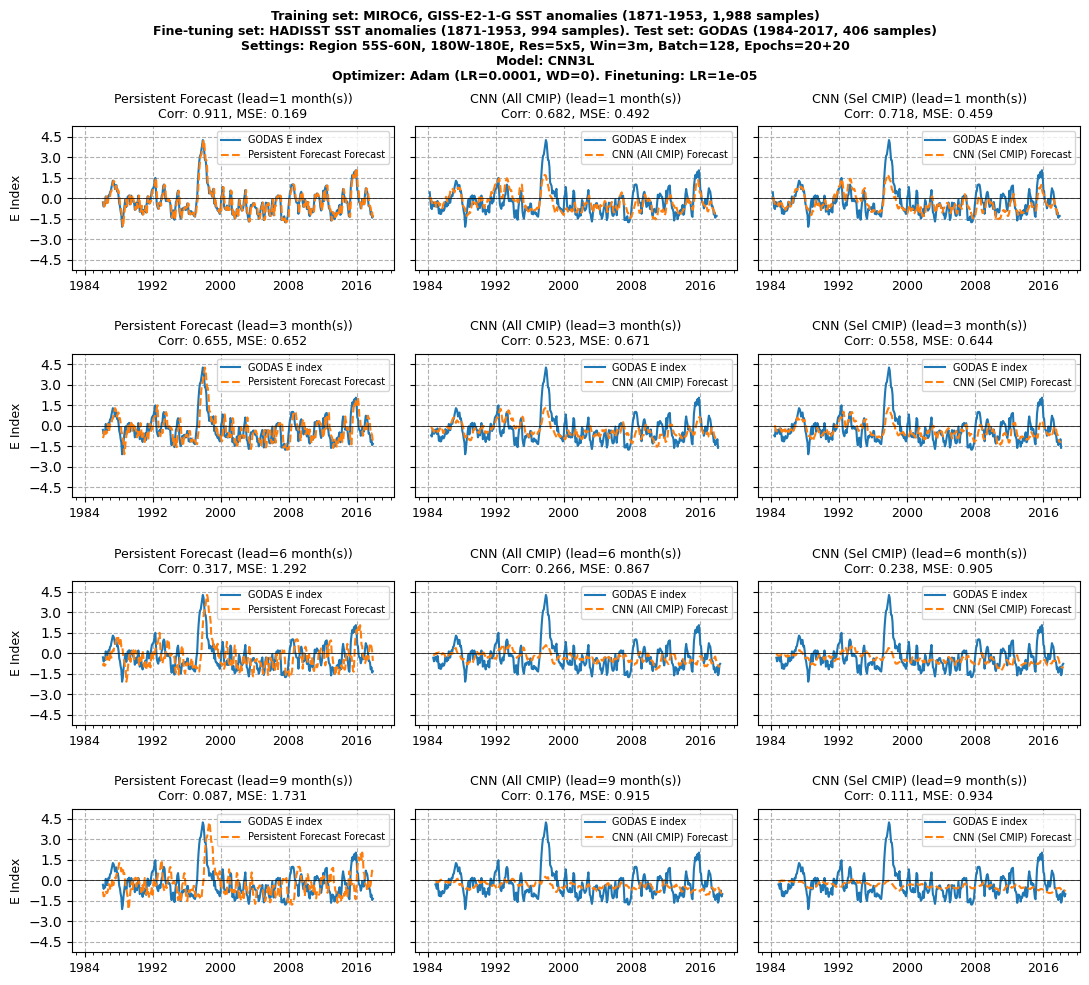

Saved _abl_dset_ts_CNN3L_Train_MIROC6_GISS_Tune_HADISST_1871-1953_Ep20-20_Test_GODAS_Win03_55S-60N_Res5_Adam_E.jpg to disk


Target: C index
Target: C index


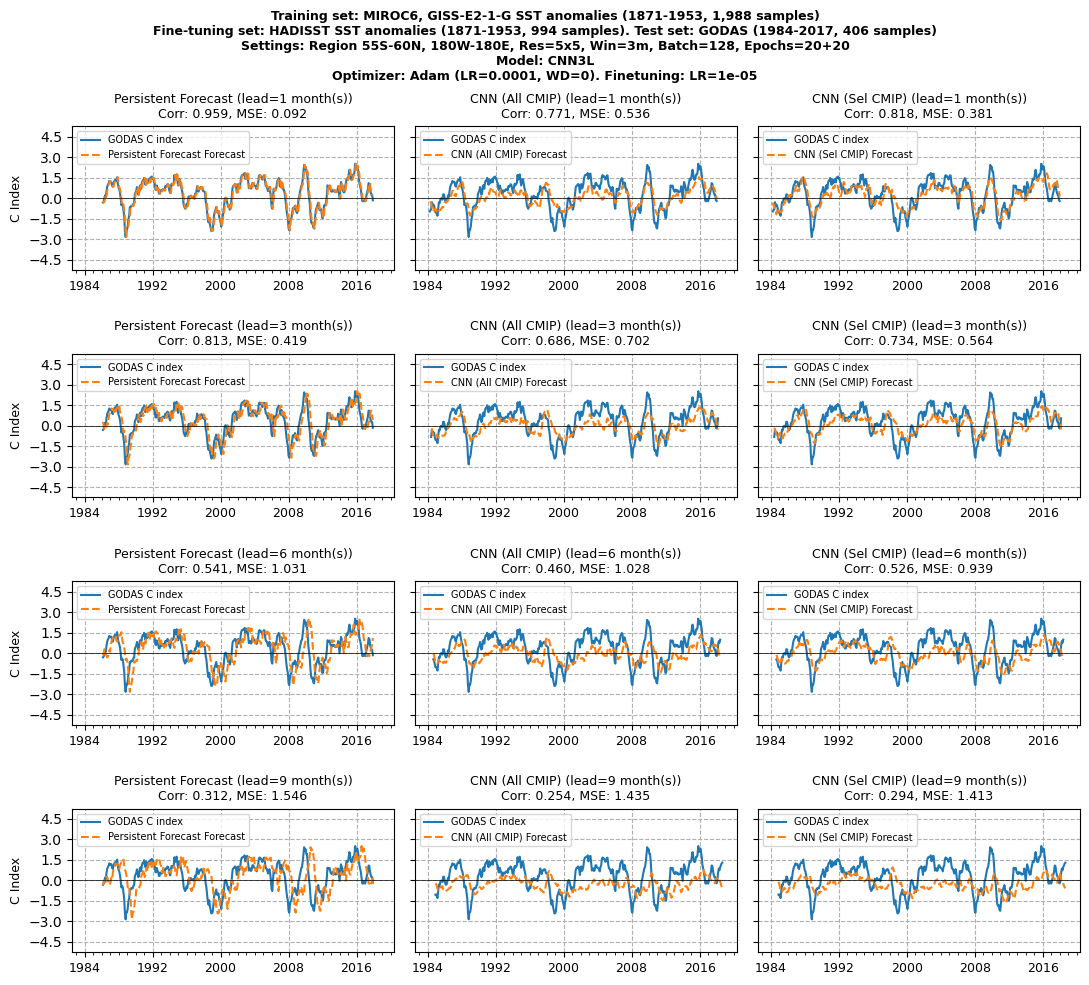

Saved _abl_dset_ts_CNN3L_Train_MIROC6_GISS_Tune_HADISST_1871-1953_Ep20-20_Test_GODAS_Win03_55S-60N_Res5_Adam_C.jpg to disk




In [74]:
# with title
for target in TARGETS:
    print(f"Target: {target} index")
    filename = f"_abl_dset_ts_{cnn_finetuning_results[target][-1]['experiment_name']}.jpg"

    # shorten the filename for Overleaf upload (max 150 chars)
    substrings_to_remove = ["tune_", "BnFalse_p000_", "_1984-2017", "-180W-180E", "_SGD", "Idx", "_Lead24"]
    for substring in substrings_to_remove:
        filename = filename.replace(substring, "")
    filename = filename.replace("MostEdgesCC", "MECC")
    filename = filename.replace("Layer", "L")
    
    graph_utils.plot_and_compare_timeseries(
        target=target,  # List of targets
        model_results_dict=model_results_dict,  
        abs_v_max=abs_v_max, 
        selected_lead_times=[1, 3, 6, 9],  
        selected_models=['Persistent Forecast', 'CNN (All CMIP)', 'CNN (Sel CMIP)'],  # List of models to plot
        suptitle=cnn_subtitle,
        save_img=SAVE_PLOTS_TO_DISK, 
        img_filename=filename, 
        img_folder=IMG_FOLDER
    )
    print("\n" + "=" * 200 + "\n")

Target: E index
Target: E index


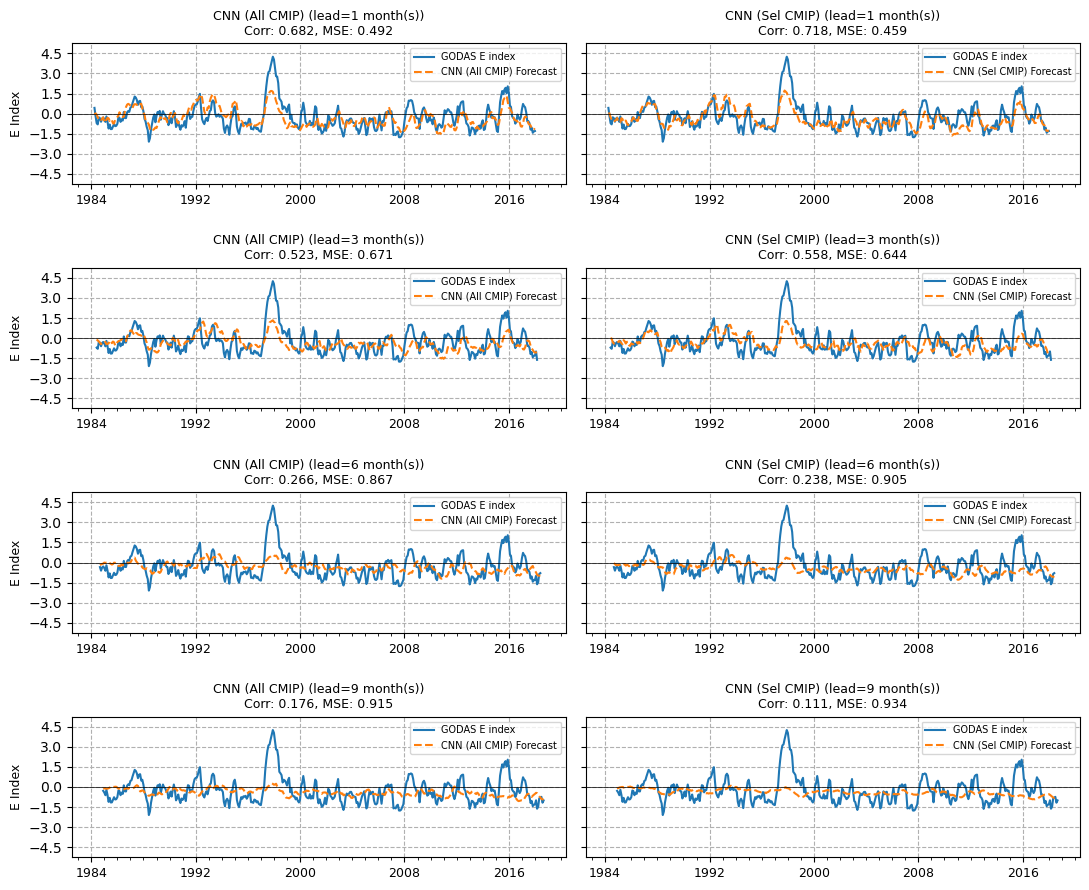

Saved _abl_dset_ts_CNN3L_Train_MIROC6_GISS_Tune_HADISST_1871-1953_Ep20-20_Test_GODAS_Win03_55S-60N_Res5_Adam_E_no_title.jpg to disk


Target: C index
Target: C index


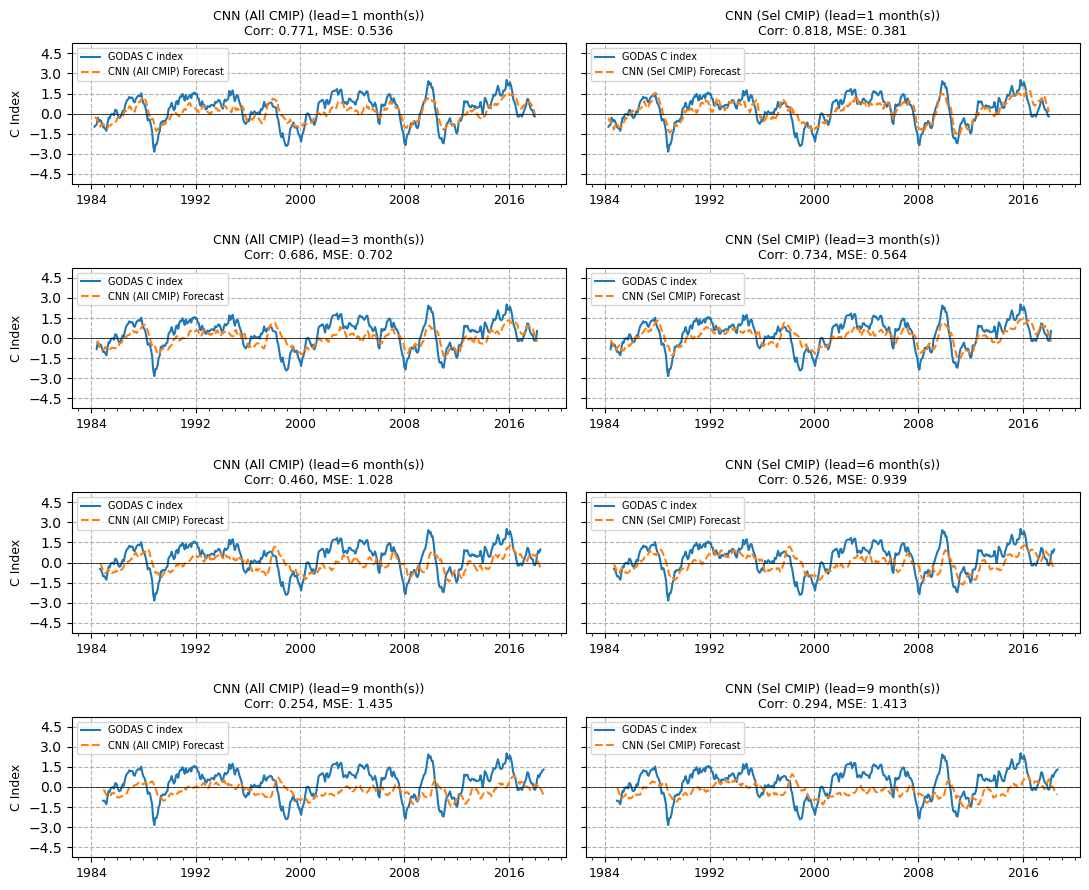

Saved _abl_dset_ts_CNN3L_Train_MIROC6_GISS_Tune_HADISST_1871-1953_Ep20-20_Test_GODAS_Win03_55S-60N_Res5_Adam_C_no_title.jpg to disk




In [75]:
# no title
for target in TARGETS:
    print(f"Target: {target} index")
    filename = f"_abl_dset_ts_{cnn_finetuning_results[target][-1]['experiment_name']}_no_title.jpg"

    # shorten the filename for Overleaf upload (max 150 chars)
    substrings_to_remove = ["tune_", "BnFalse_p000_", "_1984-2017", "-180W-180E", "_SGD", "Idx", "_Lead24"]
    for substring in substrings_to_remove:
        filename = filename.replace(substring, "")
    filename = filename.replace("MostEdgesCC", "MECC")
    filename = filename.replace("Layer", "L")
    
    graph_utils.plot_and_compare_timeseries(
        target=target,  # List of targets
        model_results_dict=model_results_dict,  
        abs_v_max=abs_v_max, 
        selected_lead_times=[1, 3, 6, 9],  
        # selected_models=['Persistent Forecast', 'Ridge Regression', 'CNN', 'CNN'],  # List of models to plot
        # selected_models=['Ridge Regr.', 'CNN', 'CNN'],  # List of models to plot
        # selected_models=['Persistent Forecast', 'CNN (All CMIP)', 'CNN (Sel CMIP)'],  # List of models to plot
        selected_models=['CNN (All CMIP)', 'CNN (Sel CMIP)'],  # List of models to plot
        suptitle=None,
        save_img=SAVE_PLOTS_TO_DISK, 
        img_filename=filename, 
        img_folder=IMG_FOLDER
    )
    print("\n" + "=" * 200 + "\n")

#### Plot correlations and MSE across lead times

In [76]:
correlation_dicts={
    # 'Persistence Forecast': pf_correlations,
    # 'Linear Regression': lr_correlations,
    # 'Ridge Regression': rr_correlations,
    # 'CNN': cnn_correlations,
    'CNN (All CMIP)': cnn_correlations_all_cmip,
    'CNN (Sel CMIP)': cnn_correlations_sel_cmip,
}
mse_dicts={
    # 'Persistence Forecast': pf_mses,
    # 'Linear Regression': lr_mses,
    # 'Ridge Regression': rr_mses,
    # 'CNN': cnn_mses,
    'CNN (All CMIP)': cnn_mses_all_cmip,
    'CNN (Sel CMIP)': cnn_mses_sel_cmip,
}

# model_list = [persist, ridge,    cnn,     cnn, ]
# color_list = ['blue', 'orange', 'green', 'red', 'purple'] # matplolib standard colors
# color_list = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd'] # matplolib standard colors
# color_list = ['#1f77b4', '#9467bd', '#2ca02c',  '#ff7f0e', '#d62728' ] # custom

# color_names = ['Blue', 'Muted Purple', 'Green', 'Orange', 'Red', 'Brown', 'Pink']
# color_list = ['#1f77b4', '#9467bd', '#2ca02c', '#ff7f0e', '#d62728', '#8c564b', '#e377c2']
# alpha_list = [0.3, 0.5, 1, 1, 1, 1, 1]
# linestyle_list=['-', '-', 'dotted', '--', '-', '-', '-']


color_names = ['Blue', 'Orange', 'Red', 'Muted Purple', 'Green', 'Brown', 'Pink']
color_list = ['#1f77b4', '#ff7f0e', '#d62728', '#9467bd', '#2ca02c', '#8c564b', '#e377c2']
alpha_list = [1, 1, 1, 1, 1, 1, 1]  # Increased transparency slightly for the less opaque lines
linestyle_list = ['-', '--', '-', '-.', '-', ':', '-']  # Added more varied linestyles
linewidth_list = [2, 2, 2.5, 2.5, 3, 3, 3]  # Increased line width for better visibility
marker_list = ['o', 's', '^', 'D', 'v', '<', '>']  # Added markers to distinguish lines further

In [77]:
cnn_subtitle

'Training set: MIROC6, GISS-E2-1-G SST anomalies (1871-1953, 1,988 samples)\nFine-tuning set: HADISST SST anomalies (1871-1953, 994 samples). Test set: GODAS (1984-2017, 406 samples)\nSettings: Region 55S-60N, 180W-180E, Res=5x5, Win=3m, Batch=128, Epochs=20+20\nModel: CNN3L\nOptimizer: Adam (LR=0.0001, WD=0). Finetuning: LR=1e-05'

Target: E index


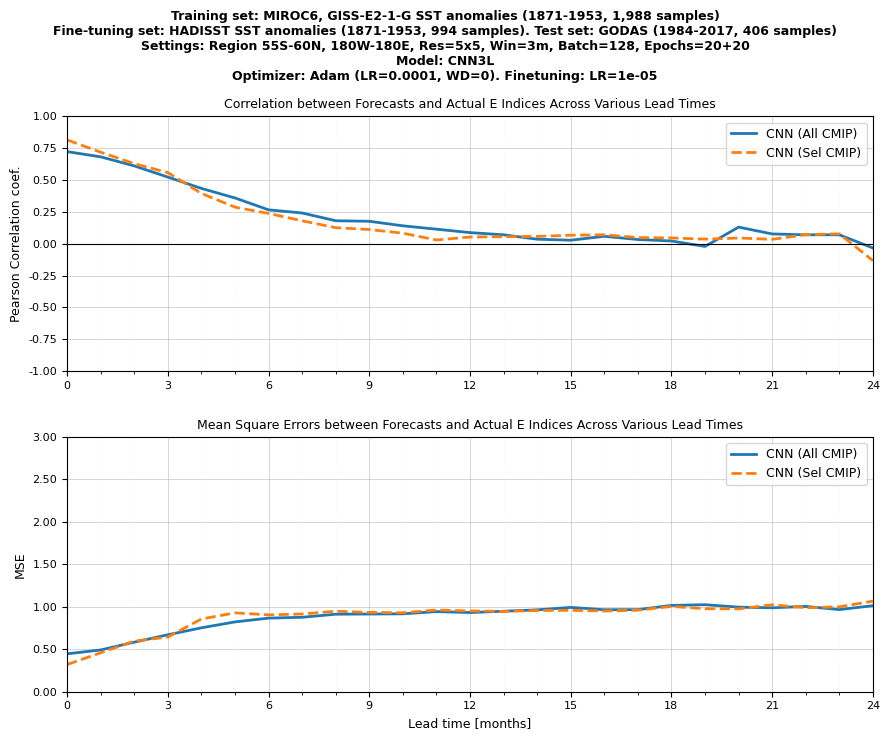

Saved _abl_dset_corr_mse_CNN3L_Train_MIROC6_GISS_Tune_HADISST_1871-1953_Ep20-20_Test_GODAS_Win03_55S-60N_Res5_Adam_E.jpg to disk


Target: C index


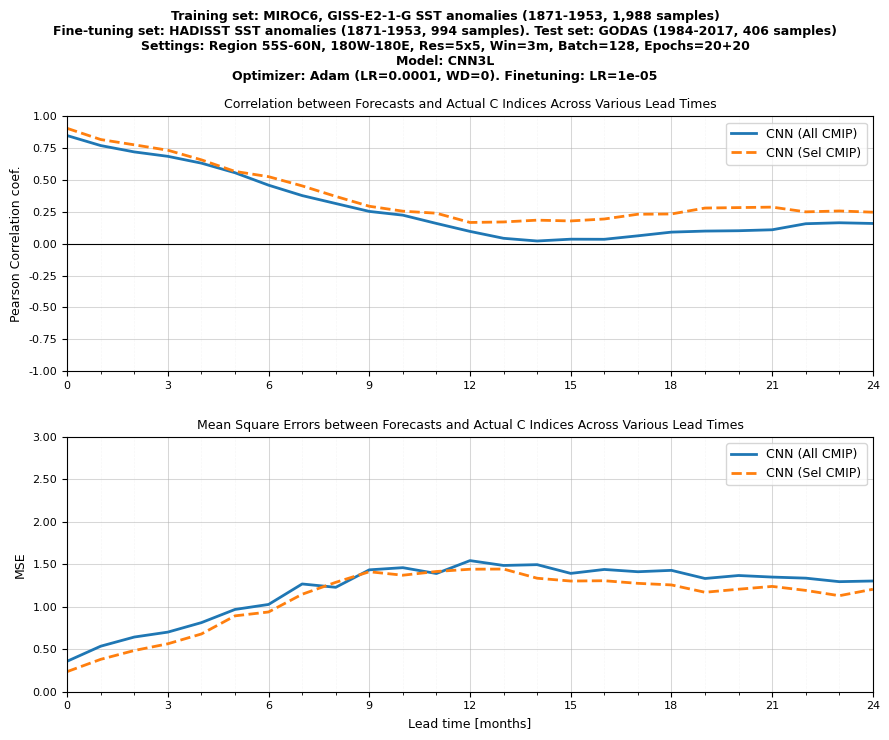

Saved _abl_dset_corr_mse_CNN3L_Train_MIROC6_GISS_Tune_HADISST_1871-1953_Ep20-20_Test_GODAS_Win03_55S-60N_Res5_Adam_C.jpg to disk




In [78]:
for target in TARGETS:
    print(f"Target: {target} index")
    filename = f"_abl_dset_corr_mse_{cnn_finetuning_results[target][-1]['experiment_name']}.jpg"

    # shorten the filename for Overleaf upload (max 150 chars)
    substrings_to_remove = ["model_", "tune_", "BnFalse_p000_", "_1984-2017", "-180W-180E", "_SGD", "Idx", "_Lead24"]
    for substring in substrings_to_remove:
        filename = filename.replace(substring, "")
    filename = filename.replace("MostEdgesCC", "MECC")
    filename = filename.replace("Layer", "L")
    
    graph_utils.plot_corr_mse(correlation_dicts, mse_dicts, target, MAX_LEAD_TIME, 
                              mse_y_lim_max=3, alpha_list=alpha_list, color_list=color_list, linestyle_list=linestyle_list, 
                              suptitle=cnn_subtitle, save_img=SAVE_PLOTS_TO_DISK, img_filename=filename, img_folder=IMG_FOLDER)
    print("\n" + "=" * 200 + "\n")

#### zoom in

Target: E index


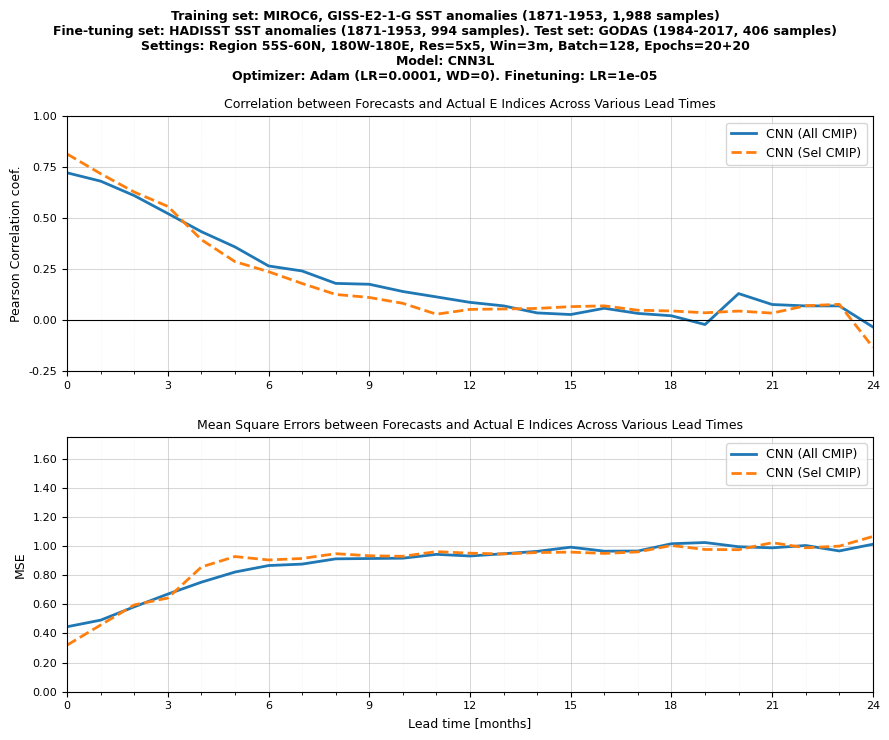

Saved _abl_dset_corr_mse_CNN3L_Train_MIROC6_GISS_Tune_HADISST_1871-1953_Ep20-20_Test_GODAS_Win03_55S-60N_Res5_Adam_E_zm.jpg to disk


Target: C index


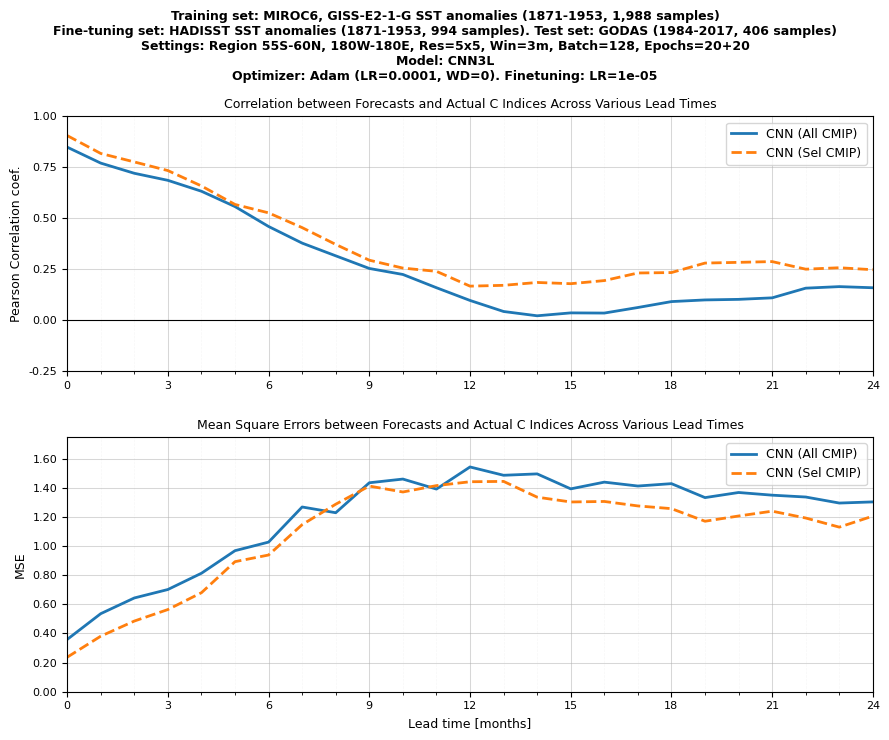

Saved _abl_dset_corr_mse_CNN3L_Train_MIROC6_GISS_Tune_HADISST_1871-1953_Ep20-20_Test_GODAS_Win03_55S-60N_Res5_Adam_C_zm.jpg to disk




In [79]:
# zoom in 
for target in TARGETS:
    print(f"Target: {target} index")
    filename = f"_abl_dset_corr_mse_{cnn_finetuning_results[target][-1]['experiment_name']}_zm.jpg"

    # shorten the filename for Overleaf upload (max 150 chars)
    substrings_to_remove = ["model_", "tune_", "BnFalse_p000_", "_1984-2017", "-180W-180E", "_SGD", "Idx", "_Lead24"]
    for substring in substrings_to_remove:
        filename = filename.replace(substring, "")
    filename = filename.replace("MostEdgesCC", "MECC")
    filename = filename.replace("Layer", "L")
    
    graph_utils.plot_corr_mse(correlation_dicts, mse_dicts, target, MAX_LEAD_TIME, 
                              mse_y_lim_max=1.75, corr_y_lim_min=-0.25, alpha_list=alpha_list, color_list=color_list, linestyle_list=linestyle_list, 
                              linewidth_list=None, marker_list=None, legend_outside=False,
                              suptitle=cnn_subtitle, save_img=SAVE_PLOTS_TO_DISK, img_filename=filename, img_folder=IMG_FOLDER)
    print("\n" + "=" * 200 + "\n")

#### Same plot without a title

Target: E index


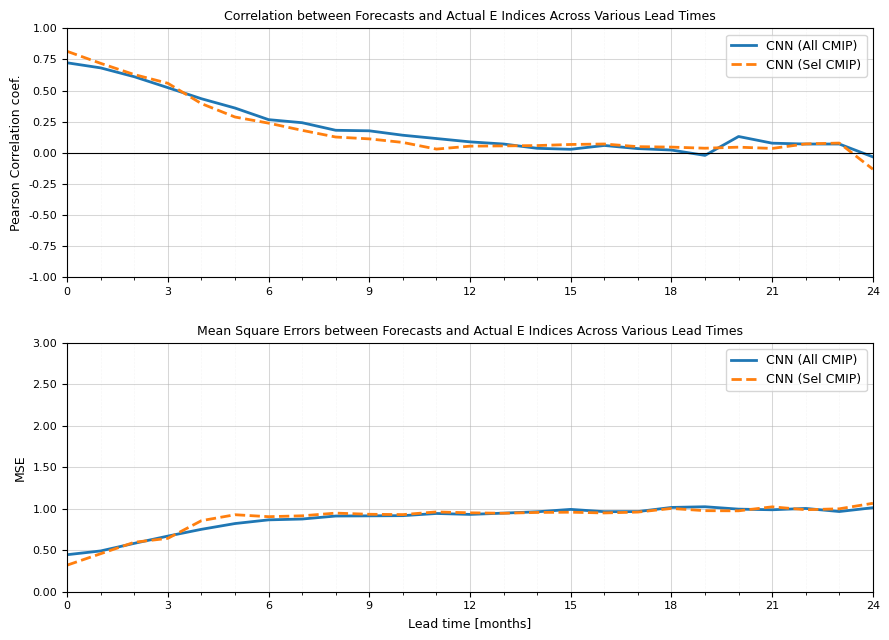

Saved _abl_dset_corr_mse_CNN3L_Train_MIROC6_GISS_Tune_HADISST_1871-1953_Ep20-20_Test_GODAS_Win03_55S-60N_Res5_Adam_E_no_title.jpg to disk


Target: C index


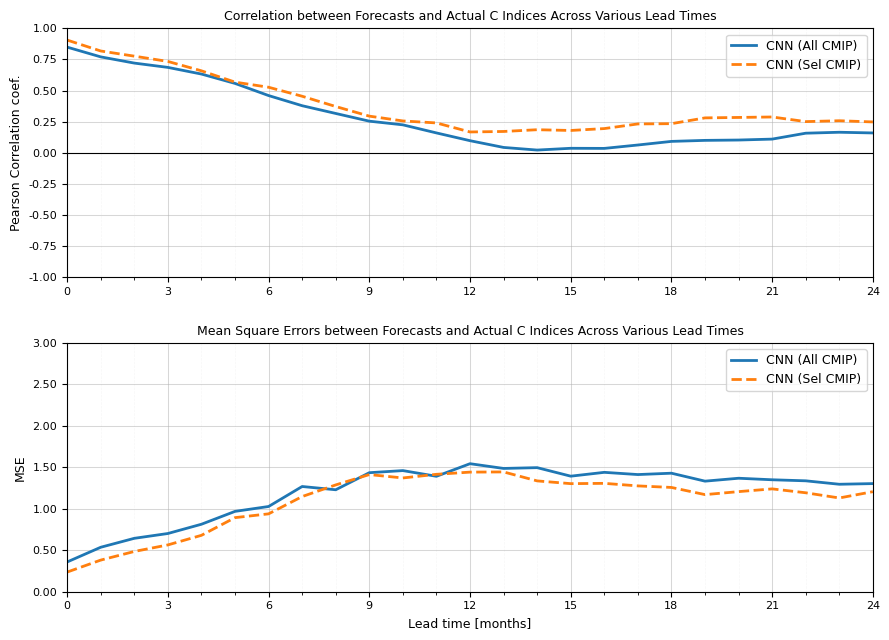

Saved _abl_dset_corr_mse_CNN3L_Train_MIROC6_GISS_Tune_HADISST_1871-1953_Ep20-20_Test_GODAS_Win03_55S-60N_Res5_Adam_C_no_title.jpg to disk




In [80]:
for target in TARGETS:
    print(f"Target: {target} index")
    filename = f"_abl_dset_corr_mse_{cnn_finetuning_results[target][-1]['experiment_name']}_no_title.jpg"
    # shorten the filename for Overleaf upload (max 150 chars)
    substrings_to_remove = ["model_", "tune_", "BnFalse_p000_", "_1984-2017", "-180W-180E", "_SGD", "Idx", "_Lead24"]
    for substring in substrings_to_remove:
        filename = filename.replace(substring, "")
    filename = filename.replace("MostEdgesCC", "MECC")
    filename = filename.replace("Layer", "L")
    
    graph_utils.plot_corr_mse(correlation_dicts, mse_dicts, target, MAX_LEAD_TIME, 
                              mse_y_lim_max=3, alpha_list=alpha_list, color_list=color_list, linestyle_list=linestyle_list, 
                              suptitle=None, save_img=SAVE_PLOTS_TO_DISK, img_filename=filename, img_folder=IMG_FOLDER)
    print("\n" + "=" * 200 + "\n")

#### zoom in 

Target: E index


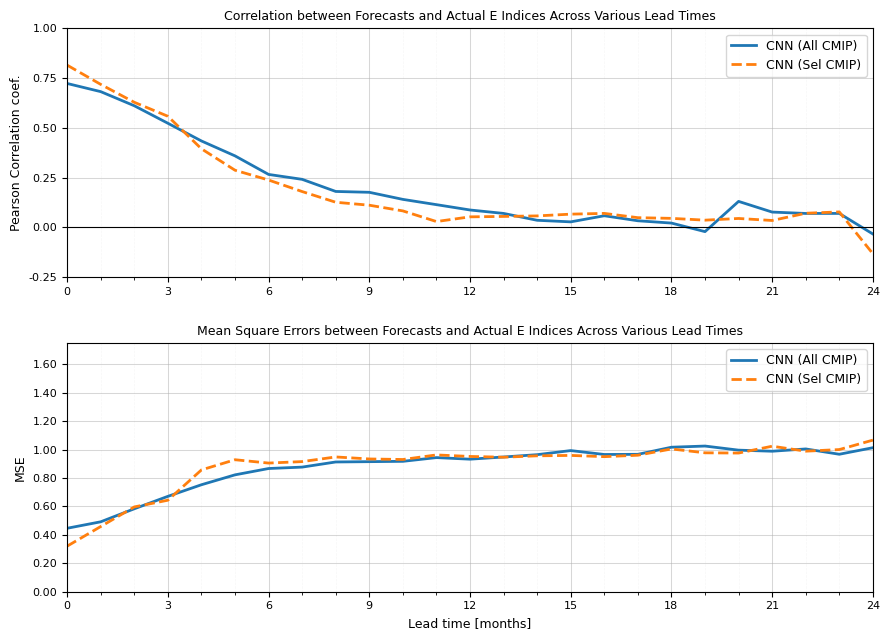

Saved _abl_dset_corr_mse_CNN3L_Train_MIROC6_GISS_Tune_HADISST_1871-1953_Ep20-20_Test_GODAS_Win03_55S-60N_Res5_Adam_E_zm_no_title.jpg to disk


Target: C index


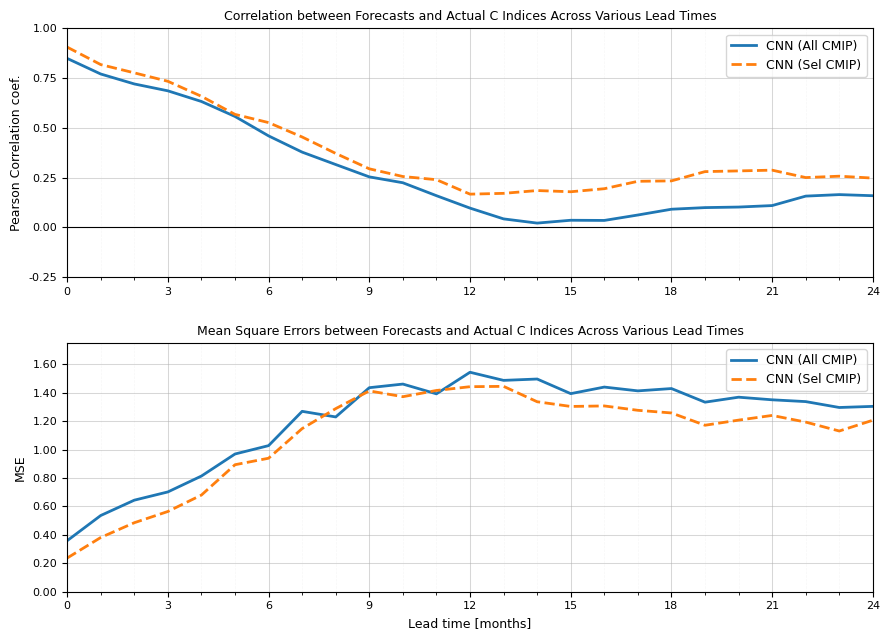

Saved _abl_dset_corr_mse_CNN3L_Train_MIROC6_GISS_Tune_HADISST_1871-1953_Ep20-20_Test_GODAS_Win03_55S-60N_Res5_Adam_C_zm_no_title.jpg to disk




In [81]:
# zoom in 
for target in TARGETS:
    print(f"Target: {target} index")
    filename = f"_abl_dset_corr_mse_{cnn_finetuning_results[target][-1]['experiment_name']}_zm_no_title.jpg"

    # shorten the filename for Overleaf upload (max 150 chars)
    substrings_to_remove = ["model_", "tune_", "BnFalse_p000_", "_1984-2017", "-180W-180E", "_SGD", "Idx", "_Lead24"]
    for substring in substrings_to_remove:
        filename = filename.replace(substring, "")
    filename = filename.replace("MostEdgesCC", "MECC")
    filename = filename.replace("Layer", "L")
    
    graph_utils.plot_corr_mse(correlation_dicts, mse_dicts, target, MAX_LEAD_TIME, 
                              mse_y_lim_max=1.75, corr_y_lim_min=-0.25, alpha_list=alpha_list, color_list=color_list, linestyle_list=linestyle_list, 
                              linewidth_list=None, marker_list=None, legend_outside=False,
                              suptitle=None, save_img=SAVE_PLOTS_TO_DISK, img_filename=filename, img_folder=IMG_FOLDER)
    print("\n" + "=" * 200 + "\n")

In [82]:
# dataiter = iter(val_dataloader)
# features, labels = next(dataiter)

In [83]:
# print(features.shape)
# predictions = model(features)

# # corr, _ = scipy.stats.pearsonr(predictions, labels)
# # mse = mean_squared_error(labels, predictions)
# # print("MSE: {:.2f}".format(mse))

# # plot_nino_time_series(y_test, predictions, source_id,
# #     f'Predicted and True Oceanic Niño Index at {lead_time:02d} Month Lead Time\nCorr: {corr:.2f}, MSE: {mse:.2f}')
# predictions

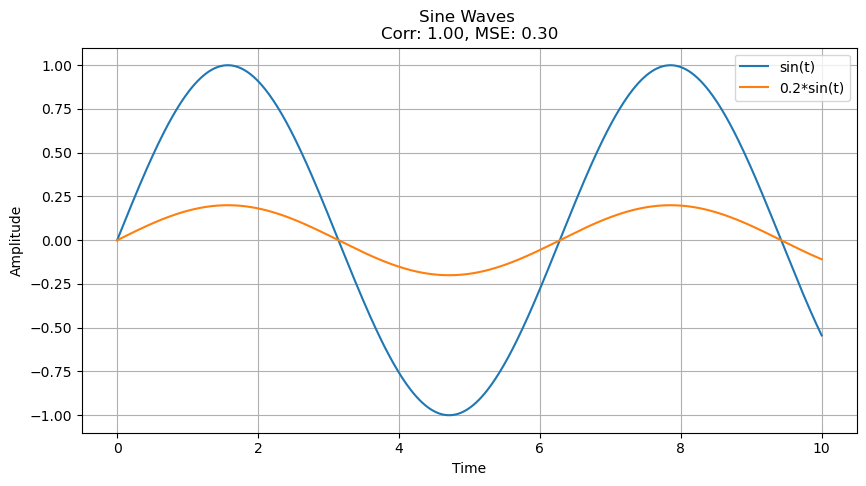

In [84]:
# Generate a sequence of time points
t = np.linspace(0, 10, 500)  # 0 to 10 seconds, 500 points

# Compute the sine of each point
y = np.sin(t)
y1 = 0.2*np.sin(t) # y's amplitude is much smaller than y's
# y1 = np.sin(t)-1 # y is shifted down by 1

corr, _ = scipy.stats.pearsonr(y1, y)
mse = mean_squared_error(y, y1)

# Plot the sine wave
plt.figure(figsize=(10, 5))
plt.plot(t, y, label="sin(t)")
plt.plot(t, y1, label="0.2*sin(t)")
# plt.plot(t, y1, label="sin(t)-1")

plt.title(f'Sine Waves \nCorr: {corr:.2f}, MSE: {mse:.2f}')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)
plt.show()